## Описание задачи


Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

Цель

Предсказать вероятность покупки в течение 90 дней

###  Описание данных

**apparel-purchases**

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.
В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам.
Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как
обработать такие случаи – можете предлагать свои варианты решения.

* client_id        -  идентификатор клиента
* quantity         -  количество единиц товара
* price            -  цена товара
* category_ids     -  идентификаторы категорий
* date             -  дата покупки
* message_id       -  идентификатор сообщения из рассылки


**apparel-messages**

Рассылки, которые были отправлены клиентам из таблицы покупок.
* bulk_campaign_id - идентификатор рассылки
* client_id  - идентификатор клиента
* message_id  - идентификатор сообщения
* event  - действие с сообщением (отправлено, открыто, покупка...)
* channel  - канал рассылки
* date  - дата действия
* created_at  - дата-время полностью


**target**
* client_id - идентификатор клиента
* target - клиент совершил покупку в целевом периоде



Агрегированные данные

**full_campaign_daily_event**
Агрегация общей базы рассылок по дням и типам событий
* date - дата
* bulk_campaign_id - идентификатор рассылки
* count_event* - общее количество каждого события event
* nunique_event* - количество уникальных

**full_campaign_daily_event_channel**
Агрегация по дням с учетом событий и каналов рассылки
* date - дата
* bulk_campaign_id - идентификатор рассылки
* count_event*_channel* -общее количество каждого события по каналам
* nunique_event*_channel* - количество уникальных client_id по событиям и каналам







In [1]:
!pip3 install -q scikit-learn --upgrade
!pip3 install -q catboost
#!pip3 install -q lightgbm
from datetime import datetime, timedelta
import shap

import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


# Масштабирование и обработка данных
from sklearn.preprocessing import (
    OneHotEncoder,  # Кодирование категориальных признаков методом one-hot
    OrdinalEncoder,  # Кодирование категорий порядковыми номерами
    StandardScaler,  # Нормализация данных
    MinMaxScaler,  # Масштабирование данных в диапазон [0, 1]
    RobustScaler,  # Масштабирование данных устойчиво к выбросам
    LabelEncoder  # Кодирование целевой переменной
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.utils.class_weight import compute_class_weight
from sklearn import svm


# Разделение данных и подбор гиперпараметров
from sklearn.model_selection import train_test_split  # Деление данных на обучающую и тестовую выборки
from sklearn.model_selection import RandomizedSearchCV#, GridSearchCV  # Автоматический подбор гиперпараметров

from sklearn.pipeline import Pipeline  # Пайплайн для объединения этапов обработки и обучения
from sklearn.compose import ColumnTransformer  # Применение разных трансформаций к разным столбцам
from sklearn.impute import SimpleImputer  # Заполнение пропусков в данных

from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score , accuracy_score

from sklearn.metrics import ConfusionMatrixDisplay

from catboost import CatBoostClassifier, Pool

In [2]:
def df_short_view(df): #показывает краткую информацию о таблице
    """
    Args
        df        # датафрейм из которого нужно показать данные.
    Returns 

    """
    print('Размер таблицы:', df.shape)
    print()
    print(df.info())
    print()    
    print(df.isna().sum())
    display(df.head(5))
    return

def emptyes_finder(df):
    """
    Находит и выводит количество пропущенных значений в каждом столбце DataFrame
    
    Параметры:
    df - pandas DataFrame для анализа
    """
    # Проверяем, что входные данные - это DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    
    print("Анализ пропущенных значений:")
    print("=" * 40)
    
    # Создаем пустой DataFrame для результатов
    result = pd.DataFrame(columns=['Column', 'Missing_Count', 'Missing_Percentage'])
    
    for column in df.columns:
        # Считаем пропуски (NaN, None и пустые строки)
        missing_count = df[column].isna().sum() + (df[column] == "").sum()
        total = len(df)
        missing_percent = (missing_count / total) * 100
        
        # Добавляем результаты
        result.loc[len(result)] = [column, missing_count, f"{missing_percent:.2f}%"]
        
        # Выводим информацию
        print(f"Колонка: {column}")
        print(f"Пропущенных значений: {missing_count}")
        print(f"Процент пропусков: {missing_percent:.2f}%")
        print("-" * 40)
    
    return result

In [3]:
def optimize_numeric_columns(df):
    # Целочисленные столбцы
    for col in df.select_dtypes(include=['integer']).columns:
        col_min = df[col].min()
        col_max = df[col].max()
        
        if col_min >= np.iinfo('int8').min and col_max <= np.iinfo('int8').max:
            df[col] = df[col].astype('int8')
        elif col_min >= np.iinfo('int16').min and col_max <= np.iinfo('int16').max:
            df[col] = df[col].astype('int16')
        elif col_min >= np.iinfo('int32').min and col_max <= np.iinfo('int32').max:
            df[col] = df[col].astype('int32')
    
    # Вещественные столбцы
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype('float32')
    
    return df

In [4]:

def hist_and_box_with_stats(df, column, title, bins,):
    """
    df     - данные
    column - признак по которому строятся графики
    title  - общий заголовок
    bins   - количество бинов для гистограммы
    """
    # Вычислим основные статистики
    mean = df[column].mean()
    median = df[column].median()
    mode = df[column].mode()[0]
    
    # Создадим сетку графиков: 1 строка и 2 столбца
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f"{title}", fontsize=18)
    
    # Гистограмма с KDE
    sns.histplot(df[column], bins=bins, kde=True, ax=ax[0])
    ax[0].set_title('Гистограмма', fontsize=10)
    ax[0].set_xlabel(column)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)
    
    # Линии для среднего, медианы и моды
    ax[0].axvline(mean, color='green', linestyle='--', label=f'Среднее = {mean:.2f}')
    ax[0].axvline(median, color='red', linestyle='-.', label=f'Медиана = {median:.2f}')
    ax[0].axvline(mode, color='blue', linestyle='-', label=f'Мода = {mode:.2f}')
    ax[0].legend()

    # Диаграмма размаха (boxplot)
    sns.boxplot(x=df[column], ax=ax[1])
    ax[1].set_title('Диаграмма размаха', fontsize=10)
    ax[1].axvline(median, color='red', linestyle='-.', label=f'Медиана = {median:.2f}')
    ax[1].grid(True)
    ax[1].legend()

    # Подгоним графики
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [5]:
def show_metrics(model, X_metric, y_metric):
    """
    """
 #   best_model = model.best_estimator_
#    y_pred = best_model.predict(X_metric)
    y_pred = model.predict(X_metric)
    roc = roc_auc_score(y_metric, y_pred)
    precision = precision_score(y_metric, y_pred)
    recall = recall_score(y_metric, y_pred)
    accuracy = accuracy_score(y_metric, y_pred)
#print(f'Accuracy of Random Forest: {accuracy:.2f}')
#    f1_score = f1_score(y_metric, y_pred)

    print('ROC-AUC =', round(roc,2))
    print('Precision =', round(precision,2))
    print('Recall =', round(recall,2))
    print('Accuracy =', round(accuracy,2))
#    print('F1_score =', round(f1_score,2))
    return

In [6]:
def return_metrics(model, X_metric, y_metric):
    """
    """
 #   best_model = model.best_estimator_
#    y_pred = best_model.predict(X_metric)
    y_pred = model.predict(X_metric)
    roc = roc_auc_score(y_metric, y_pred)
    precision = precision_score(y_metric, y_pred)
    recall = recall_score(y_metric, y_pred)
    accuracy = accuracy_score(y_metric, y_pred)
    f1 = f1_score(y_metric, y_pred)   
#
#y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_metric, y_pred)

#print(cm)

    TN = cm[0,0]
    FN = cm[1,0]
    TP = cm[1,1]
    FP = cm[0,1]
#    
    d = {
         'ROC_AUC': [roc], 
         'precision': [precision],
         'recall': [recall],
         'accuracy' : [accuracy],
         'f1_score' : [f1],
         'TN' : [TN],
         'FN' : [FN],
         'TP' : [TP],
         'FP' : [FP],
    }
    ds_mitrics = pd.DataFrame( data = d )
    
    return ds_mitrics
#---------------------------------------------------
def fit_and_metrics_return(model_name, pipe, param, n_iter, verbose, X_train, y_train,  X_test, y_test ):
    """
    Args
        model_name  #  Имя модели
        pipe,       # pipeline
        param,      # подготовленные параметры для перебора
        n_iter,     # количество итераций
        verbose,    # уровень логирования
        X_train,    #  Тренеровочные данные
        y_train,    # тренеровочный признак
        X_test,     #  тестовые данные
        y_test      #  тестовый признак

    Return
    """
# Запустим перебор гиперпараметров
    start_time = time.time()
#
    model= RandomizedSearchCV(
        pipe,
        param,
#        scoring=['roc_auc', 'precision'],  #        
        scoring='roc_auc',  #
#        scoring='precision',  #        
        cv=kfold,
        n_iter=iter_num,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose = 100,
    )
#    
    model.fit(X_train,y_train)
    print()
    display(model.best_params_)
#    
    
#    
    
    print('Метрики модели' , model_name, 'на тестовых данных :')
    show_metrics(model, X_test, y_test)
    print('Метрики модели' , model_name, 'на тренировочных данных:')
    show_metrics(model, X_train, y_train)
#
    print()
    print('Метрика оценки',model.scoring)  # Какая метрика использовалась?
    print()
    data = model.cv_results_
    df_result = pd.DataFrame(data)#, index=data[:,0])
    display(df_result)
    
#    
    end_time = time.time()
    elapsed_time_hiper = end_time - start_time
    print(f'Время запуска перебора: {elapsed_time_hiper:.2f} секунд')    
#   Подготовим данные метрик для выгрузки


    ds_mitrics_test = return_metrics(model, X_test, y_test)
    ds_mitrics_test['Model_name'] = model_name
    ds_mitrics_test['Model_check'] = 'Test'
    ds_mitrics_test['Model_scoring'] = model.scoring
    ds_mitrics_test['Model_best_params'] = str(model.best_params_)
    #
    ds_mitrics_train = return_metrics(model, X_train, y_train)
    ds_mitrics_train['Model_name'] = model_name
    ds_mitrics_train['Model_check'] = 'Train'
    ds_mitrics_train['Model_scoring'] = model.scoring
    ds_mitrics_train['Model_best_params'] = str(model.best_params_)


    
    ds_mitrics_result = pd.concat([
                                   ds_mitrics_train,
                                   ds_mitrics_test
                                ])
    
    print('-----------------------------------------------')
    print()
    display(ds_mitrics_result)   
    print('-----------------------------------------------')
    # построим матрицу ошибок методом from_estimator()
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.show()


#    
    return ds_mitrics_result


In [7]:
def hist_2_sets_density(df,column_for_paining, column_for_filtering, filter_1, filter_2, set1_label, set2_label ):    
    """
    Строит гистограмму по одному из признаков. Фильтрация происходит по другому БИНАРНОМУ признаку. 
    Значения двух набород данных выравниваются .
    
    Args
        df                   # Набор данных
        column_for_paining   # По какому признаку строим график
        column_for_filtering # По какому признаку разделяем по цветам
        filter_1             # Условие отбора для первого нобора
        filter_2             # Условие отбора для второго набора
        set1_label           # Название первого набора
        set2_label           # Название второго набора
    Returns 
    """
    set1 = df[column_for_paining].loc[df[column_for_filtering] == filter_1]
    set2 = df[column_for_paining].loc[df[column_for_filtering] == filter_2]
    bins = 30
    plt.figure(figsize=(14, 7), constrained_layout=True)
    
    plt.hist(
        [set1, set2], 
        bins, 
        density=True, 
#        common_norm=False, 
        label=[set1_label, set2_label],
    )
    
    plt.legend(loc='upper right')
    plt.title(column_for_paining)
    plt.ylabel('Распределение')
    plt.xlabel(column_for_paining)
    plt.show()
    return

In [8]:
import matplotlib.gridspec as gridspec

def bar_and_pie(df, column,title):
    """
    График категорийных признаков 
    ------------------------------------
    df     - данные
    column - признак по которому строятся графики
    title  - общий заголовок
    xl     - 
    """    
    yl = 'Частота'
    fg = plt.figure(figsize=(12, 5), constrained_layout=True)
    gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
    plt.suptitle(title, fontsize=18)
#
    fig_ax_1 = fg.add_subplot(gs[0, 0])
    df.groupby(column)[column].count().sort_values(ascending = False).plot(kind='bar')
    plt.xlabel(column,  fontsize=18)
    plt.ylabel(yl)
#    plt.title(title)
#    
    fig_ax_2 = fg.add_subplot(gs[0, 1])
    df.groupby(column)[column].count().plot(kind='pie', autopct='%1.1f%%')
    plt.xlabel(column,  fontsize=18)
    plt.ylabel(yl)
#    plt.title(title)

In [9]:
start_time_total = time.time()

## Загрузим данные

In [10]:
ds_a_messages = pd.read_csv('apparel-messages.csv')

In [11]:
ds_a_purchases = pd.read_csv('apparel-purchases.csv')

In [12]:
ds_a_target_binary = pd.read_csv('apparel-target_binary.csv')

In [13]:
ds_daily_event= pd.read_csv('full_campaign_daily_event.csv')

In [14]:
ds_daily_event_channel = pd.read_csv('full_campaign_daily_event_channel.csv')

In [15]:
# Оптимизируем числовые поля 

##################
ds_a_messages = optimize_numeric_columns(ds_a_messages)
ds_a_purchases = optimize_numeric_columns(ds_a_purchases)
ds_a_target_binary = optimize_numeric_columns(ds_a_target_binary)
ds_daily_event = optimize_numeric_columns(ds_daily_event)
ds_daily_event_channel = optimize_numeric_columns(ds_daily_event_channel)


In [16]:
df_short_view(ds_a_messages)

Размер таблицы: (12739798, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int16 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int16(1), int64(1), object(5)
memory usage: 607.5+ MB
None

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Приведём столбцы к нужному формату.

In [17]:
# Приведём к формату даты.
ds_a_messages['date'] = pd.to_datetime(ds_a_messages['date']).dt.normalize()


In [18]:
df_short_view(ds_a_messages)

Размер таблицы: (12739798, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int16         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        object        
dtypes: datetime64[ns](1), int16(1), int64(1), object(4)
memory usage: 607.5+ MB
None

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [19]:
df_short_view(ds_a_purchases)

Размер таблицы: (202208, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int8   
 2   price         202208 non-null  float32
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float32(1), int64(1), int8(1), object(3)
memory usage: 7.1+ MB
None

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Приведём столбцы к нужному формату.

In [20]:
# Приведём к формату даты.
ds_a_purchases['date'] = pd.to_datetime(ds_a_purchases['date']).dt.normalize()

# Цена указана в рублях, сделаем её целым числом.
ds_a_purchases['price'] = ds_a_purchases['price'].astype('int32')

ds_a_purchases = optimize_numeric_columns(ds_a_purchases)

In [21]:
df_short_view(ds_a_purchases)

Размер таблицы: (202208, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int8          
 2   price         202208 non-null  int32         
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), int8(1), object(2)
memory usage: 7.1+ MB
None

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [22]:
df_short_view(ds_a_target_binary)

Размер таблицы: (49849, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int8 
dtypes: int64(1), int8(1)
memory usage: 438.3 KB
None

client_id    0
target       0
dtype: int64


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Приведём столбцы к нужному формату.

In [23]:
df_short_view(ds_daily_event)

Размер таблицы: (131072, 24)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int16 
 2   count_click          131072 non-null  int32 
 3   count_complain       131072 non-null  int16 
 4   count_hard_bounce    131072 non-null  int32 
 5   count_open           131072 non-null  int32 
 6   count_purchase       131072 non-null  int16 
 7   count_send           131072 non-null  int32 
 8   count_soft_bounce    131072 non-null  int32 
 9   count_subscribe      131072 non-null  int16 
 10  count_unsubscribe    131072 non-null  int16 
 11  nunique_click        131072 non-null  int32 
 12  nunique_complain     131072 non-null  int16 
 13  nunique_hard_bounce  131072 non-null  int32 
 14  nunique_open         131072 non-null  int32 
 15  nuni

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Приведём столбцы к нужному формату.

In [24]:
# Приведём к формату даты.
ds_daily_event['date'] = pd.to_datetime(ds_daily_event['date']).dt.normalize()
# уменьшим разрадность хранения чисел.

#ds_daily_event = optimize_numeric_columns(ds_daily_event)

In [25]:
df_short_view(ds_daily_event_channel)

Размер таблицы: (131072, 36)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int16 
 2   count_click_email                131072 non-null  int32 
 3   count_click_mobile_push          131072 non-null  int32 
 4   count_open_email                 131072 non-null  int32 
 5   count_open_mobile_push           131072 non-null  int32 
 6   count_purchase_email             131072 non-null  int16 
 7   count_purchase_mobile_push       131072 non-null  int16 
 8   count_soft_bounce_email          131072 non-null  int32 
 9   count_subscribe_email            131072 non-null  int16 
 10  count_unsubscribe_email          131072 non-null  int16 
 11  nunique_click_email              131072 non-null

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
display(ds_daily_event_channel.describe())

,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,6.362679,...,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
std,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,79.172069,...,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,9089.000000,...,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000


Приведём столбцы к нужному формату.

In [27]:
# Приведём к формату даты.
ds_daily_event_channel['date'] = pd.to_datetime(ds_daily_event_channel['date']).dt.normalize()
# уменьшим разрадность хранения чисел.
#ds_daily_event_channel = optimize_numeric_columns(ds_daily_event_channel)


### Проверяем результат

In [28]:
df_short_view(ds_a_messages)

Размер таблицы: (12739798, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int16         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        object        
dtypes: datetime64[ns](1), int16(1), int64(1), object(4)
memory usage: 607.5+ MB
None

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [29]:
df_short_view(ds_a_purchases)

Размер таблицы: (202208, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int8          
 2   price         202208 non-null  int32         
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), int8(1), object(2)
memory usage: 7.1+ MB
None

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [30]:
#optimize_numeric_columns(ds_a_purchases)

In [31]:
df_short_view(ds_a_target_binary)

Размер таблицы: (49849, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int8 
dtypes: int64(1), int8(1)
memory usage: 438.3 KB
None

client_id    0
target       0
dtype: int64


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [32]:
df_short_view(ds_daily_event)

Размер таблицы: (131072, 24)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int16         
 2   count_click          131072 non-null  int32         
 3   count_complain       131072 non-null  int16         
 4   count_hard_bounce    131072 non-null  int32         
 5   count_open           131072 non-null  int32         
 6   count_purchase       131072 non-null  int16         
 7   count_send           131072 non-null  int32         
 8   count_soft_bounce    131072 non-null  int32         
 9   count_subscribe      131072 non-null  int16         
 10  count_unsubscribe    131072 non-null  int16         
 11  nunique_click        131072 non-null  int32         
 12  nunique_complain     131072 non-null  int1

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [33]:
df_short_view(ds_daily_event_channel)

Размер таблицы: (131072, 36)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int16         
 2   count_click_email                131072 non-null  int32         
 3   count_click_mobile_push          131072 non-null  int32         
 4   count_open_email                 131072 non-null  int32         
 5   count_open_mobile_push           131072 non-null  int32         
 6   count_purchase_email             131072 non-null  int16         
 7   count_purchase_mobile_push       131072 non-null  int16         
 8   count_soft_bounce_email          131072 non-null  int32         
 9   count_subscribe_email            131072 non-null  int16         
 10  count_unsubscr

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#optimize_numeric_columns(ds_daily_event_channel)

### Итог загрузки

* Загружены 5 наборов данных.
* Даты преведены к формату data
* Уменьшена разрядность хранения целочисленных значений с 64 бита до 16-32.


## Проверка данных

### Посмотрим на целевой признак **ds_a_target_binary**

In [35]:
display(ds_a_target_binary.head(10))
display('Количество уникальных значений', ds_a_target_binary.nunique() )

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


'Количество уникальных значений'

client_id    49849
target           2
dtype: int64

In [36]:
display('Количество вариантов целевого признака', ds_a_target_binary['target'].value_counts() )

'Количество вариантов целевого признака'

target
0    48888
1      961
Name: count, dtype: int64

### Посмотрим на ds_a_purchases

In [37]:
display(ds_a_purchases.describe())

,client_id,quantity,price,date
count,2.022080e+05,202208.000000,202208.000000,202208
mean,1.515916e+18,1.006483,1193.301516,2023-03-17 02:49:35.739832064
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00
25%,1.515916e+18,1.000000,352.000000,2022-11-12 00:00:00
50%,1.515916e+18,1.000000,987.000000,2023-04-12 00:00:00
75%,1.515916e+18,1.000000,1699.000000,2023-07-03 00:00:00
max,1.515916e+18,30.000000,85499.000000,2024-02-16 00:00:00
std,1.459514e+08,0.184384,1342.252664,NaN


In [38]:
display((ds_a_purchases['quantity'].loc[ds_a_purchases['quantity'] == 1].count()) / (ds_a_purchases['quantity'].count()))

0.9956233185630637

Видно что значительная часть заказов содержат 1 единицу товара. 99.5% если быть точнее.

In [39]:
display(ds_a_purchases['quantity'].value_counts() )

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

In [40]:
display(ds_a_purchases.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int8          
 2   price         202208 non-null  int32         
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), int8(1), object(2)
memory usage: 7.1+ MB


None

Посмотрим количество дубликатов

In [41]:
print('Число явных дублей в ds_test равно', ds_a_purchases.duplicated().sum())

Число явных дублей в ds_test равно 73020


In [42]:
display(ds_a_purchases.loc[ds_a_purchases.duplicated()].sort_values(by='message_id').head(10))

,client_id,quantity,price,category_ids,date,message_id
3699,1515915625468060902,1,199,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196
3698,1515915625468060902,1,1999,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196
81794,1515915625468061003,1,2100,"['4', '28', '249', '615']",2023-01-04,1515915625468061003-9148-63b54b04855a4
200016,1515915625468061100,1,1049,"['4', '27', '1828', '5717']",2024-02-10,1515915625468061100-14623-65c5c55eeb9e0
95807,1515915625468061170,1,7,[],2023-03-26,1515915625468061170-11144-641ad2cda77a2
95809,1515915625468061170,1,2699,"['2', '18', '258', '441']",2023-03-26,1515915625468061170-11144-641ad2cda77a2
96095,1515915625468061170,1,2195,"['4', '28', '260', '420']",2023-03-29,1515915625468061170-11208-6423f082d2fcb
96097,1515915625468061170,1,2199,"['4', '28', '260', '420']",2023-03-29,1515915625468061170-11208-6423f082d2fcb
96096,1515915625468061170,1,2199,"['4', '28', '260', '420']",2023-03-29,1515915625468061170-11208-6423f082d2fcb
96101,1515915625468061170,1,2194,"['4', '28', '260', '420']",2023-03-29,1515915625468061170-11208-6423f082d2fcb


Видим заказанный пакетик за 7 рублей. Неожиданно, но скорее всего пакет забыли добавить в предыдущем заказе.

In [43]:
emptyes_finder(ds_a_purchases)

Анализ пропущенных значений:
Колонка: client_id
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: quantity
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: category_ids
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: date
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: message_id
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------


,Column,Missing_Count,Missing_Percentage
0,client_id,0,0.00%
1,quantity,0,0.00%
2,price,0,0.00%
3,category_ids,0,0.00%
4,date,0,0.00%
5,message_id,0,0.00%


Явных пропусков нет.

Посмотрим на записи с пустыми категориями.

In [44]:
display(ds_a_purchases.loc[ds_a_purchases['category_ids'] =='[]'] )

,client_id,quantity,price,category_ids,date,message_id
22153,1515915625558323436,1,1,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
22154,1515915625558323436,1,1,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
49215,1515915625474537721,1,7,[],2022-11-12,1515915625474537721-7803-636dfed5eb8b6
53223,1515915625720375281,1,5,[],2022-11-13,1515915625720375281-7818-636f6ec29a382
59056,1515915625867975448,1,7,[],2022-11-16,1515915625766044118-7879-63748749d81b5
...,...,...,...,...,...,...
201990,1515915625641742458,1,7,[],2024-02-16,1515915625766077627-14668-65cf5246bd490
202068,1515915625955716904,1,7,[],2024-02-16,1515915625955716904-14668-65cf5252e767c
202069,1515915625955716904,1,7,[],2024-02-16,1515915625955716904-14668-65cf5252e767c
202144,1515915626007712189,1,12,[],2024-02-16,1515915626007712189-14648-65cdb6d1c0c2a


5579 дозаказов с упаковкой?

In [45]:
#.value_counts()
display(ds_a_purchases['price'].loc[ds_a_purchases['category_ids'] =='[]'].value_counts() )

price
7      2694
5       987
10      414
1       356
6       301
       ... 
257       2
91        1
125       1
420       1
181       1
Name: count, Length: 69, dtype: int64

Предположим что заказы с неуказанным **category_ids** - это упаковка или услуга типа доставки. Почему её нет в каталоге непонятно, присвоим всем пропущенным категориям 1999.

In [46]:
ds_a_purchases['category_ids'] = ds_a_purchases['category_ids'].replace('[]', "['1999']")

In [47]:
display('Количество уникальных значений', ds_a_purchases.nunique() )

'Количество уникальных значений'

client_id       49849
quantity           16
price            3642
category_ids      933
date              642
message_id      50204
dtype: int64

In [48]:
display(ds_a_purchases.loc[ds_a_purchases['client_id'] == 1515915625468169594])

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
41172,1515915625468169594,1,742,"['2', '18', '258', '1569']",2022-10-19,1515915625468169594-7180-634d2f82d8799
149569,1515915625468169594,1,1050,"['4', '28', '124', '1602']",2023-06-30,1515915625468169594-13392-649554cd9b5ee
149570,1515915625468169594,1,864,"['4', '28', '124', '1602']",2023-06-30,1515915625468169594-13392-649554cd9b5ee
179933,1515915625468169594,1,4599,"['4', '28', '62', '657']",2023-11-22,1515915625468169594-14161-655db26e4d76f
179934,1515915625468169594,1,4599,"['4', '28', '62', '657']",2023-11-22,1515915625468169594-14161-655db26e4d76f
179935,1515915625468169594,1,3999,"['4', '28', '62', '657']",2023-11-22,1515915625468169594-14161-655db26e4d76f
179936,1515915625468169594,1,3261,"['4', '28', '62', '657']",2023-11-22,1515915625468169594-14161-655db26e4d76f


/home/segius/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


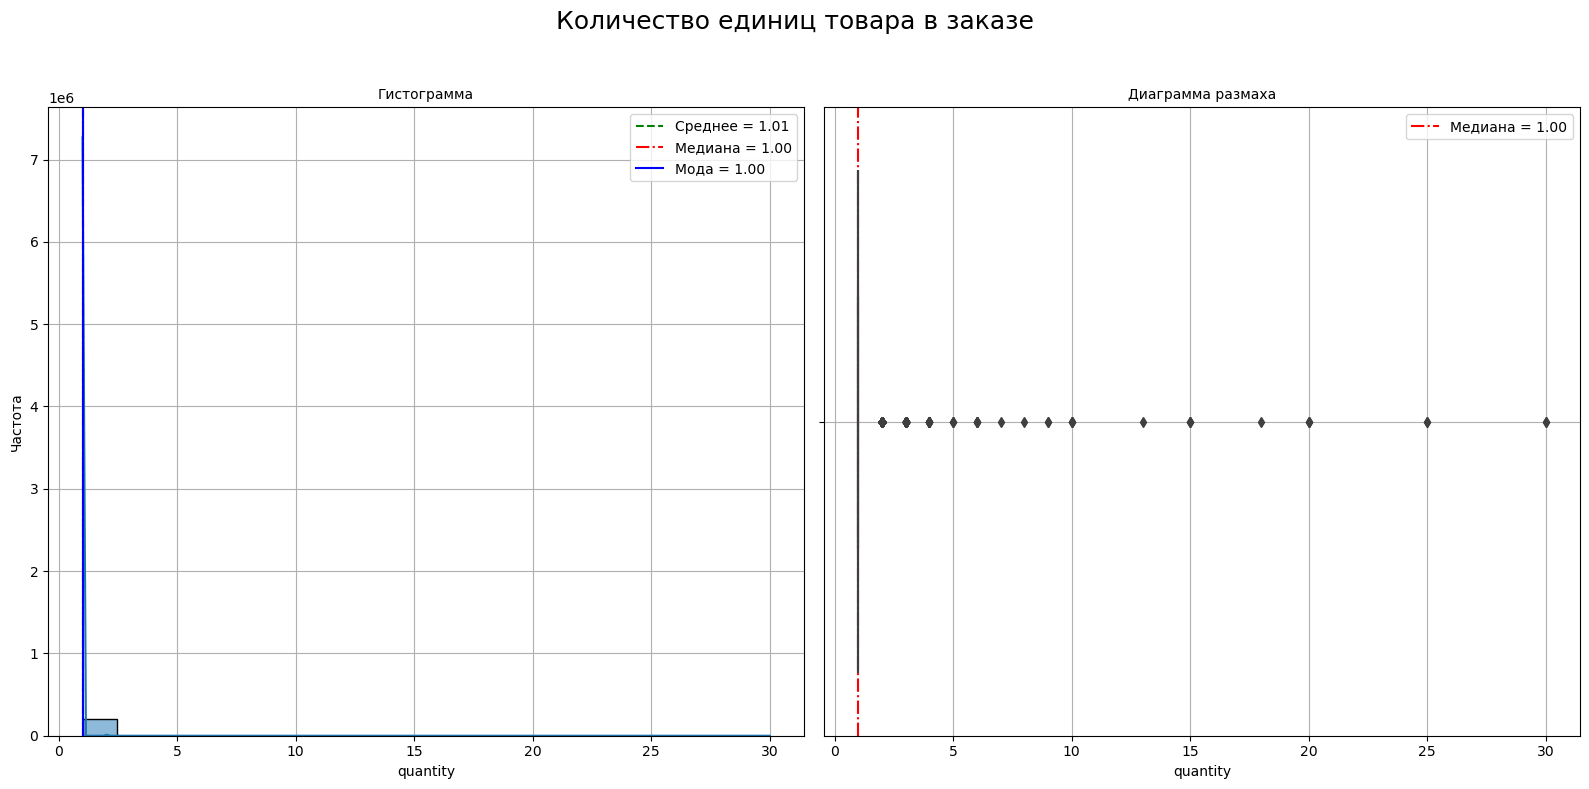

In [49]:
# Построим график количества
hist_and_box_with_stats(
     ds_a_purchases,   #df, 
     'quantity',       #column, 
     'Количество единиц товара в заказе',       # title, 
     20,      #bins,
 )
 

Из-за перекоса в данных графики получаются не очень наглядные.

/home/segius/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


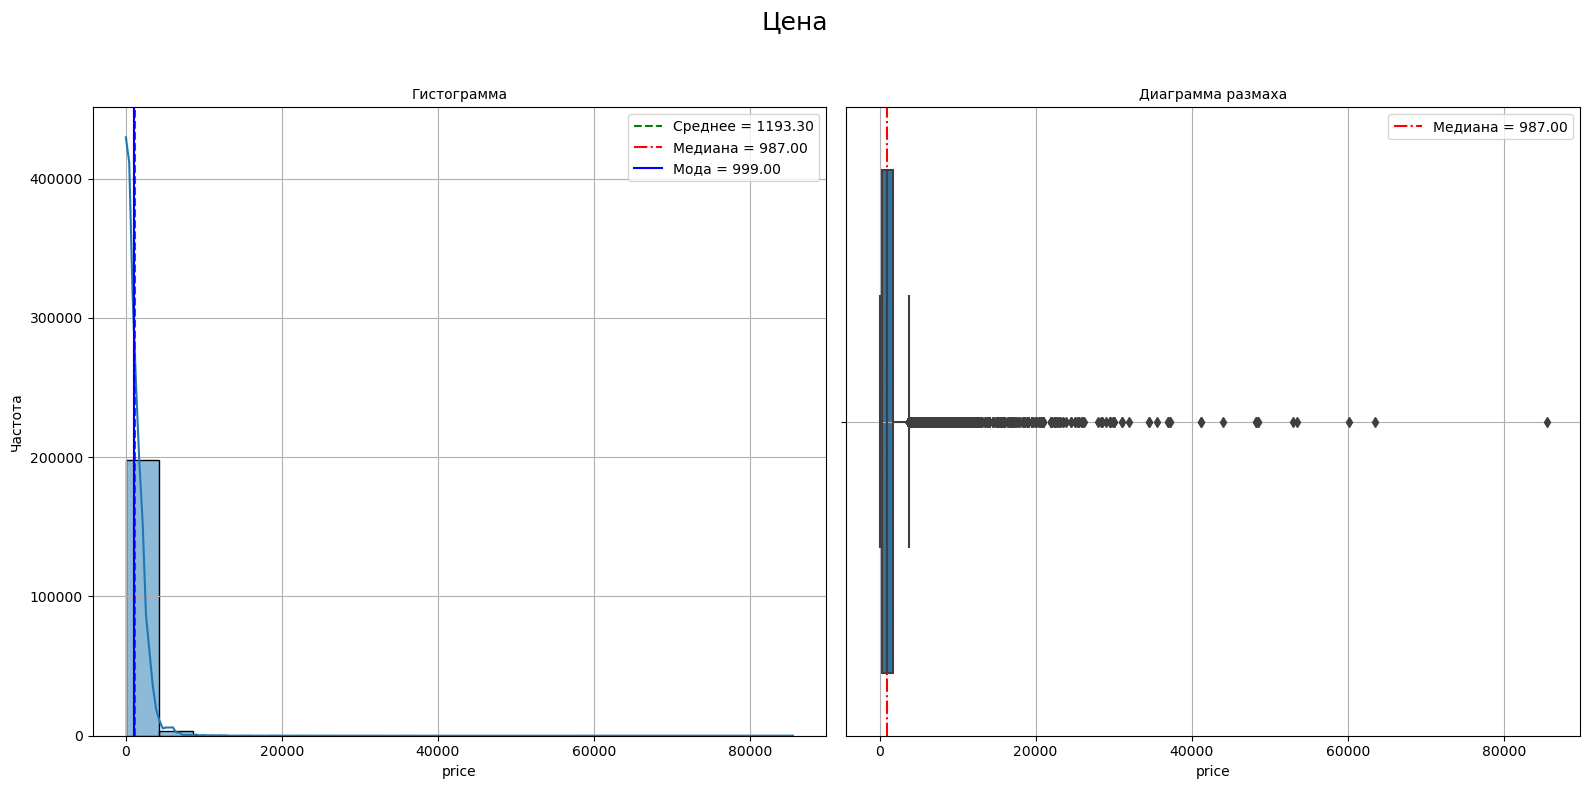

In [50]:
# Построим график количества
hist_and_box_with_stats(
     ds_a_purchases,   #df, 
     'price',       #column, 
     'Цена',       # title, 
     20,      #bins,
 )
 

Половина заказов до 1000 рублей. Но встречаются и заказы на 60-80к рублей.

### Посмотрим на ds_a_messages

In [51]:
#ds_a_messages
display('Количество уникальных значений', ds_a_messages['client_id'].nunique() )

'Количество уникальных значений'

53329

In [52]:
display('Количество уникальных значений', ds_a_messages.nunique() )

'Количество уникальных значений'

bulk_campaign_id       2709
client_id             53329
message_id          9061667
event                    11
channel                   2
date                    638
created_at          4103539
dtype: int64

Больше чем в наборе сданными где есть target.

In [53]:
display(ds_a_messages.loc[ds_a_messages['client_id'] == 1515915625468169594])

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
1308,4463,1515915625468169594,1515915625468169594-4463-6285e40442c50,send,email,2022-05-19,2022-05-19 06:31:47
9157,4463,1515915625468169594,1515915625468169594-4463-6285e40442c50,open,email,2022-05-19,2022-05-19 08:02:13
101835,4568,1515915625468169594,1515915625468169594-4568-628ddb4b07e71,send,email,2022-05-25,2022-05-25 08:34:40
104015,4568,1515915625468169594,1515915625468169594-4568-628ddb4b07e71,open,email,2022-05-25,2022-05-25 08:41:54
119374,4591,1515915625468169594,1515915625468169594-4591-628f1e827259b,send,email,2022-05-26,2022-05-26 06:36:00
...,...,...,...,...,...,...,...
12541739,14625,1515915625468169594,1515915625468169594-14625-65c5ed58c2066,open,email,2024-02-09,2024-02-09 15:47:22
12626173,14641,1515915625468169594,1515915625468169594-14641-65cb249358ae1,send,email,2024-02-13,2024-02-13 09:31:17
12641233,14641,1515915625468169594,1515915625468169594-14641-65cb249358ae1,open,email,2024-02-13,2024-02-13 10:51:33
12643893,14624,1515915625468169594,1515915625468169594-14624-65c5e2327aa23,send,email,2024-02-13,2024-02-13 11:15:27


Посмотрим какие варианты рассылок бывают.

In [54]:
display('Количество уникальных значений в поле channel', ds_a_messages['channel'].value_counts() )

'Количество уникальных значений в поле channel'

channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64

In [55]:
display('Количество уникальных значений в поле event', ds_a_messages['event'].value_counts() )

'Количество уникальных значений в поле event'

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

In [56]:
display('Количество уникальных значений в поле event для email сообщений', ds_a_messages['event'].loc[ds_a_messages['channel'] == 'email'].value_counts() )

'Количество уникальных значений в поле event для email сообщений'

event
send           3937235
open            874674
click           356241
purchase         45289
soft_bounce       9567
unsubscribe       2841
hbq_spam           823
complain           528
hard_bounce        359
subscribe           85
Name: count, dtype: int64

In [57]:
display('Количество уникальных значений в поле event для mobile_push сообщений', ds_a_messages['event'].loc[ds_a_messages['channel'] == 'mobile_push'].value_counts() )

'Количество уникальных значений в поле event для mobile_push сообщений'

event
send           5120961
open           2211146
click           140098
hard_bounce      19544
purchase         19390
soft_bounce       1016
close                1
Name: count, dtype: int64

### Посмотрим  ds_daily_event

In [58]:
display('Количество уникальных значений', ds_daily_event['bulk_campaign_id'].nunique() )

'Количество уникальных значений'

3181

In [59]:
# Посмотрим на одну случайную рассылку
display(ds_daily_event.loc[ds_daily_event['bulk_campaign_id'] == 4439])

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
143,2022-05-19,4439,2053,0,0,6796,33,0,8,5,...,6317,29,0,8,5,294,0,0,0,0
294,2022-05-20,4439,929,0,0,3389,19,0,1,3,...,3187,12,0,1,3,181,0,0,0,0
443,2022-05-21,4439,475,0,0,2006,12,0,0,3,...,1870,9,0,0,3,94,0,0,0,0
573,2022-05-22,4439,424,0,0,1870,5,0,2,3,...,1690,5,0,2,3,101,0,0,0,0
732,2022-05-23,4439,327,0,0,1720,2,0,0,4,...,1605,2,0,0,3,122,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88372,2023-10-07,4439,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90710,2023-10-30,4439,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90810,2023-10-31,4439,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104971,2024-01-26,4439,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Посмотрим  ds_daily_event_channel

In [60]:
display('Количество уникальных значений', ds_daily_event_channel['bulk_campaign_id'].nunique() )

'Количество уникальных значений'

3181

In [61]:
display(ds_daily_event_channel.loc[ds_daily_event_channel['bulk_campaign_id'] == 4439])

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
143,2022-05-19,4439,2053,0,6796,0,33,0,8,5,...,0,0,0,0,0,0,0,0,0,0
294,2022-05-20,4439,929,0,3389,0,19,0,1,3,...,0,0,0,0,0,0,0,0,0,0
443,2022-05-21,4439,475,0,2006,0,12,0,0,3,...,0,0,0,0,0,0,0,0,0,0
573,2022-05-22,4439,424,0,1870,0,5,0,2,3,...,0,0,0,0,0,0,0,0,0,0
732,2022-05-23,4439,327,0,1720,0,2,0,0,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88372,2023-10-07,4439,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90710,2023-10-30,4439,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90810,2023-10-31,4439,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104971,2024-01-26,4439,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Итог шага проверки данных

* Обнаружен значительный перекос в целевом признаке: 50 к 1.
* Обнаружено что 99.5% заказов содержат 1 единицу товара

## Очистка данных


* устранение дубликатов
* Обработка пропусков

## Добавим данных

* создание новых признаков, 
* агрегирование признаков.

### Займёмся категориями

В столбце с категориями товаров в заказе хранятся записи вида : ['4', '28', '57', '431']
Даже если в заказе всего 1 товар. Значит что это цепочка признаков указывающая на товар.
Первое значение обычно является числом из одной цифры. Значит оно указывает на верхнюю категорию товара. 
А последнее число в списке указывает непосредственно на подкатегорию купленного товара.
Вытащим эти две записи.
Т.к. 99.5% заказов состоят из одного товара, то более сложные случаи рассматривать не будем.


In [62]:
ds_a_purchases['first_category'] = (
    ds_a_purchases['category_ids']
    .str.extract(r"^\s*\['([^']*)'")  # Извлекаем первое значение в кавычках
    .iloc[:, 0]
)

ds_a_purchases['last_category'] = (
    ds_a_purchases['category_ids']
    .str.extract(r"'([^']*)'\s*\]$")  # Извлекаем последнее значение в кавычках
    .iloc[:, 0]
)

#ds_a_purchases['first_category']  = pd.to_numeric(ds_a_purchases['first_category']).fillna(0).astype(np.int32)
#ds_a_purchases['last_category']  = pd.to_numeric(ds_a_purchases['last_category']).fillna(0).astype(np.int32)

In [63]:
# Проверяем что получилось
print(ds_a_purchases[['category_ids', 'first_category', 'last_category']].head(10))

# Статистика по новому полю
print("\nРаспределение last_category:")
print(ds_a_purchases['last_category'].value_counts(dropna=False))

                      category_ids first_category last_category
0         ['4', '28', '57', '431']              4           431
1         ['4', '28', '57', '431']              4           431
2         ['4', '28', '57', '431']              4           431
3        ['4', '28', '244', '432']              4           432
4         ['4', '28', '49', '413']              4           413
5        ['2', '18', '258', '441']              2           441
6       ['2', '18', '341', '1311']              2          1311
7        ['2', '18', '123', '451']              2           451
8  ['5562', '5631', '5549', '667']           5562           667
9  ['5562', '5630', '5649', '678']           5562           678

Распределение last_category:
last_category
431     8626
420     6989
432     6821
1999    5579
421     4936
        ... 
1089       1
1600       1
5529       1
1726       1
751        1
Name: count, Length: 844, dtype: int64


In [64]:
df_short_view(ds_a_purchases)

Размер таблицы: (202208, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       202208 non-null  int64         
 1   quantity        202208 non-null  int8          
 2   price           202208 non-null  int32         
 3   category_ids    202208 non-null  object        
 4   date            202208 non-null  datetime64[ns]
 5   message_id      202208 non-null  object        
 6   first_category  200944 non-null  object        
 7   last_category   200944 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), int8(1), object(4)
memory usage: 10.2+ MB
None

client_id            0
quantity             0
price                0
category_ids         0
date                 0
message_id           0
first_category    1264
last_category     1264
dtype: int64


,client_id,quantity,price,category_ids,date,message_id,first_category,last_category
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431
2,1515915625471138230,1,6499,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4,431
3,1515915625471138230,1,4999,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4,432
4,1515915625471138230,1,4999,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4,413


In [65]:
# Разворачиваем списки в отдельные строки и находим уникальные значения
unique_last_categories = ds_a_purchases['last_category'].explode().dropna().unique()
unique_1st_categories = ds_a_purchases['first_category'].explode().dropna().unique()
print('Количество уникальных категорий в заказах',len(unique_last_categories))
display(unique_last_categories)
print('-----------------')
display(unique_1st_categories)

Количество уникальных категорий в заказах 843


array(['431', '432', '413', '441', '1311', '451', '667', '678', '1392',
       '490', '443', '417', '1786', '1795', '550', '710', '957', '636',
       '445', '840', '425', '505', '420', '560', '608', '424', '658',
       '496', '436', '421', '1312', '416', '464', '510', '466', '615',
       '481', '548', '1817', '673', '415', '568', '1305', '462', '586',
       '5504', '726', '681', '434', '1582', '684', '701', '1598', '1006',
       '561', '934', '555', '546', '544', '489', '470', '572', '478',
       '842', '1691', '1848', '5502', '1431', '879', '422', '418', '465',
       '628', '551', '652', '524', '1047', '1167', '1567', '676', '793',
       '506', '637', '848', '1565', '1587', '938', '1602', '656', '577',
       '602', '1367', '1583', '1080', '1637', '439', '1584', '440',
       '1590', '1007', '1815', '442', '1330', '450', '928', '5500', '482',
       '1586', '475', '5498', '448', '1831', '463', '1596', '1597', '724',
       '1847', '500', '1594', '1599', '1829', '1562', '446', 

-----------------


array(['4', '2', '5562', '1', '1999', '5963', '3', '6060', '5'],
      dtype=object)

Категорий слишком много, в OHE передавать их пока не будем.

In [66]:
#display(ds_cat_result)
#display(ds_cat_result.info())

In [67]:
  display(ds_a_purchases['last_category'].head(10))

0     431
1     431
2     431
3     432
4     413
5     441
6    1311
7     451
8     667
9     678
Name: last_category, dtype: object

In [68]:
#display(ds_pivot.head())
#display(ds_pivot.info())

In [69]:
# Функция для разбивки на периоды 1, 3 ,6, 9 ,12, 12+ месяцев
def get_period(row_date):
    months_diff = (today.year - row_date.year) * 12 + (today.month - row_date.month)
    if months_diff <= 1:
        return '1_month'
    elif months_diff <= 3:
        return '3_months'
    elif months_diff <= 6:
        return '6_months'
    elif months_diff <= 9:
        return '9_months'
    elif months_diff <= 12:
        return '12_months'
    else:
        return '12+_months'



### Добавим признаки в ds_a_messages

In [70]:
#  дата для вычисления периодов
today = ds_a_messages['date'].max()
print(today)

2024-02-15 00:00:00


In [71]:
# Добавляем столбец с периодом
ds_a_messages['period'] = ds_a_messages['date'].apply(get_period)

In [72]:
display(ds_a_messages.head(10))

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,period
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,12+_months
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,12+_months
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,12+_months
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,12+_months
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,12+_months
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11,12+_months
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54,12+_months
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43,12+_months
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16,12+_months
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06,12+_months


Новый столбец появился.

#### ds_pivot_messages

In [73]:
ds_pivot_messages = ds_a_messages.pivot_table(
    index='client_id',
    columns=['period'],
    values=[
        'bulk_campaign_id', 
        'event', 
#        'date',
#        'category_ids'
    ],
    aggfunc={
        'bulk_campaign_id': 'count',
        'event': 'count',
#        'date': 'min',
#        'category_ids': join_categories
    }
)


In [74]:
display(ds_pivot_messages.head(10))

bulk_campaign_id                                      \
period                    12+_months 12_months 1_month 3_months 6_months   
client_id                                                                  
1515915625468060902             87.0      23.0    13.0     20.0     24.0   
1515915625468061003             63.0      19.0     9.0     14.0     28.0   
1515915625468061099            173.0      24.0    17.0     15.0     25.0   
1515915625468061100             82.0       NaN    56.0     93.0    100.0   
1515915625468061170             75.0      31.0    55.0     77.0     26.0   
1515915625468061514             84.0      19.0    13.0     23.0     30.0   
1515915625468061877             67.0       NaN    35.0     65.0     62.0   
1515915625468061899             70.0      18.0    11.0      7.0     10.0   
1515915625468061975             85.0      21.0     7.0     18.0     24.0   
1515915625468061994            136.0      30.0    42.0     57.0     66.0   

                                  event                                      \
period              9_months 12+_months 12_months 1_month 3_months 6_months   
client_id                                                                     
1515915625468060902     10.0       87.0      23.0    13.0     20.0     24.0   
1515915625468061003     33.0       63.0      19.0     9.0     14.0     28.0   
1515915625468061099     22.0      173.0      24.0    17.0     15.0     25.0   
1515915625468061100    103.0       82.0       NaN    56.0     93.0    100.0   
1515915625468061170     29.0       75.0      31.0    55.0     77.0     26.0   
1515915625468061514     11.0       84.0      19.0    13.0     23.0     30.0   
1515915625468061877      NaN       67.0       NaN    35.0     65.0     62.0   
1515915625468061899     13.0       70.0      18.0    11.0      7.0     10.0   
1515915625468061975     25.0       85.0      21.0     7.0     18.0     24.0   
1515915625468061994     49.0      136.0      30.0    42.0     57.0     66.0   

                              
period              9_months  
client_id                     
1515915625468060902     10.0  
1515915625468061003     33.0  
1515915625468061099     22.0  
1515915625468061100    103.0  
1515915625468061170     29.0  
1515915625468061514     11.0  
1515915625468061877      NaN  
1515915625468061899     13.0  
1515915625468061975     25.0  
1515915625468061994     49.0

In [75]:

# Преобразуем имена столбцов
ds_pivot_messages.columns = [
#    f"{func}_{var}_{month}"
    f"{var}_{month}"
    for var, month in ds_pivot_messages.columns
]


Если рекламного взаимодействия с пользователем не было, укажем в этих признаках 0.

In [76]:
# Заполним пропуски 0.
ds_pivot_messages = ds_pivot_messages.fillna(0)

In [77]:
display(ds_pivot_messages.head(10))

,bulk_campaign_id_12+_months,bulk_campaign_id_12_months,bulk_campaign_id_1_month,bulk_campaign_id_3_months,bulk_campaign_id_6_months,bulk_campaign_id_9_months,event_12+_months,event_12_months,event_1_month,event_3_months,event_6_months,event_9_months
client_id,,,,,,,,,,,,
1515915625468060902,87.0,23.0,13.0,20.0,24.0,10.0,87.0,23.0,13.0,20.0,24.0,10.0
1515915625468061003,63.0,19.0,9.0,14.0,28.0,33.0,63.0,19.0,9.0,14.0,28.0,33.0
1515915625468061099,173.0,24.0,17.0,15.0,25.0,22.0,173.0,24.0,17.0,15.0,25.0,22.0
1515915625468061100,82.0,0.0,56.0,93.0,100.0,103.0,82.0,0.0,56.0,93.0,100.0,103.0
1515915625468061170,75.0,31.0,55.0,77.0,26.0,29.0,75.0,31.0,55.0,77.0,26.0,29.0
1515915625468061514,84.0,19.0,13.0,23.0,30.0,11.0,84.0,19.0,13.0,23.0,30.0,11.0
1515915625468061877,67.0,0.0,35.0,65.0,62.0,0.0,67.0,0.0,35.0,65.0,62.0,0.0
1515915625468061899,70.0,18.0,11.0,7.0,10.0,13.0,70.0,18.0,11.0,7.0,10.0,13.0
1515915625468061975,85.0,21.0,7.0,18.0,24.0,25.0,85.0,21.0,7.0,18.0,24.0,25.0


Добавим бинарные признаки присутствия или отсутствия рекламных событий для пользователя по периодам. 1- что-то было, 0- ничего не было.

In [78]:
#display('Количество уникальных значений в поле event', ds_pivot_messages['event'].value_counts() )


ds_pivot_messages['cat_event_1_month'] = 0
ds_pivot_messages['cat_event_1_month'].loc[ds_pivot_messages['event_1_month'] > 0 ] = 1

ds_pivot_messages['cat_event_3_months'] = 0
ds_pivot_messages['cat_event_3_months'].loc[ds_pivot_messages['event_3_months'] > 0 ] = 1

ds_pivot_messages['cat_event_6_months'] = 0
ds_pivot_messages['cat_event_6_months'].loc[ds_pivot_messages['event_6_months'] > 0 ] = 1

ds_pivot_messages['cat_event_9_months'] = 0
ds_pivot_messages['cat_event_9_months'].loc[ds_pivot_messages['event_9_months'] > 0 ] = 1

ds_pivot_messages['cat_event_12_months'] = 0
ds_pivot_messages['cat_event_12_months'].loc[ds_pivot_messages['event_12_months'] > 0 ] = 1

ds_pivot_messages['cat_event_12+_months'] = 0
ds_pivot_messages['cat_event_12+_months'].loc[ds_pivot_messages['event_12+_months'] > 0 ] = 1




# Преобразуем признак 'unsubscribe' в категорийный
ds_pivot_messages['cat_event_1_month'] = ds_pivot_messages['cat_event_1_month'].astype('category')
ds_pivot_messages['cat_event_3_months'] = ds_pivot_messages['cat_event_3_months'].astype('category')
ds_pivot_messages['cat_event_6_months'] = ds_pivot_messages['cat_event_6_months'].astype('category')
ds_pivot_messages['cat_event_9_months'] = ds_pivot_messages['cat_event_9_months'].astype('category')
ds_pivot_messages['cat_event_12_months'] = ds_pivot_messages['cat_event_12_months'].astype('category')
ds_pivot_messages['cat_event_12+_months'] = ds_pivot_messages['cat_event_12+_months'].astype('category')

/tmp/ipykernel_229520/1033204199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_pivot_messages['cat_event_1_month'].loc[ds_pivot_messages['event_1_month'] > 0 ] = 1
/tmp/ipykernel_229520/1033204199.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_pivot_messages['cat_event_3_months'].loc[ds_pivot_messages['event_3_months'] > 0 ] = 1
/tmp/ipykernel_229520/1033204199.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_pi

In [79]:

ds_pivot_messages['cat_bulk_campaign_id_1_month'] = 0
ds_pivot_messages['cat_bulk_campaign_id_1_month'].loc[ds_pivot_messages['bulk_campaign_id_1_month'] > 0 ] = 1

ds_pivot_messages['cat_bulk_campaign_id_3_months'] = 0
ds_pivot_messages['cat_bulk_campaign_id_3_months'].loc[ds_pivot_messages['bulk_campaign_id_3_months'] > 0 ] = 1

ds_pivot_messages['cat_bulk_campaign_id_6_months'] = 0
ds_pivot_messages['cat_bulk_campaign_id_6_months'].loc[ds_pivot_messages['bulk_campaign_id_6_months'] > 0 ] = 1

ds_pivot_messages['cat_bulk_campaign_id_9_months'] = 0
ds_pivot_messages['cat_bulk_campaign_id_9_months'].loc[ds_pivot_messages['bulk_campaign_id_9_months'] > 0 ] = 1

ds_pivot_messages['cat_bulk_campaign_id_12_months'] = 0
ds_pivot_messages['cat_bulk_campaign_id_12_months'].loc[ds_pivot_messages['bulk_campaign_id_12_months'] > 0 ] = 1

ds_pivot_messages['cat_bulk_campaign_id_12+_months'] = 0
ds_pivot_messages['cat_bulk_campaign_id_12+_months'].loc[ds_pivot_messages['bulk_campaign_id_12+_months'] > 0 ] = 1




# Преобразуем признак 'unsubscribe' в категорийный
ds_pivot_messages['cat_bulk_campaign_id_1_month'] = ds_pivot_messages['cat_bulk_campaign_id_1_month'].astype('category')
ds_pivot_messages['cat_bulk_campaign_id_3_months'] = ds_pivot_messages['cat_bulk_campaign_id_3_months'].astype('category')
ds_pivot_messages['cat_bulk_campaign_id_6_months'] = ds_pivot_messages['cat_bulk_campaign_id_6_months'].astype('category')
ds_pivot_messages['cat_bulk_campaign_id_9_months'] = ds_pivot_messages['cat_bulk_campaign_id_9_months'].astype('category')
ds_pivot_messages['cat_bulk_campaign_id_12_months'] = ds_pivot_messages['cat_bulk_campaign_id_12_months'].astype('category')
ds_pivot_messages['cat_bulk_campaign_id_12+_months'] = ds_pivot_messages['cat_bulk_campaign_id_12+_months'].astype('category')

/tmp/ipykernel_229520/3439376298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_pivot_messages['cat_bulk_campaign_id_1_month'].loc[ds_pivot_messages['bulk_campaign_id_1_month'] > 0 ] = 1
/tmp/ipykernel_229520/3439376298.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_pivot_messages['cat_bulk_campaign_id_3_months'].loc[ds_pivot_messages['bulk_campaign_id_3_months'] > 0 ] = 1
/tmp/ipykernel_229520/3439376298.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Добавим признак содержащий количество дней между срезом данных и последней рекламной активностью.

In [80]:
#########    ---------- Добавим дополнительные признаки в таблицу.
#  дата для вычисления периодов
today = ds_a_messages['date'].max()

print(today)


# Количество дней после последней покупки
ds_a_messages['day_to_0'] = (today - ds_a_messages['date'] ).dt.days


# Добавляем столбец с датой. потом по ним посчитаем мин и макс по датам.
ds_a_messages['date_min'] = ds_a_messages['date']
ds_a_messages['date_max'] = ds_a_messages['date']


2024-02-15 00:00:00


Добавим бинарный признак почтовой или сотовой рассылки клиенту. 

In [81]:
ds_a_messages['channel_email'] = 0
ds_a_messages['channel_email'].loc[ds_a_messages['channel'] == 'email' ] = 1

ds_a_messages['channel_mobile'] = 0
ds_a_messages['channel_mobile'].loc[ds_a_messages['channel'] == 'mobile_push' ] = 1

/tmp/ipykernel_229520/2497621663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_a_messages['channel_email'].loc[ds_a_messages['channel'] == 'email' ] = 1
/tmp/ipykernel_229520/2497621663.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_a_messages['channel_mobile'].loc[ds_a_messages['channel'] == 'mobile_push' ] = 1


In [82]:

display(ds_a_messages.sort_values(by='client_id').head(10))

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,period,day_to_0,date_min,date_max,channel_email,channel_mobile
3485204,9148,1515915625468060902,1515915625468060902-9148-63b54b46a6cd3,send,email,2023-01-04,2023-01-04 10:46:15,12+_months,407,2023-01-04,2023-01-04,1,0
2333892,7659,1515915625468060902,1515915625468060902-7659-6368e55d61551,open,email,2022-11-07,2022-11-07 15:11:58,12+_months,465,2022-11-07,2022-11-07,1,0
6923759,13640,1515915625468060902,1515915625468060902-13640-64d5f73170e39,open,email,2023-08-11,2023-08-11 12:52:04,6_months,188,2023-08-11,2023-08-11,1,0
1530497,6316,1515915625468060902,1515915625468060902-6316-63201ca88eb2b,click,email,2022-09-14,2022-09-14 05:29:29,12+_months,519,2022-09-14,2022-09-14,1,0
2333899,7659,1515915625468060902,1515915625468060902-7659-6368e55d61551,click,email,2022-11-07,2022-11-07 15:12:38,12+_months,465,2022-11-07,2022-11-07,1,0
1530498,6316,1515915625468060902,1515915625468060902-6316-63201ca88eb2b,click,email,2022-09-14,2022-09-14 05:29:37,12+_months,519,2022-09-14,2022-09-14,1,0
1357179,6223,1515915625468060902,1515915625468060902-6223-630c908a0269b,open,email,2022-08-30,2022-08-30 04:10:39,12+_months,534,2022-08-30,2022-08-30,1,0
11334639,14439,1515915625468060902,1515915625468060902-14439-65990697894e5,open,email,2024-01-09,2024-01-09 06:43:01,1_month,37,2024-01-09,2024-01-09,1,0
11049405,14419,1515915625468060902,1515915625468060902-14419-658fb2b0bdca0,send,email,2023-12-30,2023-12-30 06:30:21,3_months,47,2023-12-30,2023-12-30,1,0
5211954,12784,1515915625468060902,1515915625468060902-12784-646e0fc270b53,send,email,2023-05-24,2023-05-24 13:24:37,9_months,267,2023-05-24,2023-05-24,1,0


In [83]:
display('Количество уникальных значений в поле bulk_campaign_id', ds_a_messages['bulk_campaign_id'].nunique() )

'Количество уникальных значений в поле bulk_campaign_id'

2709

In [84]:
display('Количество уникальных значений в поле event', ds_a_messages['event'].value_counts() )


ds_a_messages['unsubscribe'] = 0
ds_a_messages['unsubscribe'].loc[ds_a_messages['event'] == 'unsubscribe' ] = 1

ds_a_messages['purchase'] = 0
ds_a_messages['purchase'].loc[ds_a_messages['event'] == 'purchase' ] = 1

ds_a_messages['open'] = 0
ds_a_messages['open'].loc[ds_a_messages['event'] == 'open' ] = 1

ds_a_messages['click'] = 0
ds_a_messages['click'].loc[ds_a_messages['event'] == 'click' ] = 1

ds_a_messages['bounce'] = 0
ds_a_messages['bounce'].loc[ds_a_messages['event'] == 'hard_bounce' ] = 1
ds_a_messages['bounce'].loc[ds_a_messages['event'] == 'soft_bounce' ] = 1


'Количество уникальных значений в поле event'

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

/tmp/ipykernel_229520/24215998.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_a_messages['unsubscribe'].loc[ds_a_messages['event'] == 'unsubscribe' ] = 1
/tmp/ipykernel_229520/24215998.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_a_messages['purchase'].loc[ds_a_messages['event'] == 'purchase' ] = 1
/tmp/ipykernel_229520/24215998.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_a_messages['open'].loc[ds_a_messag

In [85]:
display(ds_a_messages.loc[ds_a_messages['event'] == 'unsubscribe' ].head(10))

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,period,day_to_0,date_min,date_max,channel_email,channel_mobile,unsubscribe,purchase,open,click,bounce
4594,4172,1515915625502875595,1515915625502875595-4172-626b942ead0a6,unsubscribe,email,2022-05-19,2022-05-19 06:37:46,12+_months,637,2022-05-19,2022-05-19,1,0,1,0,0,0,0
5544,4137,1515915625502875595,1515915625502875595-4137-626a30fb336c2,unsubscribe,email,2022-05-19,2022-05-19 06:39:45,12+_months,637,2022-05-19,2022-05-19,1,0,1,0,0,0,0
7599,4463,1515915625549339341,1515915625549339341-4463-6285e4042fc61,unsubscribe,email,2022-05-19,2022-05-19 06:43:35,12+_months,637,2022-05-19,2022-05-19,1,0,1,0,0,0,0
8861,4463,1515915625501538478,1515915625501538478-4463-6285e4061a97a,unsubscribe,email,2022-05-19,2022-05-19 07:24:13,12+_months,637,2022-05-19,2022-05-19,1,0,1,0,0,0,0
9503,4463,1515915625491047382,1515915625491047382-4463-6285e40951428,unsubscribe,email,2022-05-19,2022-05-19 08:48:51,12+_months,637,2022-05-19,2022-05-19,1,0,1,0,0,0,0
9505,4463,1515915625491047382,1515915625491047382-4463-6285e40951428,unsubscribe,email,2022-05-19,2022-05-19 08:49:02,12+_months,637,2022-05-19,2022-05-19,1,0,1,0,0,0,0
10240,4463,1515915625487035102,1515915625487035102-4463-6285e40d6a4cf,unsubscribe,email,2022-05-19,2022-05-19 13:00:47,12+_months,637,2022-05-19,2022-05-19,1,0,1,0,0,0,0
10244,4463,1515915625487035102,1515915625487035102-4463-6285e40d6a4cf,unsubscribe,email,2022-05-19,2022-05-19 13:01:22,12+_months,637,2022-05-19,2022-05-19,1,0,1,0,0,0,0
17444,4463,1515915625468242726,1515915625468242726-4463-6285e406285ca,unsubscribe,email,2022-05-20,2022-05-20 06:24:49,12+_months,636,2022-05-20,2022-05-20,1,0,1,0,0,0,0
24407,4492,1515915625559740838,1515915625559740838-4492-62873cc42dfff,unsubscribe,email,2022-05-20,2022-05-20 07:21:22,12+_months,636,2022-05-20,2022-05-20,1,0,1,0,0,0,0


In [86]:
display(ds_a_messages['client_id'].loc[ds_a_messages['unsubscribe'] == 1 ].count())
display(ds_a_messages['client_id'].loc[ds_a_messages['unsubscribe'] == 1 ].nunique() )

2841

2209

In [87]:
display(ds_a_messages['client_id'].loc[ds_a_messages['purchase'] == 1 ].count())
display(ds_a_messages['client_id'].loc[ds_a_messages['purchase'] == 1 ].nunique() )

64679

42055

In [88]:
display(ds_a_messages['client_id'].loc[ds_a_messages['open'] == 1 ].count())
display(ds_a_messages['client_id'].loc[ds_a_messages['open'] == 1 ].nunique() )

3085820

44710

In [89]:
display(ds_a_messages['client_id'].loc[ds_a_messages['click'] == 1 ].count())
display(ds_a_messages['client_id'].loc[ds_a_messages['click'] == 1 ].nunique() )

496339

48060

In [90]:
display(ds_a_messages['client_id'].loc[ds_a_messages['bounce'] == 1 ].count())
display(ds_a_messages['client_id'].loc[ds_a_messages['bounce'] == 1 ].nunique() )

30486

14023

In [91]:
# Проверим данные на пустоты
emptyes_finder(ds_pivot_messages)

Анализ пропущенных значений:
Колонка: bulk_campaign_id_12+_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: bulk_campaign_id_12_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: bulk_campaign_id_1_month
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: bulk_campaign_id_3_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: bulk_campaign_id_6_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: bulk_campaign_id_9_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: event_12+_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: event_12_months
Пропущенных значений: 0
Процент пропусков: 0.00%
-----------------------------

,Column,Missing_Count,Missing_Percentage
0,bulk_campaign_id_12+_months,0,0.00%
1,bulk_campaign_id_12_months,0,0.00%
2,bulk_campaign_id_1_month,0,0.00%
3,bulk_campaign_id_3_months,0,0.00%
4,bulk_campaign_id_6_months,0,0.00%
5,bulk_campaign_id_9_months,0,0.00%
6,event_12+_months,0,0.00%
7,event_12_months,0,0.00%
8,event_1_month,0,0.00%
9,event_3_months,0,0.00%


In [92]:
# Оптимизируем числовые поля 
##################
ds_pivot_messages = optimize_numeric_columns(ds_pivot_messages)

In [93]:
# Если рекламного взаимодействия с пользователем не было, укажем в этих признаках 0.
#ds_pivot_messages = ds_pivot_messages.fillna(0)

#### ds_aggr_messages

In [94]:
ds_aggr_messages = ds_a_messages.groupby(['client_id']).agg(
    
    campaign_count=('bulk_campaign_id', 'nunique'),
    start_date_mess=('date_min', 'min'),          # минимальная дата активности
    end_date_mess=('date_max', 'max'),            # максимальная дата активности
    unsubscribe= ('unsubscribe', 'max'),          # признак того что пользователь отписывался от рассылок
    purchase= ('purchase', 'max'),                # признак того что пользователь делал заказ из сообщения рассылки

    open= ('open', 'max'),          # признак того что пользователь отписывался от рассылок
    click= ('click', 'max'),                # признак того что пользователь делал заказ из сообщения рассылки
    bounce= ('bounce', 'max'),                # признак того что пользователь делал заказ из сообщения рассылки    
    
    day_to_0_mess = ('day_to_0', 'min'),          # количество дней между последней активностью и срезом данных
    email_cnt = ('channel_email','sum'),          # количество рекламных компаний через рассылку по электронной почте
    mobile_cnt = ('channel_mobile','sum'),        # зколичество рекламных компаний через мобильную рассылку
)

# Преобразуем признак 'unsubscribe' в категорийный
ds_aggr_messages['unsubscribe'] = ds_aggr_messages['unsubscribe'].astype('category')
ds_aggr_messages['purchase'] = ds_aggr_messages['purchase'].astype('category')

ds_aggr_messages['open'] = ds_aggr_messages['open'].astype('category')
ds_aggr_messages['click'] = ds_aggr_messages['click'].astype('category')
ds_aggr_messages['bounce'] = ds_aggr_messages['bounce'].astype('category')
# Оптимизируем числовые поля 

##################
ds_aggr_messages = optimize_numeric_columns(ds_aggr_messages)

display(ds_aggr_messages.info())
## Найдём период активности подписок. Количество дней между первым упоминанием и последним.
ds_aggr_messages['day_min_max_delta_mess'] = (ds_aggr_messages['end_date_mess']  - ds_aggr_messages['start_date_mess'] ).dt.days

display(ds_aggr_messages.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 53329 entries, 1515915625468060902 to 1515915626010288690
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   campaign_count   53329 non-null  int16         
 1   start_date_mess  53329 non-null  datetime64[ns]
 2   end_date_mess    53329 non-null  datetime64[ns]
 3   unsubscribe      53329 non-null  category      
 4   purchase         53329 non-null  category      
 5   open             53329 non-null  category      
 6   click            53329 non-null  category      
 7   bounce           53329 non-null  category      
 8   day_to_0_mess    53329 non-null  int16         
 9   email_cnt        53329 non-null  int16         
 10  mobile_cnt       53329 non-null  int16         
dtypes: category(5), datetime64[ns](2), int16(4)
memory usage: 1.9 MB


None

,campaign_count,start_date_mess,end_date_mess,unsubscribe,purchase,open,click,bounce,day_to_0_mess,email_cnt,mobile_cnt,day_min_max_delta_mess
client_id,,,,,,,,,,,,
1515915625468060902,127,2022-05-19,2024-01-19,1,1,1,1,0,27,177,0,610
1515915625468061003,154,2022-05-20,2024-02-13,0,1,1,1,0,2,166,0,634
1515915625468061099,215,2022-05-19,2024-02-13,0,0,1,1,1,2,182,94,635
1515915625468061100,265,2022-05-19,2024-02-15,0,1,1,1,1,0,0,434,637
1515915625468061170,240,2022-05-25,2024-02-15,0,1,1,1,0,0,202,91,631
1515915625468061514,150,2022-05-25,2024-02-13,0,1,1,1,0,2,180,0,629
1515915625468061877,170,2022-05-25,2024-02-15,0,1,1,1,0,0,67,162,631
1515915625468061899,111,2022-05-25,2024-02-13,0,0,1,1,0,2,129,0,629
1515915625468061975,154,2022-05-19,2024-02-13,0,1,1,1,0,2,180,0,635


In [95]:
ds_aggr_messages['last_activity_mes'] =  'Medium'
ds_aggr_messages['last_activity_mes'].loc[ds_aggr_messages['day_to_0_mess'] > 180 ] =  'Long'
ds_aggr_messages['last_activity_mes'].loc[ds_aggr_messages['day_to_0_mess'] < 30 ] =  'Short'
# Преобразуем признак 'last_activity_mes' в категорийный
ds_aggr_messages['last_activity_mes'] = ds_aggr_messages['last_activity_mes'].astype('category')

/tmp/ipykernel_229520/1405425852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_aggr_messages['last_activity_mes'].loc[ds_aggr_messages['day_to_0_mess'] > 180 ] =  'Long'
/tmp/ipykernel_229520/1405425852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_aggr_messages['last_activity_mes'].loc[ds_aggr_messages['day_to_0_mess'] < 30 ] =  'Short'


In [96]:
#display(ds_pivot_messages_shorts.head(10))

In [97]:
# Проверим данные на пустоты
emptyes_finder(ds_aggr_messages)

Анализ пропущенных значений:
Колонка: campaign_count
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: start_date_mess
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: end_date_mess
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: unsubscribe
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: purchase
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: open
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: click
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: bounce
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: day_to_0_mess
Пропущенных значений: 0
Процент пропусков: 0.00%
-----------------------

,Column,Missing_Count,Missing_Percentage
0,campaign_count,0,0.00%
1,start_date_mess,0,0.00%
2,end_date_mess,0,0.00%
3,unsubscribe,0,0.00%
4,purchase,0,0.00%
5,open,0,0.00%
6,click,0,0.00%
7,bounce,0,0.00%
8,day_to_0_mess,0,0.00%
9,email_cnt,0,0.00%


### Добавим признаки в ds_a_purchases

In [98]:
##
display('Количество уникальных client_id в исходном наборе данных', ds_a_purchases['client_id'].nunique() )
##
#display('Количество уникальных client_id в отфильтрованном наборе данных', ds_result['client_id'].nunique() )
##
display('max_date',ds_a_purchases['date'].max())
display('min_date',ds_a_purchases['date'].min())

'Количество уникальных client_id в исходном наборе данных'

49849

'max_date'

Timestamp('2024-02-16 00:00:00')

'min_date'

Timestamp('2022-05-16 00:00:00')

Половина пользователей не делала покупки за прошедший год. Убираем их из предсказания.

In [99]:
####----------------------------------------------------------------------------------
#ds_result['month_year'] = ds_result['date'].dt.to_period('M')

In [100]:
# Добавляем столбец с периодом
ds_a_purchases['period'] = ds_a_purchases['date'].apply(get_period)

Посмотрим результат для случайного пользователя.

In [101]:
display(ds_a_purchases.loc[ds_a_purchases['client_id'] == 1515915625468169594])

,client_id,quantity,price,category_ids,date,message_id,first_category,last_category,period
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431,12+_months
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431,12+_months
41172,1515915625468169594,1,742,"['2', '18', '258', '1569']",2022-10-19,1515915625468169594-7180-634d2f82d8799,2,1569,12+_months
149569,1515915625468169594,1,1050,"['4', '28', '124', '1602']",2023-06-30,1515915625468169594-13392-649554cd9b5ee,4,1602,9_months
149570,1515915625468169594,1,864,"['4', '28', '124', '1602']",2023-06-30,1515915625468169594-13392-649554cd9b5ee,4,1602,9_months
179933,1515915625468169594,1,4599,"['4', '28', '62', '657']",2023-11-22,1515915625468169594-14161-655db26e4d76f,4,657,3_months
179934,1515915625468169594,1,4599,"['4', '28', '62', '657']",2023-11-22,1515915625468169594-14161-655db26e4d76f,4,657,3_months
179935,1515915625468169594,1,3999,"['4', '28', '62', '657']",2023-11-22,1515915625468169594-14161-655db26e4d76f,4,657,3_months
179936,1515915625468169594,1,3261,"['4', '28', '62', '657']",2023-11-22,1515915625468169594-14161-655db26e4d76f,4,657,3_months


In [102]:
display(ds_a_purchases.head())

#display(ds_result.loc[ds_a_purchases['client_id'] == 1515915625468169594])

,client_id,quantity,price,category_ids,date,message_id,first_category,last_category,period
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431,12+_months
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431,12+_months
2,1515915625471138230,1,6499,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4,431,12+_months
3,1515915625471138230,1,4999,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4,432,12+_months
4,1515915625471138230,1,4999,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4,413,12+_months


In [103]:
### Сделаем групировку для ds_a_purchases

In [104]:
# Добавляем столбец с датой. потом по ним посчитаем мин и макс по датам.
ds_a_purchases['date_min'] = ds_a_purchases['date']
ds_a_purchases['date_max'] = ds_a_purchases['date']

ds_a_purchases['day_to_0'] = (today - ds_a_purchases['date'] ).dt.days

Добавим месяц к записям. Потом на основе месяца добавим сезон для понимания сезонности покупок

In [105]:
ds_a_purchases['date_max'] = ds_a_purchases['date']
# добавляем столбец с месяцем
ds_a_purchases['month'] = ds_a_purchases['date'].dt.month


# Добавим признак сезона
ds_a_purchases.loc[ds_a_purchases['month'].isin([12, 1, 2]), 'season'] = 'winter'
ds_a_purchases.loc[ds_a_purchases['month'].isin([3, 4, 5]), 'season'] = 'spring'
ds_a_purchases.loc[ds_a_purchases['month'].isin([6, 7, 8]), 'season'] = 'summer'
ds_a_purchases.loc[ds_a_purchases['month'].isin([9, 10, 11]), 'season'] = 'autumn'

#####
ds_a_purchases['winter'] = 0
ds_a_purchases['spring'] = 0
ds_a_purchases['summer'] = 0
ds_a_purchases['autumn'] = 0

ds_a_purchases.loc[ds_a_purchases['month'].isin([12, 1, 2]), 'winter'] = 1
ds_a_purchases.loc[ds_a_purchases['month'].isin([3, 4, 5]), 'spring'] = 1
ds_a_purchases.loc[ds_a_purchases['month'].isin([6, 7, 8]), 'summer'] = 1
ds_a_purchases.loc[ds_a_purchases['month'].isin([9, 10, 11]), 'autumn'] = 1

# Преобразуем признак 'unsubscribe' в категорийный
#ds_a_purchases['season'] = ds_a_purchases['season'].astype('category')

#ds_a_purchases['winter'] = ds_a_purchases['winter'].astype('category')
#ds_a_purchases['spring'] = ds_a_purchases['spring'].astype('category')
#ds_a_purchases['summer'] = ds_a_purchases['summer'].astype('category')
#ds_a_purchases['autumn'] = ds_a_purchases['autumn'].astype('category')



display(ds_a_purchases.head(10))

,client_id,quantity,price,category_ids,date,message_id,first_category,last_category,period,date_min,date_max,day_to_0,month,season,winter,spring,summer,autumn
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431,12+_months,2022-05-16,2022-05-16,640,5,spring,0,1,0,0
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431,12+_months,2022-05-16,2022-05-16,640,5,spring,0,1,0,0
2,1515915625471138230,1,6499,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4,431,12+_months,2022-05-16,2022-05-16,640,5,spring,0,1,0,0
3,1515915625471138230,1,4999,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4,432,12+_months,2022-05-16,2022-05-16,640,5,spring,0,1,0,0
4,1515915625471138230,1,4999,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4,413,12+_months,2022-05-16,2022-05-16,640,5,spring,0,1,0,0
5,1515915625471640575,1,3499,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3,2,441,12+_months,2022-05-16,2022-05-16,640,5,spring,0,1,0,0
6,1515915625490211585,1,1699,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283,2,1311,12+_months,2022-05-16,2022-05-16,640,5,spring,0,1,0,0
7,1515915625490739153,1,1999,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,2,451,12+_months,2022-05-16,2022-05-16,640,5,spring,0,1,0,0
8,1515915625491478747,1,999,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59,5562,667,12+_months,2022-05-16,2022-05-16,640,5,spring,0,1,0,0
9,1515915625491651493,1,699,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2,5562,678,12+_months,2022-05-16,2022-05-16,640,5,spring,0,1,0,0


In [106]:
display(ds_a_purchases['month'].value_counts())


month
6     39103
12    29834
11    26602
7     19602
4     17501
5     14419
8     13748
3     12173
1      9855
9      9761
2      5632
10     3978
Name: count, dtype: int64

#### ds_pivot_purchases

In [107]:
def join_categories(x):
    # Для случая, когда category_ids содержит списки
    all_cats = set()
    for item in x:
        if isinstance(item, list):
            all_cats.update(map(str, item))
        else:
            all_cats.add(str(item))
    return ', '.join(sorted(all_cats))

In [108]:
def join_last_categories(*args):
    """
    Возвращает строку с последними элементами списков, разделёнными запятыми.
    
    Параметры:
    *args: один или несколько списков или значений
    
    Возвращает:
    Строку с последними элементами, разделёнными запятыми
    """
    last_items = []
    for item in args:
        if isinstance(item, list) and len(item) > 0:
            last_items.append(str(item[-1]))
        elif item is not None:
            last_items.append(str(item))
    return ', '.join(last_items)

In [109]:
ds_pivot_purchases = ds_a_purchases.pivot_table(
    index='client_id',
    columns='period',
    values=[
        'price', 
        'quantity', 
#        'category_ids'
    ],
    aggfunc={
        'price': 'sum',
        'quantity': 'sum',
#        'category_ids': join_categories
    }
)

# Преобразуем имена столбцов
ds_pivot_purchases.columns = [
#    f"{func}_{var}_{month}"
    f"{var}_{month}"
    for var, month in ds_pivot_purchases.columns
]


In [110]:
display(ds_pivot_purchases.head())

,price_12+_months,price_12_months,price_1_month,price_3_months,price_6_months,price_9_months,quantity_12+_months,quantity_12_months,quantity_1_month,quantity_3_months,quantity_6_months,quantity_9_months
client_id,,,,,,,,,,,,
1515915625468060902,6993.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN
1515915625468061003,16235.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN
1515915625468061099,299.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1515915625468061100,NaN,NaN,2098.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
1515915625468061170,NaN,30604.0,NaN,NaN,NaN,2997.0,NaN,16.0,NaN,NaN,NaN,3.0


Если заказов не было, то заполняем пропуски 0.

In [111]:
ds_pivot_purchases = ds_pivot_purchases.fillna(0)

Добавим категорийные признаки


In [112]:
# Проверим данные на пустоты
emptyes_finder(ds_pivot_purchases)

Анализ пропущенных значений:
Колонка: price_12+_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_12_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_1_month
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_3_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_6_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_9_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: quantity_12+_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: quantity_12_months
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: quantity_1_month
Пропущенных значений: 

,Column,Missing_Count,Missing_Percentage
0,price_12+_months,0,0.00%
1,price_12_months,0,0.00%
2,price_1_month,0,0.00%
3,price_3_months,0,0.00%
4,price_6_months,0,0.00%
5,price_9_months,0,0.00%
6,quantity_12+_months,0,0.00%
7,quantity_12_months,0,0.00%
8,quantity_1_month,0,0.00%
9,quantity_3_months,0,0.00%


Добавим бинарные признаки фактов заказа в периоды.

In [113]:
#display('Количество уникальных значений в поле event', ds_a_messages['event'].value_counts() )


ds_pivot_purchases['cat_quantity_1_month'] = 0
ds_pivot_purchases['cat_quantity_1_month'].loc[ds_pivot_purchases['quantity_1_month'] > 0 ] = 1

ds_pivot_purchases['cat_quantity_3_months'] = 0
ds_pivot_purchases['cat_quantity_3_months'].loc[ds_pivot_purchases['quantity_3_months'] > 0 ] = 1

ds_pivot_purchases['cat_quantity_6_months'] = 0
ds_pivot_purchases['cat_quantity_6_months'].loc[ds_pivot_purchases['quantity_6_months'] > 0 ] = 1

ds_pivot_purchases['cat_quantity_9_months'] = 0
ds_pivot_purchases['cat_quantity_9_months'].loc[ds_pivot_purchases['quantity_9_months'] > 0 ] = 1

ds_pivot_purchases['cat_quantity_12_months'] = 0
ds_pivot_purchases['cat_quantity_12_months'].loc[ds_pivot_purchases['quantity_12_months'] > 0 ] = 1

ds_pivot_purchases['cat_quantity_12+_months'] = 0
ds_pivot_purchases['cat_quantity_12+_months'].loc[ds_pivot_purchases['quantity_12+_months'] > 0 ] = 1




# Преобразуем признаки в категорийные
ds_pivot_purchases['cat_quantity_1_month'] = ds_pivot_purchases['cat_quantity_1_month'].astype('category')
ds_pivot_purchases['cat_quantity_3_months'] = ds_pivot_purchases['cat_quantity_3_months'].astype('category')
ds_pivot_purchases['cat_quantity_6_months'] = ds_pivot_purchases['cat_quantity_6_months'].astype('category')
ds_pivot_purchases['cat_quantity_9_months'] = ds_pivot_purchases['cat_quantity_9_months'].astype('category')
ds_pivot_purchases['cat_quantity_12_months'] = ds_pivot_purchases['cat_quantity_12_months'].astype('category')
ds_pivot_purchases['cat_quantity_12+_months'] = ds_pivot_purchases['cat_quantity_12+_months'].astype('category')

/tmp/ipykernel_229520/3941618323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_pivot_purchases['cat_quantity_1_month'].loc[ds_pivot_purchases['quantity_1_month'] > 0 ] = 1
/tmp/ipykernel_229520/3941618323.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_pivot_purchases['cat_quantity_3_months'].loc[ds_pivot_purchases['quantity_3_months'] > 0 ] = 1
/tmp/ipykernel_229520/3941618323.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

#### ds_aggr_purchases

In [114]:
ds_aggr_purchases = ds_a_purchases.groupby(['client_id']).agg(

    quantity_count_pur=('quantity', 'sum'),
    price_sum=('price', 'sum'),          # минимальная дата активности
    price_mean=('price', 'mean'),          # минимальная дата активности    
    start_date_pur=('date_min', 'min'),            # максимальная дата активности
    end_date_pur=('date_max', 'max'),            # максимальная дата активности
   day_to_0_pur = ('day_to_0', 'min'),          # количество дней между последней активностью и срезом данных
    winter = ('winter','max'),                  # признак , покупал ли пользователь зимой
    spring = ('spring','max'),                  # признак , покупал ли пользователь весной
    summer = ('summer','max'),                  # признак , покупал ли пользователь летом
    autumn = ('autumn','max'),                  # признак , покупал ли пользователь осенью
#    first_category = ('first_category',lambda x: list(x.unique())),                  # список первых категорий в заказах клиента
    first_category = ('first_category',lambda x: x.dropna().sample(1).values[0] ),                  # возьмём значение из последней записи при групировке.
#    last_category = ('last_category',lambda x: list(x.unique())) # список фактических категорий в заказах клиента
    last_category = ('last_category',lambda x: x.dropna().sample(1).values[0] ) # список фактических категорий в заказах клиента    


)

display(ds_aggr_purchases.info())
## Найдём период активности подписок. Количество дней между первым упоминанием и последним.
ds_aggr_purchases['day_min_max_delta_pur'] = (ds_aggr_purchases['end_date_pur']  - ds_aggr_purchases['start_date_pur']).dt.days


# Преобразуем признак 'pur_day_activity' в категорийный
ds_aggr_purchases['first_category'] = ds_aggr_purchases['first_category'].astype('category')
ds_aggr_purchases['last_category'] = ds_aggr_purchases['last_category'].astype('category')

display(ds_aggr_purchases.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   quantity_count_pur  49849 non-null  int64         
 1   price_sum           49849 non-null  int32         
 2   price_mean          49849 non-null  float64       
 3   start_date_pur      49849 non-null  datetime64[ns]
 4   end_date_pur        49849 non-null  datetime64[ns]
 5   day_to_0_pur        49849 non-null  int64         
 6   winter              49849 non-null  int64         
 7   spring              49849 non-null  int64         
 8   summer              49849 non-null  int64         
 9   autumn              49849 non-null  int64         
 10  first_category      49849 non-null  object        
 11  last_category       49849 non-null  object        
dtypes: datetime64[ns](2), float64(1), int32(1), int64(6), object(2)
memory usag

None

,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,summer,autumn,first_category,last_category,day_min_max_delta_pur
client_id,,,,,,,,,,,,,
1515915625468060902,7,6993,999.000000,2022-05-27,2022-05-27,629,0,1,0,0,4,422,0
1515915625468061003,7,16235,2319.285714,2023-01-04,2023-01-04,407,1,0,0,0,4,615,0
1515915625468061099,1,299,299.000000,2022-05-17,2022-05-17,639,0,1,0,0,4,424,0
1515915625468061100,2,2098,1049.000000,2024-02-10,2024-02-10,5,1,0,0,0,4,5717,0
1515915625468061170,19,33601,1768.473684,2023-03-26,2023-06-17,243,0,1,1,0,4,420,83
1515915625468061514,1,999,999.000000,2022-07-30,2022-07-30,565,0,0,1,0,4,418,0
1515915625468061877,1,1499,1499.000000,2022-08-19,2022-08-19,545,0,0,1,0,5562,1829,0
1515915625468061975,1,299,299.000000,2022-07-27,2022-07-27,568,0,0,1,0,4,1848,0
1515915625468061994,8,1012,126.500000,2022-11-15,2022-12-14,428,1,0,0,1,6060,5847,29


In [115]:
# 3. Объединение с исходными данными
#######################################ds_aggr_purchases = pd.concat([ds_aggr_purchases, dummies_1st], axis=1)
#ds_aggr_purchases = pd.concat([ds_aggr_purchases, dummies_last], axis=1)

optimize_numeric_columns(ds_aggr_purchases)

,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,summer,autumn,first_category,last_category,day_min_max_delta_pur
client_id,,,,,,,,,,,,,
1515915625468060902,7,6993,999.000000,2022-05-27,2022-05-27,629,0,1,0,0,4,422,0
1515915625468061003,7,16235,2319.285645,2023-01-04,2023-01-04,407,1,0,0,0,4,615,0
1515915625468061099,1,299,299.000000,2022-05-17,2022-05-17,639,0,1,0,0,4,424,0
1515915625468061100,2,2098,1049.000000,2024-02-10,2024-02-10,5,1,0,0,0,4,5717,0
1515915625468061170,19,33601,1768.473633,2023-03-26,2023-06-17,243,0,1,1,0,4,420,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515915626010261344,6,8994,1499.000000,2024-02-16,2024-02-16,-1,1,0,0,0,2,726,0
1515915626010266132,2,1818,909.000000,2024-02-14,2024-02-14,1,1,0,0,0,4,470,0
1515915626010439406,2,198,99.000000,2024-02-16,2024-02-16,-1,1,0,0,0,4,462,0


In [116]:
optimize_numeric_columns(ds_aggr_purchases)
display(ds_aggr_purchases.info())

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   quantity_count_pur     49849 non-null  int16         
 1   price_sum              49849 non-null  int32         
 2   price_mean             49849 non-null  float32       
 3   start_date_pur         49849 non-null  datetime64[ns]
 4   end_date_pur           49849 non-null  datetime64[ns]
 5   day_to_0_pur           49849 non-null  int16         
 6   winter                 49849 non-null  int8          
 7   spring                 49849 non-null  int8          
 8   summer                 49849 non-null  int8          
 9   autumn                 49849 non-null  int8          
 10  first_category         49849 non-null  category      
 11  last_category          49849 non-null  category      
 12  day_min_max_delta_pur  49849 non-

None

In [117]:
#display(ds_aggr_purchases.head(10))

In [118]:
ds_aggr_purchases['winter'] = ds_aggr_purchases['winter'].astype('category')
ds_aggr_purchases['spring'] = ds_aggr_purchases['spring'].astype('category')
ds_aggr_purchases['summer'] = ds_aggr_purchases['summer'].astype('category')
ds_aggr_purchases['autumn'] = ds_aggr_purchases['autumn'].astype('category')


In [119]:
ds_aggr_purchases['pur_day_activity'] =  'Medium'
ds_aggr_purchases['pur_day_activity'].loc[ds_aggr_purchases['day_min_max_delta_pur'] > 30 ] =  'Long'
ds_aggr_purchases['pur_day_activity'].loc[ds_aggr_purchases['day_min_max_delta_pur'] < 2 ] =  'Short'
# Преобразуем признак 'pur_day_activity' в категорийный
ds_aggr_purchases['pur_day_activity'] = ds_aggr_purchases['pur_day_activity'].astype('category')


/tmp/ipykernel_229520/3301703826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_aggr_purchases['pur_day_activity'].loc[ds_aggr_purchases['day_min_max_delta_pur'] > 30 ] =  'Long'
/tmp/ipykernel_229520/3301703826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_aggr_purchases['pur_day_activity'].loc[ds_aggr_purchases['day_min_max_delta_pur'] < 2 ] =  'Short'


In [120]:
ds_aggr_purchases['last_activity_pur'] =  'Medium'
ds_aggr_purchases['last_activity_pur'].loc[ds_aggr_purchases['day_to_0_pur'] > 180 ] =  'Long'
ds_aggr_purchases['last_activity_pur'].loc[ds_aggr_purchases['day_to_0_pur'] < 30 ] =  'Short'
# Преобразуем признак 'last_activity_pur' в категорийный
ds_aggr_purchases['last_activity_pur'] = ds_aggr_purchases['last_activity_pur'].astype('category')

/tmp/ipykernel_229520/4243351498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_aggr_purchases['last_activity_pur'].loc[ds_aggr_purchases['day_to_0_pur'] > 180 ] =  'Long'
/tmp/ipykernel_229520/4243351498.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_aggr_purchases['last_activity_pur'].loc[ds_aggr_purchases['day_to_0_pur'] < 30 ] =  'Short'


/home/segius/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


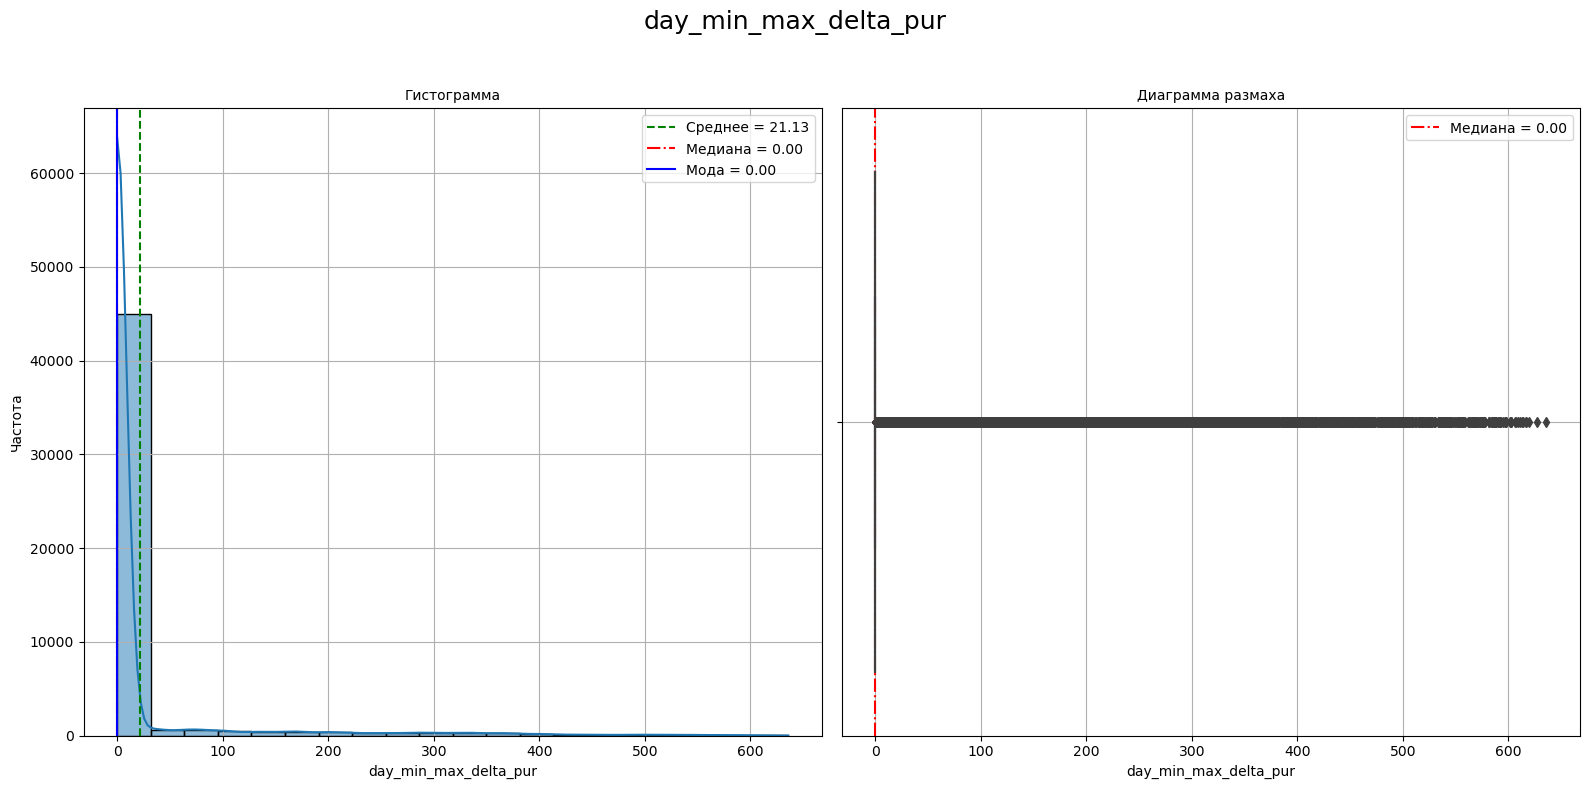

In [121]:
# Построим график количества
hist_and_box_with_stats(
     ds_aggr_purchases,   #df, 
     'day_min_max_delta_pur',       #column, 
     'day_min_max_delta_pur',       # title, 
     20,      #bins,
 )
 

In [122]:
display(ds_aggr_purchases.head(10))

,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,summer,autumn,first_category,last_category,day_min_max_delta_pur,pur_day_activity,last_activity_pur
client_id,,,,,,,,,,,,,,,
1515915625468060902,7,6993,999.000000,2022-05-27,2022-05-27,629,0,1,0,0,4,422,0,Short,Long
1515915625468061003,7,16235,2319.285645,2023-01-04,2023-01-04,407,1,0,0,0,4,615,0,Short,Long
1515915625468061099,1,299,299.000000,2022-05-17,2022-05-17,639,0,1,0,0,4,424,0,Short,Long
1515915625468061100,2,2098,1049.000000,2024-02-10,2024-02-10,5,1,0,0,0,4,5717,0,Short,Short
1515915625468061170,19,33601,1768.473633,2023-03-26,2023-06-17,243,0,1,1,0,4,420,83,Long,Long
1515915625468061514,1,999,999.000000,2022-07-30,2022-07-30,565,0,0,1,0,4,418,0,Short,Long
1515915625468061877,1,1499,1499.000000,2022-08-19,2022-08-19,545,0,0,1,0,5562,1829,0,Short,Long
1515915625468061975,1,299,299.000000,2022-07-27,2022-07-27,568,0,0,1,0,4,1848,0,Short,Long
1515915625468061994,8,1012,126.500000,2022-11-15,2022-12-14,428,1,0,0,1,6060,5847,29,Medium,Long


In [123]:
# Проверим данные на пустоты
emptyes_finder(ds_aggr_purchases)

Анализ пропущенных значений:
Колонка: quantity_count_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_sum
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_mean
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: start_date_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: end_date_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: day_to_0_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: winter
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: spring
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: summer
Пропущенных значений: 0
Процент пропусков: 0.00%
-------------------

,Column,Missing_Count,Missing_Percentage
0,quantity_count_pur,0,0.00%
1,price_sum,0,0.00%
2,price_mean,0,0.00%
3,start_date_pur,0,0.00%
4,end_date_pur,0,0.00%
5,day_to_0_pur,0,0.00%
6,winter,0,0.00%
7,spring,0,0.00%
8,summer,0,0.00%
9,autumn,0,0.00%


### Посмотрим на графики, что получилось

first_category
4       112578
5562     46511
2        27429
6060      7559
1999      5579
5963      1272
3           11
1            3
5            2
Name: count, dtype: int64

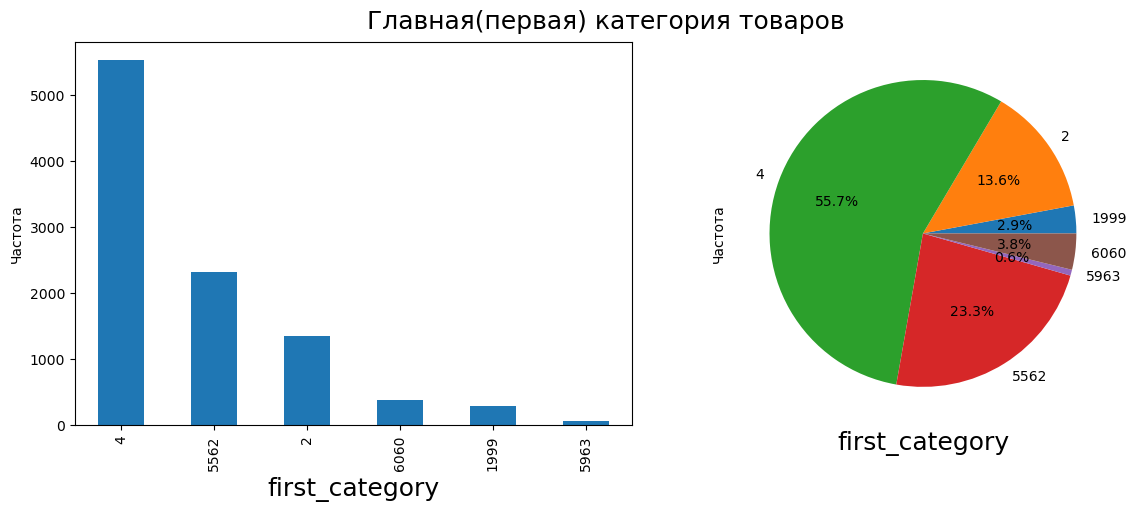

In [124]:
display(ds_a_purchases['first_category'].value_counts())
bar_and_pie(ds_a_purchases.sample(n=10000), 'first_category','Главная(первая) категория товаров')

Видим что больше половинов заказов содержали товар из 4й верхней категории.

/home/segius/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


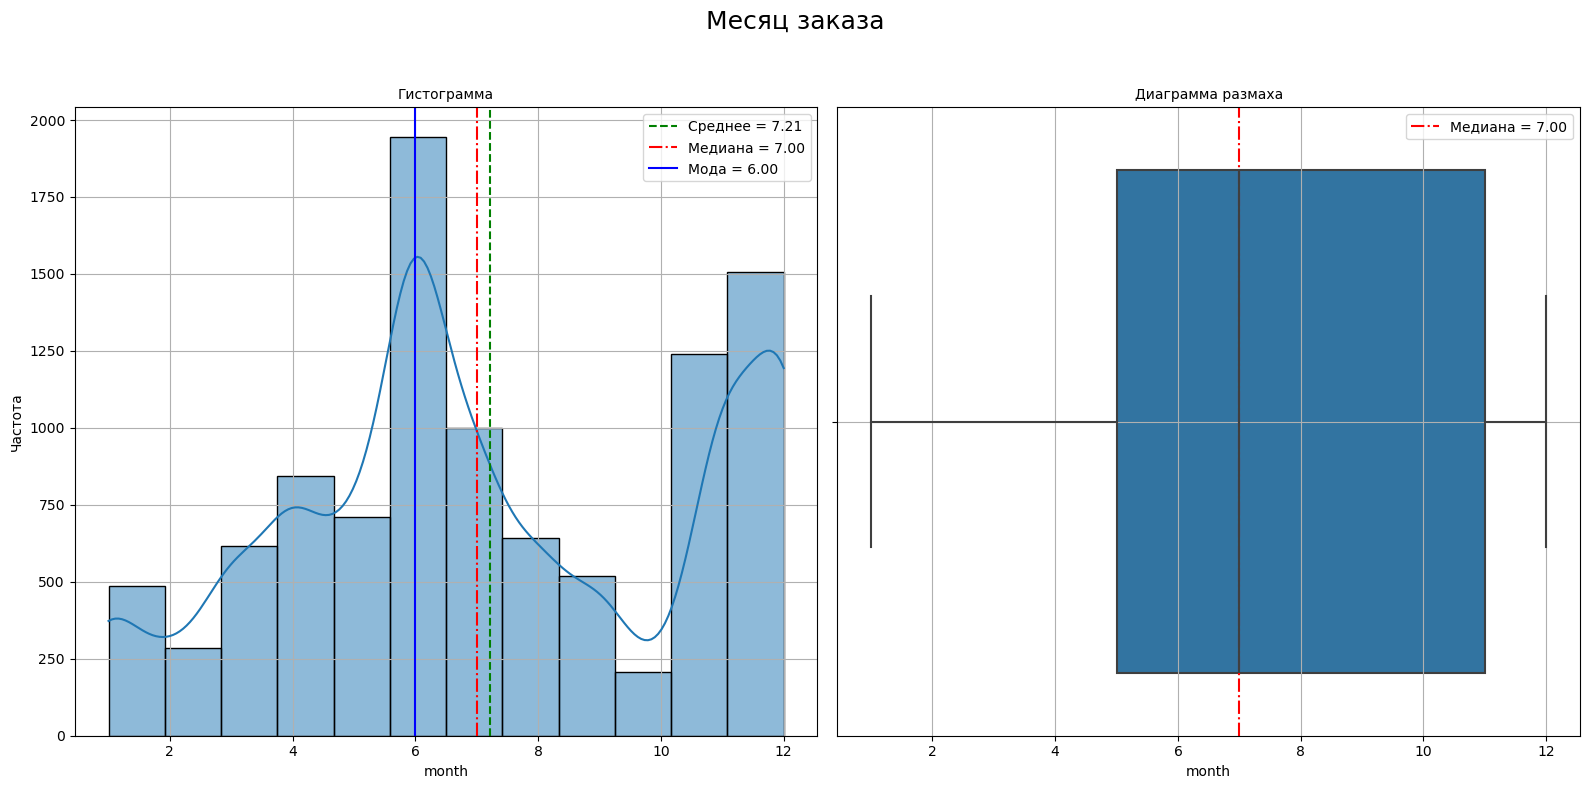

In [125]:
# Построим график количества
hist_and_box_with_stats(
     ds_a_purchases.sample(n=10000),   #df, 
     'month',       #column, 
     'Месяц заказа',       # title, 
     12,      #bins,
 )

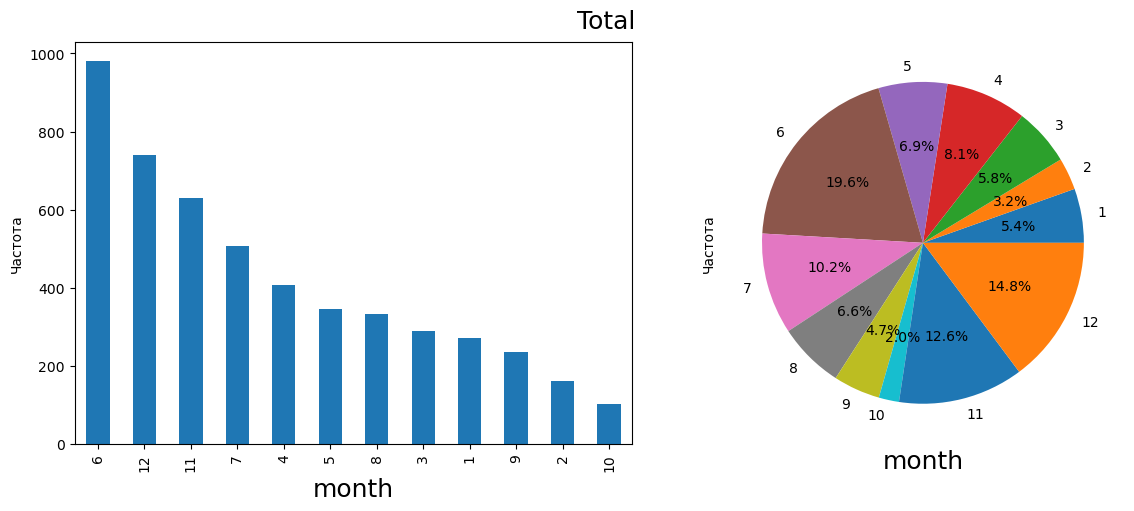

In [126]:
bar_and_pie(ds_a_purchases.sample(n=5000), 'month','Total')

Видно что пики заказов приходятся на июнь и ноябрь-декабрь. Похоже на серии рекламных акций, в середине года перед летним спадом из-за отпусков, и в декабре перед январьским спадом когда пользователи меньше тратят после новогодних праздников.

/home/segius/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


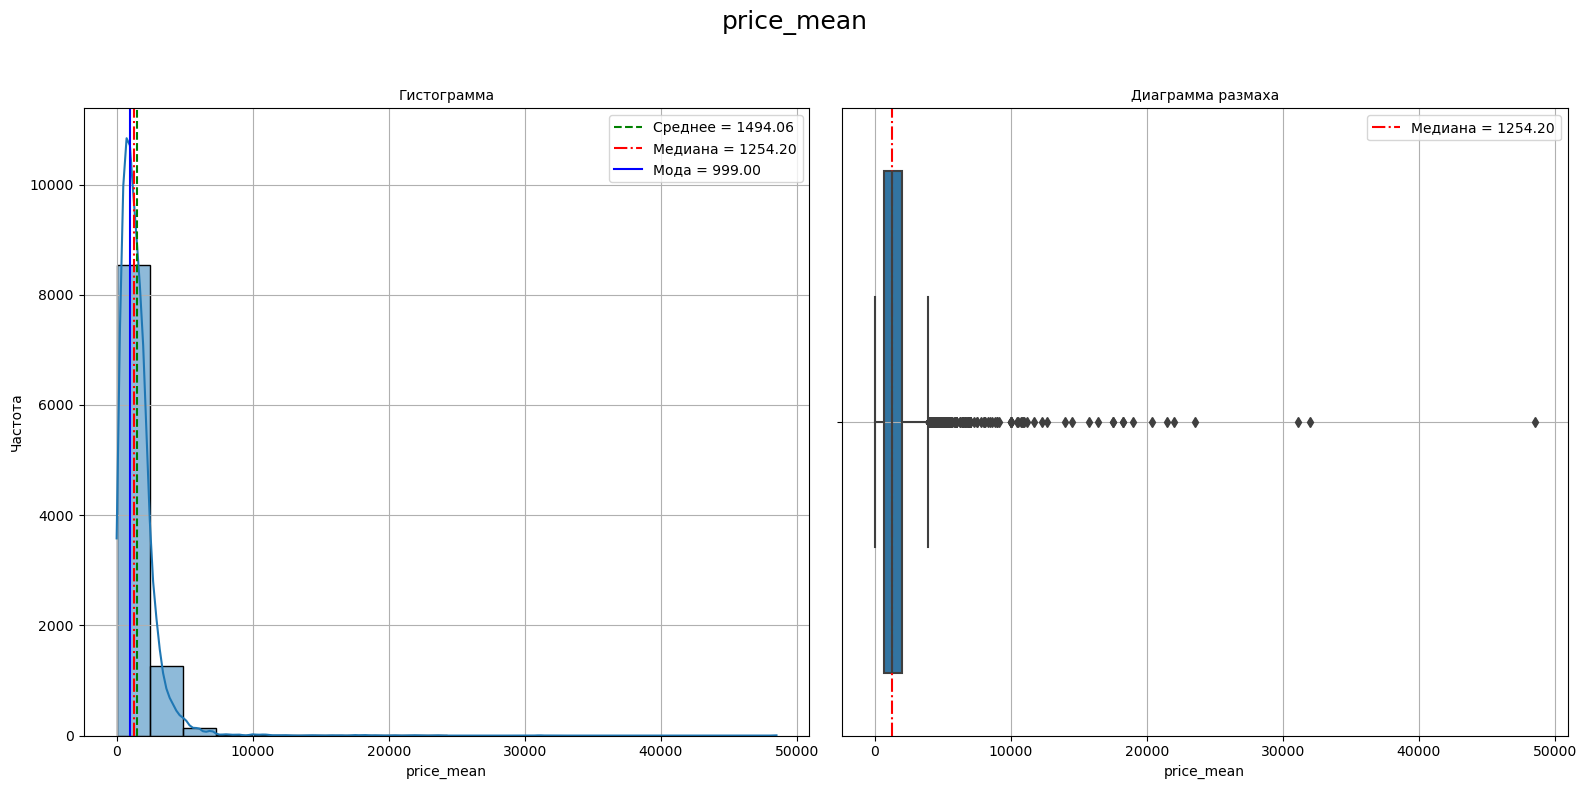

In [127]:
# Построим график количества
hist_and_box_with_stats(
     ds_aggr_purchases.sample(n=10000),   #df, 
     'price_mean',       #column, 
     'price_mean',       # title, 
     20,      #bins,
 )
 

/home/segius/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


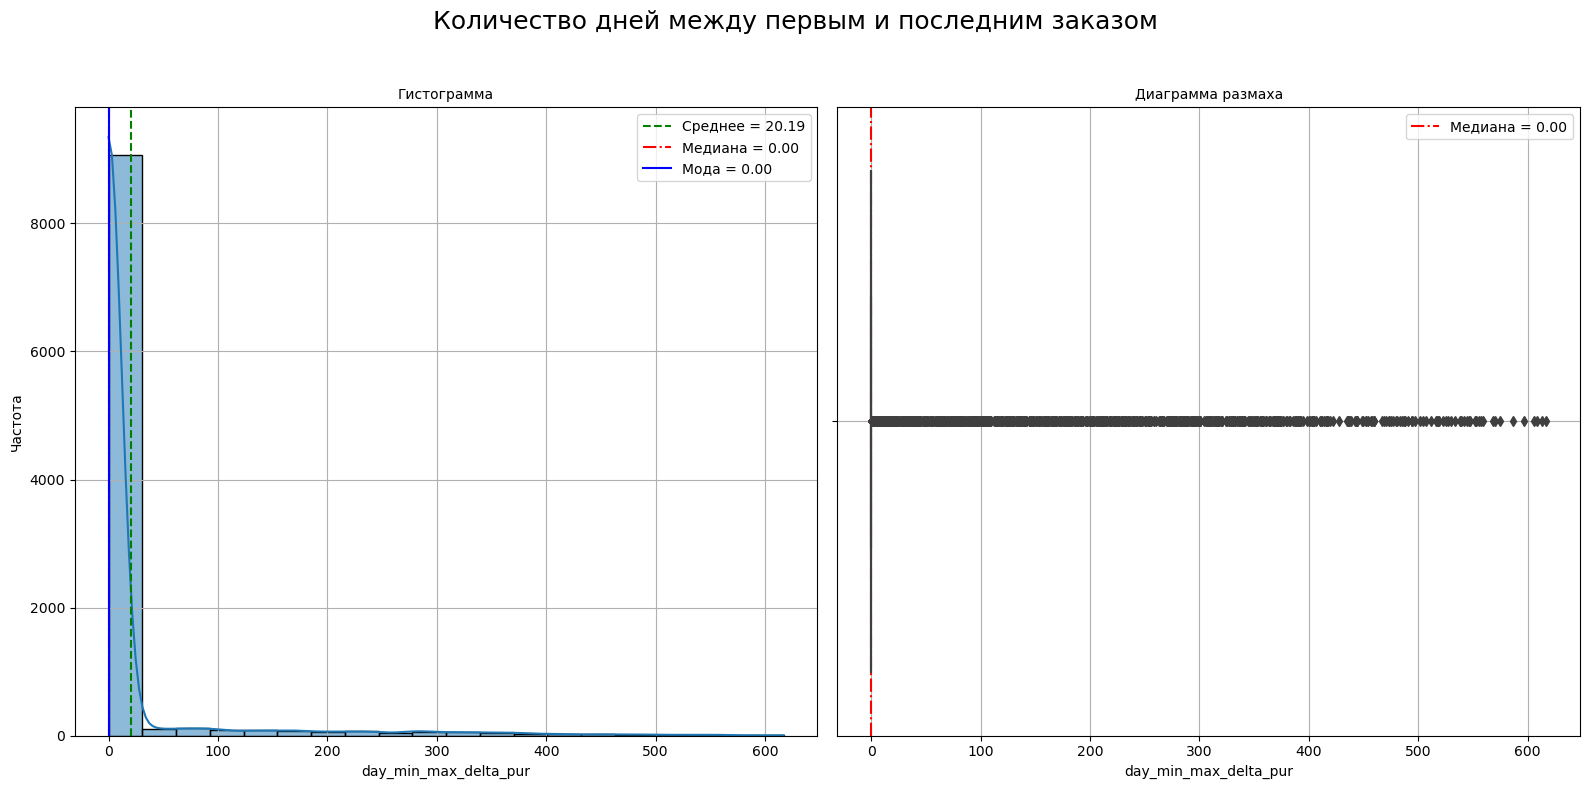

In [128]:
# Построим график количества
hist_and_box_with_stats(
     ds_aggr_purchases.sample(n=10000),   #df, 
     'day_min_max_delta_pur',       #column, 
     'Количество дней между первым и последним заказом',       # title, 
     20,      #bins,
 )

Ме

/home/segius/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


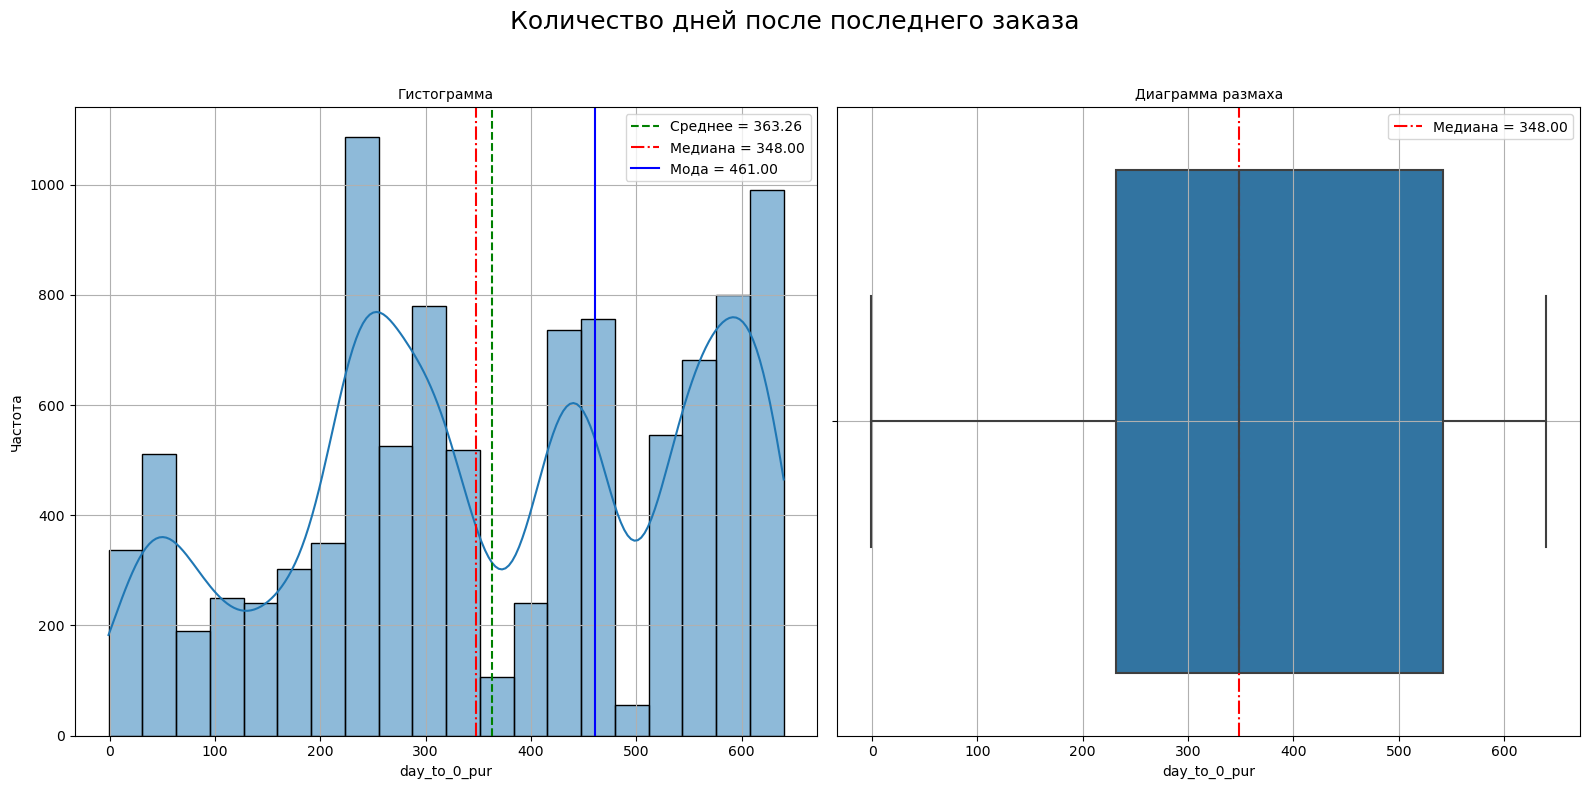

In [129]:
# Построим график количества
hist_and_box_with_stats(
     ds_aggr_purchases.sample(n=10000),   #df, 
     'day_to_0_pur',       #column, 
     'Количество дней после последнего заказа',       # title, 
     20,      #bins,
 )

Распределение не очень наглядное. Медиана = 0, значит Большая часть клиентов делали заказ за последний год.
Возможно имеет смысл удалить всех клиентов которые не делали заказы больше года ?  Если клиент не делал заказ больше года, вряд ли он вернётся снова просто так.

### Итог шага добавления данных:
* Создана аггрегирующие таблицы на основе ds_a_messages, группировка по client_id
* Создана аггрегирующие таблицы на основе ds_a_purchases, группировка по client_id
* Сделана разбивка статистики на периоды 1, 3, 6, 9, 12 , 12+ месяцев
* К агрегирующей таблице заказов добавлены признаки делались ли заказы зимой, весной, летом или осенью. Пытался оценить сезонность.
* Для каждого периода подсчитана статистика по количеству рекламных событий и количеству заказов.
* Добавлены бинарные признаки наличия активности в периодах.
* Добавлен признак "Количество дней между датой последней покупки и датой среза данных"
* Добавлен признак отписавшихся
* Добавлен признак заказывавших через приложение или рекламное оповещение
* Добавлены признакидля пользователей были ли рекламные компании через электронную почту или сотовую связь.

## Сделаем сводные таблицы

## Объеденим таблицы

In [130]:
#display('Количество уникальных client_id в ds_pivot_purchases', ds_pivot_purchases['client_id'].nunique() )
display('Количество уникальных client_id в ds_pivot_purchases', ds_pivot_purchases.shape)

'Количество уникальных client_id в ds_pivot_purchases'

(49849, 18)

In [131]:
#display('Количество уникальных client_id в ds_a_target_binary', ds_a_target_binary['client_id'].nunique() )
display('Количество уникальных client_id в ds_a_target_binary', ds_a_target_binary.shape )

'Количество уникальных client_id в ds_a_target_binary'

(49849, 2)

In [132]:
#display('Количество уникальных client_id в ds_pivot_messages', ds_pivot_messages['client_id'].nunique() )
display('Количество уникальных client_id в ds_pivot_messages', ds_pivot_messages.shape)

'Количество уникальных client_id в ds_pivot_messages'

(53329, 24)

В таблицах *_messages больше уникальных записей в поле "client_id", но мы отберём только те что присутствуют в целевом наборе ds_a_target_binary.
Объединим данные в общую таблицу. Соединять будем по полю client_id.

In [133]:
#
#ds_merged_short = pd.merge(ds_a_target_binary, ds_aggr_purchases, on='client_id', how='left')
ds_merged = pd.merge(ds_a_target_binary, ds_aggr_purchases, left_on='client_id', right_index = True,  how='left')
# Повторим для другой таблицы.
ds_merged = pd.merge(ds_merged, ds_aggr_messages, left_on='client_id', right_index = True, how='left')

In [134]:
emptyes_finder(ds_merged)

Анализ пропущенных значений:
Колонка: client_id
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: target
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: quantity_count_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_sum
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_mean
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: start_date_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: end_date_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: day_to_0_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: winter
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------

,Column,Missing_Count,Missing_Percentage
0,client_id,0,0.00%
1,target,0,0.00%
2,quantity_count_pur,0,0.00%
3,price_sum,0,0.00%
4,price_mean,0,0.00%
5,start_date_pur,0,0.00%
6,end_date_pur,0,0.00%
7,day_to_0_pur,0,0.00%
8,winter,0,0.00%
9,spring,0,0.00%


Появились пропуски.
Наверное эти client_id отсутствуют в одной из таблиц. Рассмотрим эту гипотезу подробнее.

In [135]:
display('Записи с пропущенными значениями', ds_merged.loc[ds_merged['campaign_count'].isna() ])

'Записи с пропущенными значениями'

,client_id,target,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,...,unsubscribe,purchase,open,click,bounce,day_to_0_mess,email_cnt,mobile_cnt,day_min_max_delta_mess,last_activity_mes
293,1515915625468081882,0,5,7924,1584.800049,2022-12-23,2022-12-23,419,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347,1515915625468087979,0,13,2527,194.384613,2022-06-04,2022-06-04,621,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,1515915625468093885,1,37,88432,2526.628662,2022-06-06,2023-05-23,268,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
564,1515915625468105189,0,7,8793,1256.142822,2023-09-28,2023-11-24,83,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,1515915625468122963,0,1,2399,2399.000000,2022-06-05,2022-06-05,620,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49843,1515915626010256069,0,2,3998,1999.000000,2024-02-14,2024-02-14,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49845,1515915626010266132,0,2,1818,909.000000,2024-02-14,2024-02-14,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49846,1515915626010439406,0,2,198,99.000000,2024-02-16,2024-02-16,-1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49847,1515915626010443527,0,1,1999,1999.000000,2024-02-16,2024-02-16,-1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Возьмём случайный client_id из записей с пустыми признаками.

In [136]:
display('ds_merged', ds_merged.loc[ds_merged['client_id'] ==  1515915625468081882])

display('ds_a_target_binary', ds_a_target_binary.loc[ds_a_target_binary['client_id'] ==  1515915625468081882])
display('ds_aggr_purchases', ds_aggr_purchases.loc[ds_aggr_purchases.index==  1515915625468081882])

display('ds_aggr_messages', ds_aggr_messages.loc[ds_aggr_messages.index==  1515915625468081882])


'ds_merged'

,client_id,target,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,...,unsubscribe,purchase,open,click,bounce,day_to_0_mess,email_cnt,mobile_cnt,day_min_max_delta_mess,last_activity_mes
293,1515915625468081882,0,5,7924,1584.800049,2022-12-23,2022-12-23,419,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'ds_a_target_binary'

,client_id,target
293,1515915625468081882,0


'ds_aggr_purchases'

,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,summer,autumn,first_category,last_category,day_min_max_delta_pur,pur_day_activity,last_activity_pur
client_id,,,,,,,,,,,,,,,
1515915625468081882,5,7924,1584.800049,2022-12-23,2022-12-23,419,1,0,0,0,1999,1999,0,Short,Long


'ds_aggr_messages'

,campaign_count,start_date_mess,end_date_mess,unsubscribe,purchase,open,click,bounce,day_to_0_mess,email_cnt,mobile_cnt,day_min_max_delta_mess,last_activity_mes
client_id,,,,,,,,,,,,,


Запись отсутствует в ds_aggr_messages. Пропуски заполним чуть ниже.

Объеденим ещё несколько сагрегированных таблиц. Так же склеиваем оп признаку client_id.

In [137]:

ds_merged = pd.merge(ds_merged, ds_pivot_purchases, left_on='client_id', right_index = True, how='left')
ds_merged = pd.merge(ds_merged, ds_pivot_messages, left_on='client_id', right_index = True, how='left')


In [138]:
display(ds_merged.head())
#display(ds_merged.head())
display(ds_merged.info())
#display(ds_merged.info())

,client_id,target,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,...,cat_event_6_months,cat_event_9_months,cat_event_12_months,cat_event_12+_months,cat_bulk_campaign_id_1_month,cat_bulk_campaign_id_3_months,cat_bulk_campaign_id_6_months,cat_bulk_campaign_id_9_months,cat_bulk_campaign_id_12_months,cat_bulk_campaign_id_12+_months
0,1515915625468060902,0,7,6993,999.000000,2022-05-27,2022-05-27,629,0,1,...,1,1,1,1,1,1,1,1,1,1
1,1515915625468061003,1,7,16235,2319.285645,2023-01-04,2023-01-04,407,1,0,...,1,1,1,1,1,1,1,1,1,1
2,1515915625468061099,0,1,299,299.000000,2022-05-17,2022-05-17,639,0,1,...,1,1,1,1,1,1,1,1,1,1
3,1515915625468061100,0,2,2098,1049.000000,2024-02-10,2024-02-10,5,1,0,...,1,1,0,1,1,1,1,1,0,1
4,1515915625468061170,0,19,33601,1768.473633,2023-03-26,2023-06-17,243,0,1,...,1,1,1,1,1,1,1,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 72 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   client_id                        49849 non-null  int64         
 1   target                           49849 non-null  int8          
 2   quantity_count_pur               49849 non-null  int16         
 3   price_sum                        49849 non-null  int32         
 4   price_mean                       49849 non-null  float32       
 5   start_date_pur                   49849 non-null  datetime64[ns]
 6   end_date_pur                     49849 non-null  datetime64[ns]
 7   day_to_0_pur                     49849 non-null  int16         
 8   winter                           49849 non-null  category      
 9   spring                           49849 non-null  category      
 10  summer                           49849 non-null  category 

None

Добавим ещё одно поле : количество заказов делёное на количество рекламных акций.

In [139]:
ds_merged['purchases_per_bulk'] = ds_merged['quantity_count_pur'] / ds_merged['campaign_count']


In [140]:
display(ds_merged.head())
display(ds_merged.shape)

,client_id,target,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,...,cat_event_9_months,cat_event_12_months,cat_event_12+_months,cat_bulk_campaign_id_1_month,cat_bulk_campaign_id_3_months,cat_bulk_campaign_id_6_months,cat_bulk_campaign_id_9_months,cat_bulk_campaign_id_12_months,cat_bulk_campaign_id_12+_months,purchases_per_bulk
0,1515915625468060902,0,7,6993,999.000000,2022-05-27,2022-05-27,629,0,1,...,1,1,1,1,1,1,1,1,1,0.055118
1,1515915625468061003,1,7,16235,2319.285645,2023-01-04,2023-01-04,407,1,0,...,1,1,1,1,1,1,1,1,1,0.045455
2,1515915625468061099,0,1,299,299.000000,2022-05-17,2022-05-17,639,0,1,...,1,1,1,1,1,1,1,1,1,0.004651
3,1515915625468061100,0,2,2098,1049.000000,2024-02-10,2024-02-10,5,1,0,...,1,0,1,1,1,1,1,0,1,0.007547
4,1515915625468061170,0,19,33601,1768.473633,2023-03-26,2023-06-17,243,0,1,...,1,1,1,1,1,1,1,1,1,0.079167


(49849, 73)

In [141]:
emptyes_finder(ds_merged)

Анализ пропущенных значений:
Колонка: client_id
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: target
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: quantity_count_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_sum
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_mean
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: start_date_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: end_date_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: day_to_0_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: winter
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------

,Column,Missing_Count,Missing_Percentage
0,client_id,0,0.00%
1,target,0,0.00%
2,quantity_count_pur,0,0.00%
3,price_sum,0,0.00%
4,price_mean,0,0.00%
...,...,...,...
68,cat_bulk_campaign_id_6_months,7867,15.78%
69,cat_bulk_campaign_id_9_months,7867,15.78%
70,cat_bulk_campaign_id_12_months,7867,15.78%
71,cat_bulk_campaign_id_12+_months,7867,15.78%


In [142]:
#df[column].isna().sum() + (df[column] == "").sum()
display('Записи с пропущенными значениями', ds_merged.loc[ds_merged['campaign_count'].isna() ])

'Записи с пропущенными значениями'

,client_id,target,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,...,cat_event_9_months,cat_event_12_months,cat_event_12+_months,cat_bulk_campaign_id_1_month,cat_bulk_campaign_id_3_months,cat_bulk_campaign_id_6_months,cat_bulk_campaign_id_9_months,cat_bulk_campaign_id_12_months,cat_bulk_campaign_id_12+_months,purchases_per_bulk
293,1515915625468081882,0,5,7924,1584.800049,2022-12-23,2022-12-23,419,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347,1515915625468087979,0,13,2527,194.384613,2022-06-04,2022-06-04,621,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,1515915625468093885,1,37,88432,2526.628662,2022-06-06,2023-05-23,268,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
564,1515915625468105189,0,7,8793,1256.142822,2023-09-28,2023-11-24,83,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,1515915625468122963,0,1,2399,2399.000000,2022-06-05,2022-06-05,620,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49843,1515915626010256069,0,2,3998,1999.000000,2024-02-14,2024-02-14,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49845,1515915626010266132,0,2,1818,909.000000,2024-02-14,2024-02-14,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49846,1515915626010439406,0,2,198,99.000000,2024-02-16,2024-02-16,-1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49847,1515915626010443527,0,1,1999,1999.000000,2024-02-16,2024-02-16,-1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
display(ds_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 73 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   client_id                        49849 non-null  int64         
 1   target                           49849 non-null  int8          
 2   quantity_count_pur               49849 non-null  int16         
 3   price_sum                        49849 non-null  int32         
 4   price_mean                       49849 non-null  float32       
 5   start_date_pur                   49849 non-null  datetime64[ns]
 6   end_date_pur                     49849 non-null  datetime64[ns]
 7   day_to_0_pur                     49849 non-null  int16         
 8   winter                           49849 non-null  category      
 9   spring                           49849 non-null  category      
 10  summer                           49849 non-null  category 

None

У этих пользователей отсутствуют записи о рекламных компаниях. Присвоим им значение "-1" во всех пропущенных полях.

In [144]:
display( ds_merged['unsubscribe'].value_counts())

unsubscribe
0    39953
1     2029
Name: count, dtype: int64

Заполним пропуски в событиях знаком "-1". Он будет проставлен у тех событий которые не соответствуют фильтруемым.

In [145]:
#  Добавляем категорию
ds_merged['unsubscribe'] = ds_merged['unsubscribe'].cat.add_categories([-1])
ds_merged['unsubscribe'] = ds_merged['unsubscribe'].fillna(-1)

ds_merged['purchase'] = ds_merged['purchase'].cat.add_categories([-1])
ds_merged['purchase'] = ds_merged['purchase'].fillna(-1)


ds_merged['open'] = ds_merged['open'].cat.add_categories([-1])
ds_merged['open'] = ds_merged['open'].fillna(-1)

ds_merged['click'] = ds_merged['click'].cat.add_categories([-1])
ds_merged['click'] = ds_merged['click'].fillna(-1)

ds_merged['bounce'] = ds_merged['bounce'].cat.add_categories([-1])
ds_merged['bounce'] = ds_merged['bounce'].fillna(-1)


In [146]:
# 1. Заполняем пропуски в числовых столбцах
num_cols = ds_merged.select_dtypes(include=[np.number]).columns
ds_merged[num_cols] = ds_merged[num_cols].fillna(0)

In [147]:
display( ds_merged['last_activity_mes'].value_counts())

last_activity_mes
Short     36836
Long       3615
Medium     1531
Name: count, dtype: int64

In [148]:

ds_merged = ds_merged.fillna({
    'last_activity_mes': 'Short',        # заполним пропуски самым частым значением.
#    
    'cat_event_1_month': 0, 
    'cat_event_3_months': 0,      
    'cat_event_6_months': 0,
    'cat_event_9_months': 0,
    'cat_event_12_months': 0,      
    'cat_event_12+_months': 0,
    'cat_bulk_campaign_id_1_month': 0,
    'cat_bulk_campaign_id_3_months': 0,      
    'cat_bulk_campaign_id_6_months': 0,
    'cat_bulk_campaign_id_9_months': 0,
    'cat_bulk_campaign_id_12_months': 0,
    'cat_bulk_campaign_id_12+_months': 0,    
    
})

In [149]:
display(ds_merged)
#display(dummies_1st)


,client_id,target,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,...,cat_event_9_months,cat_event_12_months,cat_event_12+_months,cat_bulk_campaign_id_1_month,cat_bulk_campaign_id_3_months,cat_bulk_campaign_id_6_months,cat_bulk_campaign_id_9_months,cat_bulk_campaign_id_12_months,cat_bulk_campaign_id_12+_months,purchases_per_bulk
0,1515915625468060902,0,7,6993,999.000000,2022-05-27,2022-05-27,629,0,1,...,1,1,1,1,1,1,1,1,1,0.055118
1,1515915625468061003,1,7,16235,2319.285645,2023-01-04,2023-01-04,407,1,0,...,1,1,1,1,1,1,1,1,1,0.045455
2,1515915625468061099,0,1,299,299.000000,2022-05-17,2022-05-17,639,0,1,...,1,1,1,1,1,1,1,1,1,0.004651
3,1515915625468061100,0,2,2098,1049.000000,2024-02-10,2024-02-10,5,1,0,...,1,0,1,1,1,1,1,0,1,0.007547
4,1515915625468061170,0,19,33601,1768.473633,2023-03-26,2023-06-17,243,0,1,...,1,1,1,1,1,1,1,1,1,0.079167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,6,8994,1499.000000,2024-02-16,2024-02-16,-1,1,0,...,0,0,0,1,0,0,0,0,0,6.000000
49845,1515915626010266132,0,2,1818,909.000000,2024-02-14,2024-02-14,1,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
49846,1515915626010439406,0,2,198,99.000000,2024-02-16,2024-02-16,-1,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
49847,1515915626010443527,0,1,1999,1999.000000,2024-02-16,2024-02-16,-1,1,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [150]:
display(ds_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 73 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   client_id                        49849 non-null  int64         
 1   target                           49849 non-null  int8          
 2   quantity_count_pur               49849 non-null  int16         
 3   price_sum                        49849 non-null  int32         
 4   price_mean                       49849 non-null  float32       
 5   start_date_pur                   49849 non-null  datetime64[ns]
 6   end_date_pur                     49849 non-null  datetime64[ns]
 7   day_to_0_pur                     49849 non-null  int16         
 8   winter                           49849 non-null  category      
 9   spring                           49849 non-null  category      
 10  summer                           49849 non-null  category 

None

In [151]:
optimize_numeric_columns(ds_merged)

,client_id,target,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,...,cat_event_9_months,cat_event_12_months,cat_event_12+_months,cat_bulk_campaign_id_1_month,cat_bulk_campaign_id_3_months,cat_bulk_campaign_id_6_months,cat_bulk_campaign_id_9_months,cat_bulk_campaign_id_12_months,cat_bulk_campaign_id_12+_months,purchases_per_bulk
0,1515915625468060902,0,7,6993,999.000000,2022-05-27,2022-05-27,629,0,1,...,1,1,1,1,1,1,1,1,1,0.055118
1,1515915625468061003,1,7,16235,2319.285645,2023-01-04,2023-01-04,407,1,0,...,1,1,1,1,1,1,1,1,1,0.045455
2,1515915625468061099,0,1,299,299.000000,2022-05-17,2022-05-17,639,0,1,...,1,1,1,1,1,1,1,1,1,0.004651
3,1515915625468061100,0,2,2098,1049.000000,2024-02-10,2024-02-10,5,1,0,...,1,0,1,1,1,1,1,0,1,0.007547
4,1515915625468061170,0,19,33601,1768.473633,2023-03-26,2023-06-17,243,0,1,...,1,1,1,1,1,1,1,1,1,0.079167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,6,8994,1499.000000,2024-02-16,2024-02-16,-1,1,0,...,0,0,0,1,0,0,0,0,0,6.000000
49845,1515915626010266132,0,2,1818,909.000000,2024-02-14,2024-02-14,1,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
49846,1515915626010439406,0,2,198,99.000000,2024-02-16,2024-02-16,-1,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
49847,1515915626010443527,0,1,1999,1999.000000,2024-02-16,2024-02-16,-1,1,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [152]:
display(ds_merged.head(10))
display(ds_merged.info())

,client_id,target,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,winter,spring,...,cat_event_9_months,cat_event_12_months,cat_event_12+_months,cat_bulk_campaign_id_1_month,cat_bulk_campaign_id_3_months,cat_bulk_campaign_id_6_months,cat_bulk_campaign_id_9_months,cat_bulk_campaign_id_12_months,cat_bulk_campaign_id_12+_months,purchases_per_bulk
0,1515915625468060902,0,7,6993,999.000000,2022-05-27,2022-05-27,629,0,1,...,1,1,1,1,1,1,1,1,1,0.055118
1,1515915625468061003,1,7,16235,2319.285645,2023-01-04,2023-01-04,407,1,0,...,1,1,1,1,1,1,1,1,1,0.045455
2,1515915625468061099,0,1,299,299.000000,2022-05-17,2022-05-17,639,0,1,...,1,1,1,1,1,1,1,1,1,0.004651
3,1515915625468061100,0,2,2098,1049.000000,2024-02-10,2024-02-10,5,1,0,...,1,0,1,1,1,1,1,0,1,0.007547
4,1515915625468061170,0,19,33601,1768.473633,2023-03-26,2023-06-17,243,0,1,...,1,1,1,1,1,1,1,1,1,0.079167
5,1515915625468061514,0,1,999,999.000000,2022-07-30,2022-07-30,565,0,0,...,1,1,1,1,1,1,1,1,1,0.006667
6,1515915625468061877,0,1,1499,1499.000000,2022-08-19,2022-08-19,545,0,0,...,0,0,1,1,1,1,0,0,1,0.005882
7,1515915625468061975,0,1,299,299.000000,2022-07-27,2022-07-27,568,0,0,...,1,1,1,1,1,1,1,1,1,0.006494
8,1515915625468061994,0,8,1012,126.500000,2022-11-15,2022-12-14,428,1,0,...,1,1,1,1,1,1,1,1,1,0.023599
9,1515915625468062158,0,4,6096,1524.000000,2022-05-23,2023-04-28,293,0,1,...,1,1,1,1,1,1,1,1,1,0.035398


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 73 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   client_id                        49849 non-null  int64         
 1   target                           49849 non-null  int8          
 2   quantity_count_pur               49849 non-null  int16         
 3   price_sum                        49849 non-null  int32         
 4   price_mean                       49849 non-null  float32       
 5   start_date_pur                   49849 non-null  datetime64[ns]
 6   end_date_pur                     49849 non-null  datetime64[ns]
 7   day_to_0_pur                     49849 non-null  int16         
 8   winter                           49849 non-null  category      
 9   spring                           49849 non-null  category      
 10  summer                           49849 non-null  category 

None

In [153]:
emptyes_finder(ds_merged)

Анализ пропущенных значений:
Колонка: client_id
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: target
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: quantity_count_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_sum
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_mean
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: start_date_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: end_date_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: day_to_0_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: winter
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------

,Column,Missing_Count,Missing_Percentage
0,client_id,0,0.00%
1,target,0,0.00%
2,quantity_count_pur,0,0.00%
3,price_sum,0,0.00%
4,price_mean,0,0.00%
...,...,...,...
68,cat_bulk_campaign_id_6_months,0,0.00%
69,cat_bulk_campaign_id_9_months,0,0.00%
70,cat_bulk_campaign_id_12_months,0,0.00%
71,cat_bulk_campaign_id_12+_months,0,0.00%


###  Посмотрим новые данные

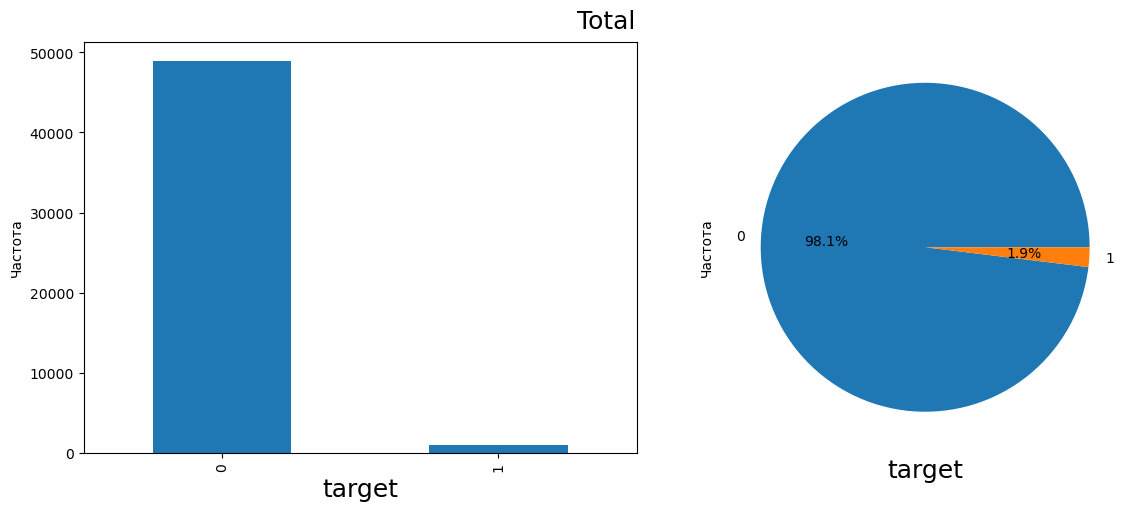

In [154]:
bar_and_pie(ds_merged, 'target','Total')

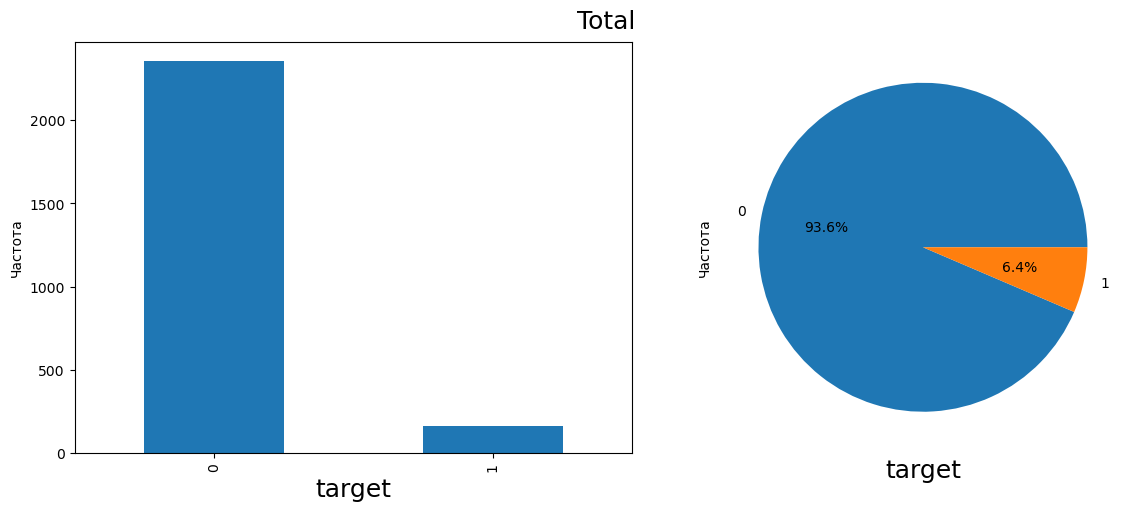

In [155]:
bar_and_pie(ds_merged.loc[ds_merged['cat_quantity_1_month'] == 1], 'target','Total')

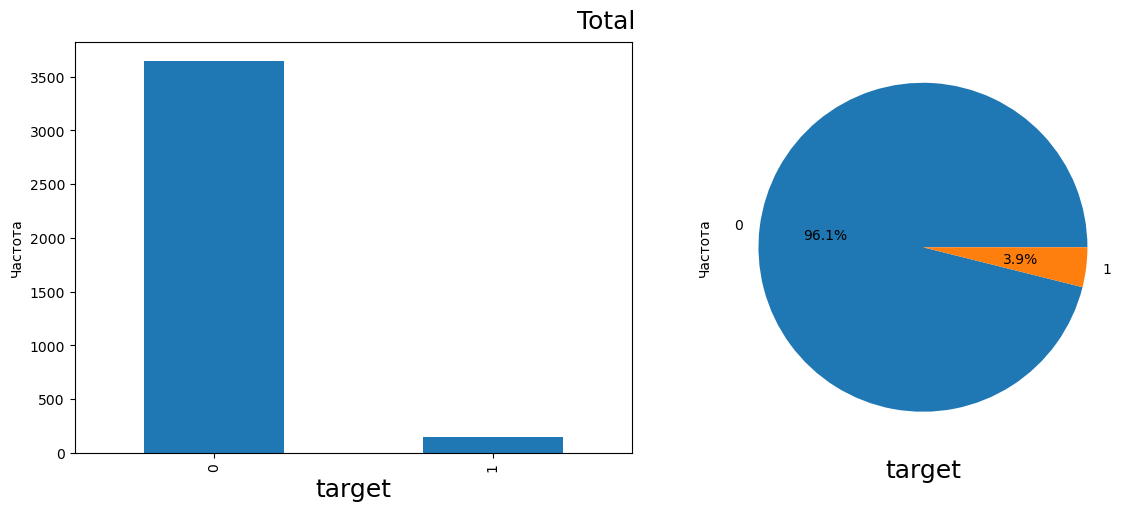

In [156]:
bar_and_pie(ds_merged.loc[ds_merged['cat_quantity_3_months'] == 1], 'target','Total')

* Если взять всех покупателей, то те кто купят в следующие 90 дней составляют 1.9%.
* Если взять тех кто покупал за последний месяц, то среди них те кто вернутся в течении 90 дней составляют уже 6.4 %, что в 3.4 раза больше.

In [157]:
display(ds_merged.describe())

,client_id,target,quantity_count_pur,price_sum,price_mean,start_date_pur,end_date_pur,day_to_0_pur,day_min_max_delta_pur,campaign_count,...,bulk_campaign_id_3_months,bulk_campaign_id_6_months,bulk_campaign_id_9_months,event_12+_months,event_12_months,event_1_month,event_3_months,event_6_months,event_9_months,purchases_per_bulk
count,4.984900e+04,49849.000000,49849.000000,49849.000000,49849.000000,49849,49849,49849.000000,49849.000000,49849.000000,...,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000
mean,1.515916e+18,0.019278,4.082710,4840.520632,1483.415283,2023-01-28 22:28:08.314710272,2023-02-19 01:38:30.329193984,360.931593,21.132199,156.885529,...,36.528015,39.575417,27.877972,68.621620,20.169453,26.909386,36.528015,39.575417,27.877972,0.050239
min,1.515916e+18,0.000000,1.000000,1.000000,1.000000,2022-05-16 00:00:00,2022-05-16 00:00:00,-1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,0.000000,1.000000,1499.000000,699.000000,2022-08-03 00:00:00,2022-08-23 00:00:00,232.000000,0.000000,58.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004808
50%,1.515916e+18,0.000000,2.000000,2929.000000,1249.000000,2022-12-26 00:00:00,2023-03-05 00:00:00,347.000000,0.000000,150.000000,...,28.000000,32.000000,24.000000,67.000000,18.000000,22.000000,28.000000,32.000000,24.000000,0.011905
75%,1.515916e+18,0.000000,5.000000,5677.000000,1999.000000,2023-06-14 00:00:00,2023-06-28 00:00:00,541.000000,0.000000,240.000000,...,57.000000,58.000000,41.000000,102.000000,31.000000,42.000000,57.000000,58.000000,41.000000,0.029412
max,1.515916e+18,1.000000,355.000000,540408.000000,53499.000000,2024-02-16 00:00:00,2024-02-16 00:00:00,640.000000,636.000000,2465.000000,...,691.000000,922.000000,703.000000,1169.000000,442.000000,447.000000,691.000000,922.000000,703.000000,25.000000
std,1.487947e+08,0.137503,5.562927,7312.865458,1388.162231,NaN,NaN,185.301691,76.842637,116.785484,...,34.790043,37.974476,27.286018,61.453789,19.985991,25.848866,34.790043,37.974476,27.286018,0.327552


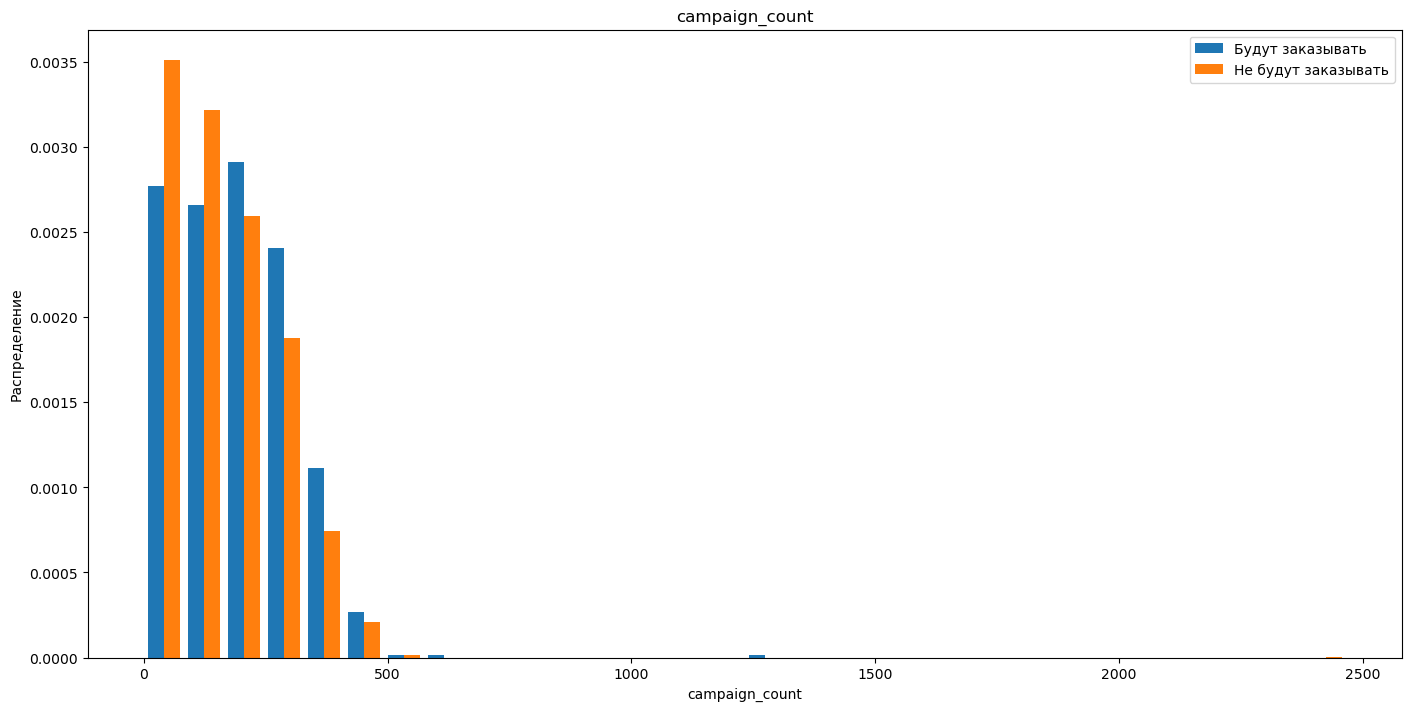

In [158]:
hist_2_sets_density(ds_merged,      #                         # Набор данных
            'campaign_count',   #  column_for_paining     # По какому признаку строим график
            'target',            #  column_for_filtering   # По какому признаку разделяем по цветам
            1,                #  filter_1               # Условие отбора для первого нобора
            0,                 #  filter_2               # Условие отбора для второго набора
            'Будут заказывать',         #  set1_label             # Название первого набора
            'Не будут заказывать',           #  set2_label             # Название второго набора
           ) 

Если человек получит больше 200 рекламных сообщений, это повышает вероятность повторного заказа. Надеюсь что все предложения вышлют не за один день.

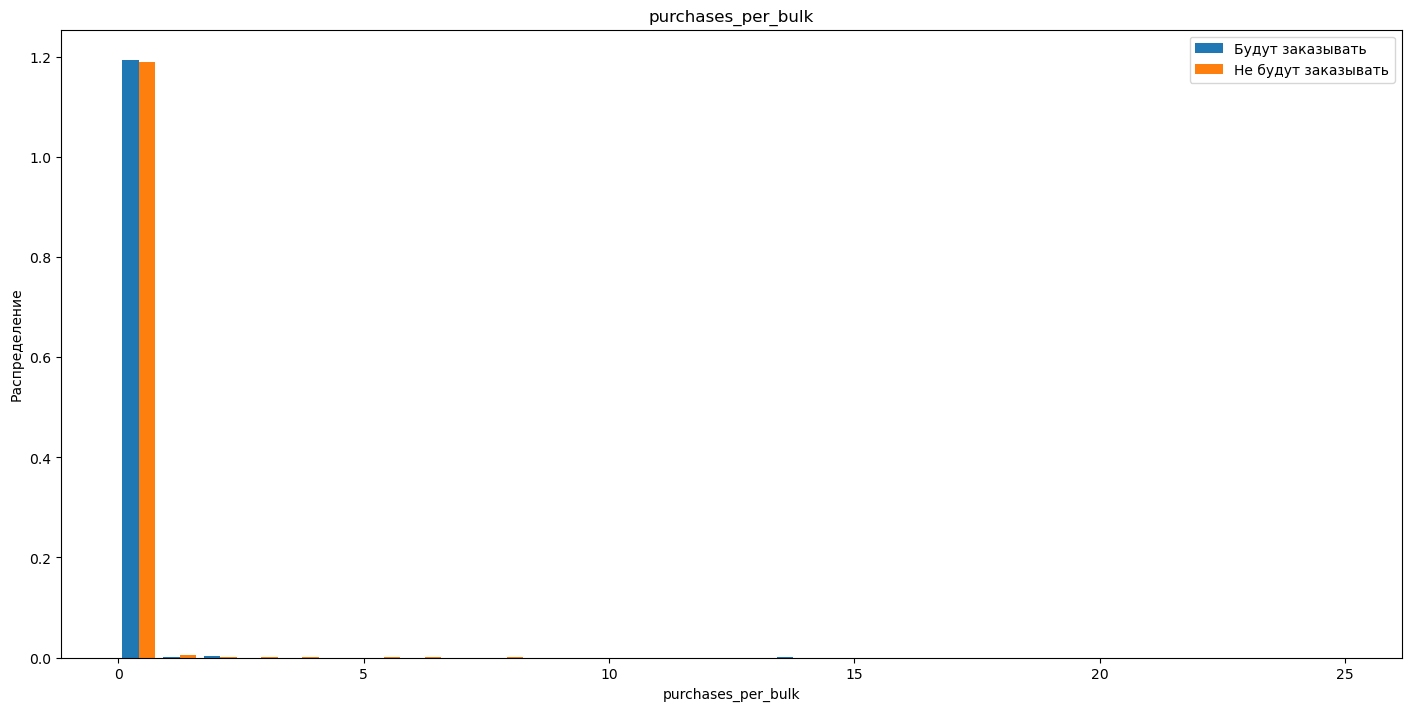

In [159]:
hist_2_sets_density(ds_merged,      #                         # Набор данных
            'purchases_per_bulk',   #  column_for_paining     # По какому признаку строим график
            'target',            #  column_for_filtering   # По какому признаку разделяем по цветам
            1,                #  filter_1               # Условие отбора для первого нобора
            0,                 #  filter_2               # Условие отбора для второго набора
            'Будут заказывать',         #  set1_label             # Название первого набора
            'Не будут заказывать',           #  set2_label             # Название второго набора
           ) 

Никакой разницы не выявлено.

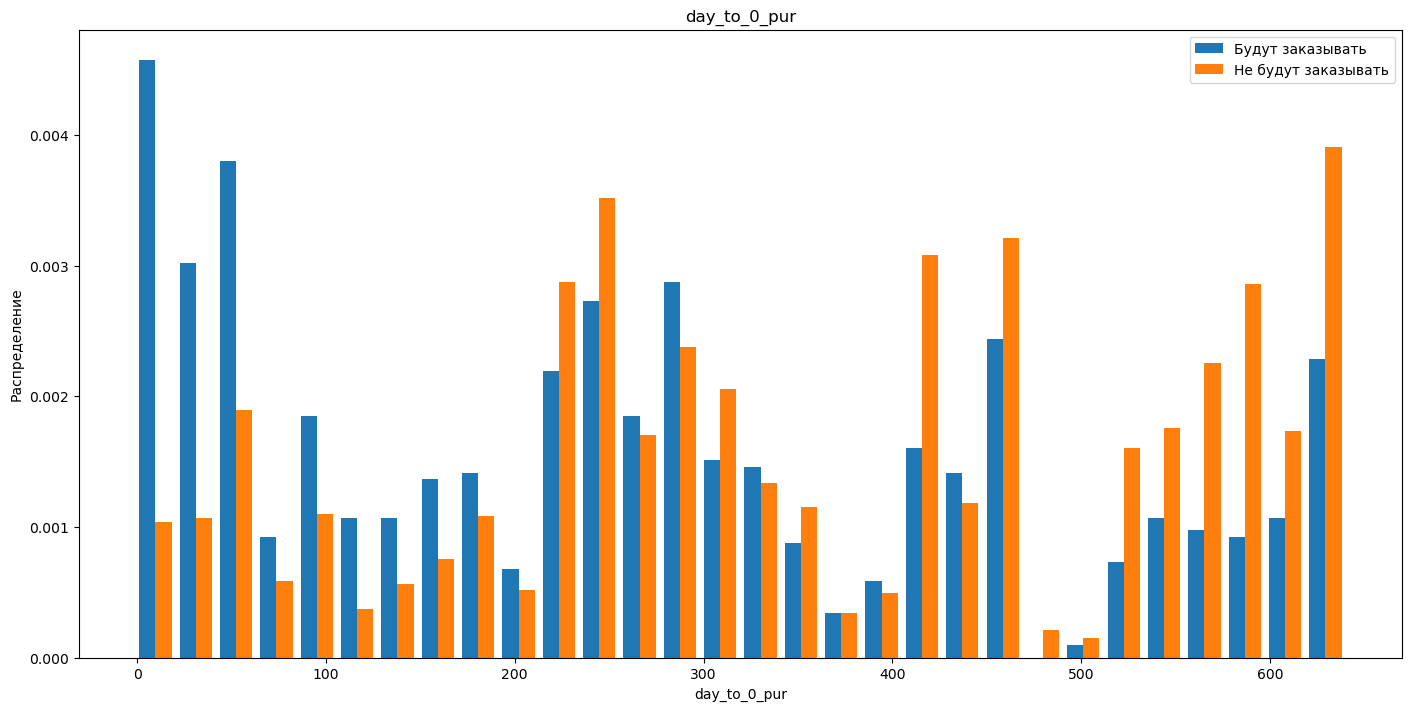

In [160]:
hist_2_sets_density(ds_merged,      #                         # Набор данных
            'day_to_0_pur',   #  column_for_paining     # По какому признаку строим график
            'target',            #  column_for_filtering   # По какому признаку разделяем по цветам
            1,                #  filter_1               # Условие отбора для первого нобора
            0,                 #  filter_2               # Условие отбора для второго набора
            'Будут заказывать',         #  set1_label             # Название первого набора
            'Не будут заказывать',           #  set2_label             # Название второго набора
           ) 

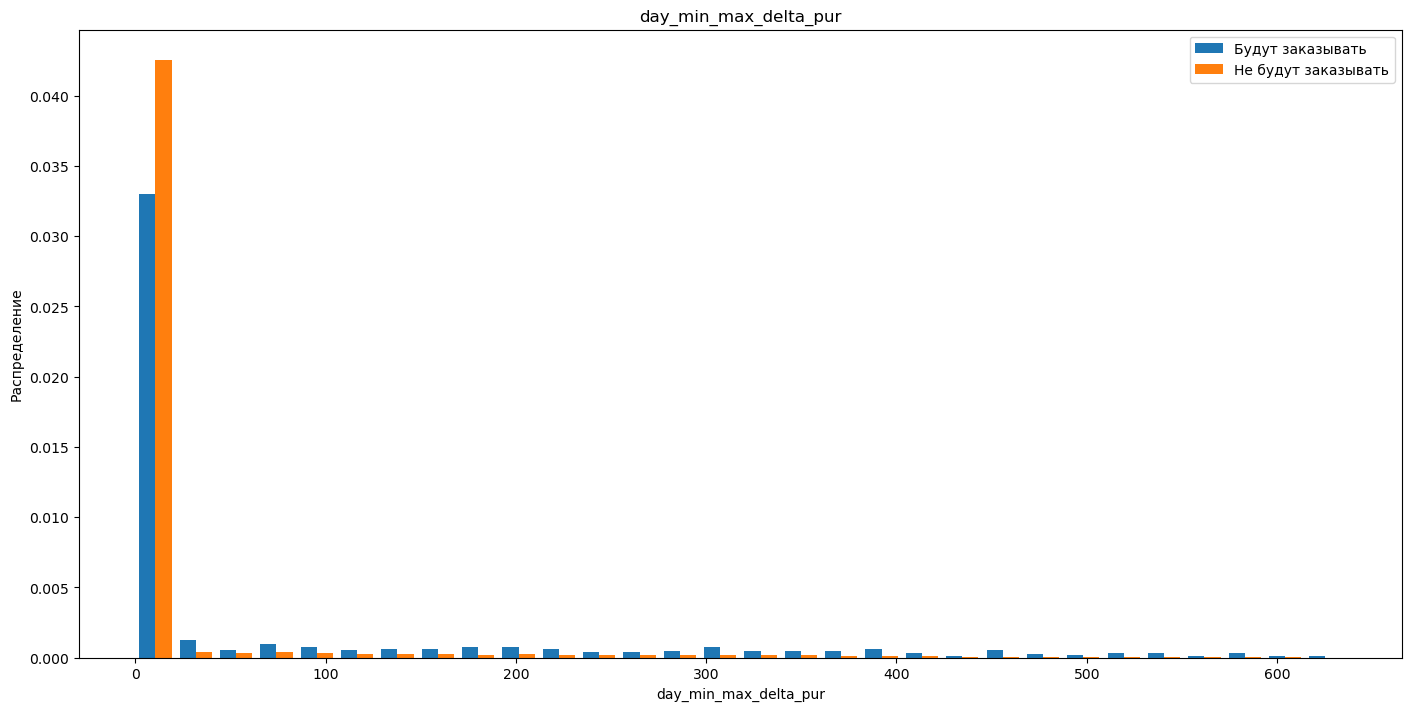

In [161]:
hist_2_sets_density(ds_merged,      #                         # Набор данных
            'day_min_max_delta_pur',   #  column_for_paining     # По какому признаку строим график
            'target',            #  column_for_filtering   # По какому признаку разделяем по цветам
            1,                #  filter_1               # Условие отбора для первого нобора
            0,                 #  filter_2               # Условие отбора для второго набора
            'Будут заказывать',         #  set1_label             # Название первого набора
            'Не будут заказывать',           #  set2_label             # Название второго набора
           ) 

Те кто слела все свои заказы за один день, скорее не будут заказывать больше. Они не готовы к повторным заказам.

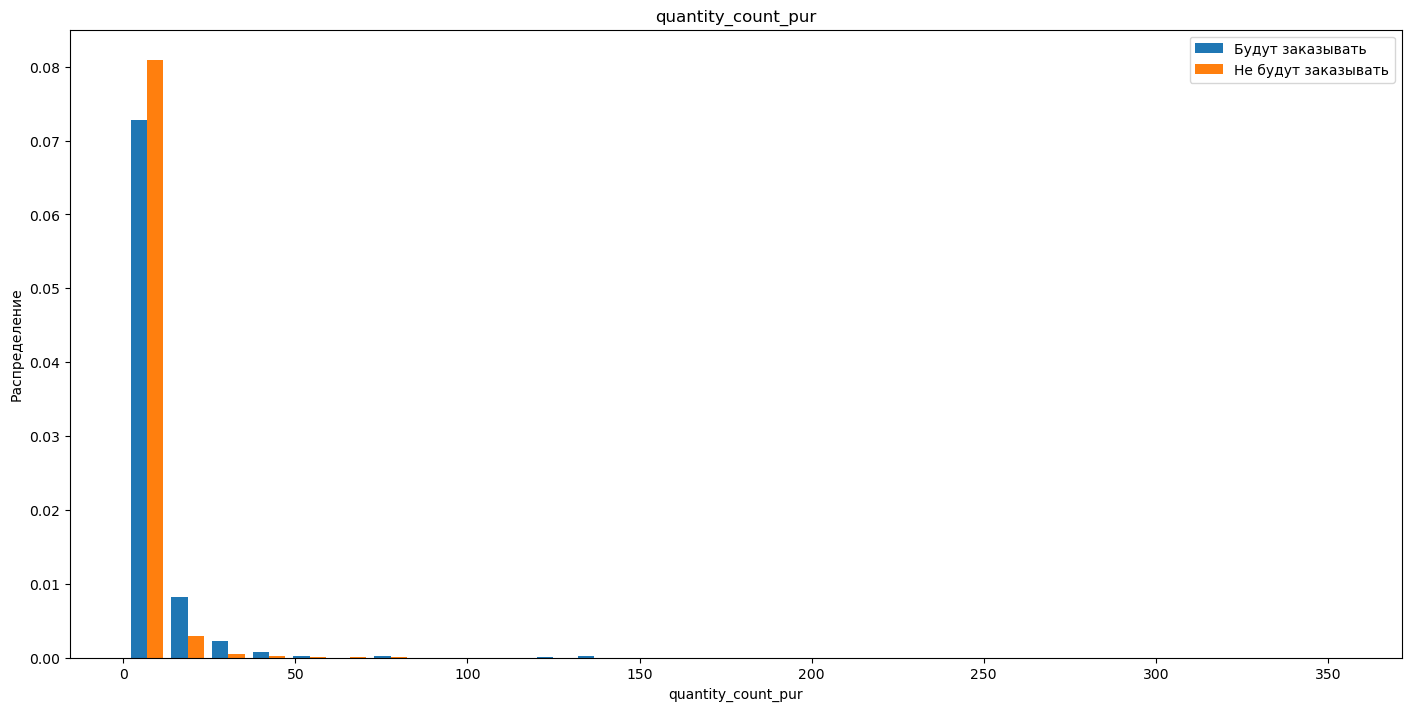

In [162]:
hist_2_sets_density(ds_merged,      #                         # Набор данных
            'quantity_count_pur',   #  column_for_paining     # По какому признаку строим график
            'target',            #  column_for_filtering   # По какому признаку разделяем по цветам
            1,                #  filter_1               # Условие отбора для первого нобора
            0,                 #  filter_2               # Условие отбора для второго набора
            'Будут заказывать',         #  set1_label             # Название первого набора
            'Не будут заказывать',           #  set2_label             # Название второго набора
           ) 

Те кто сделали один заказ, скорее не будут ничего больше заказывать в следующие 90 дней. Они так и не стали постоянными покупателями.

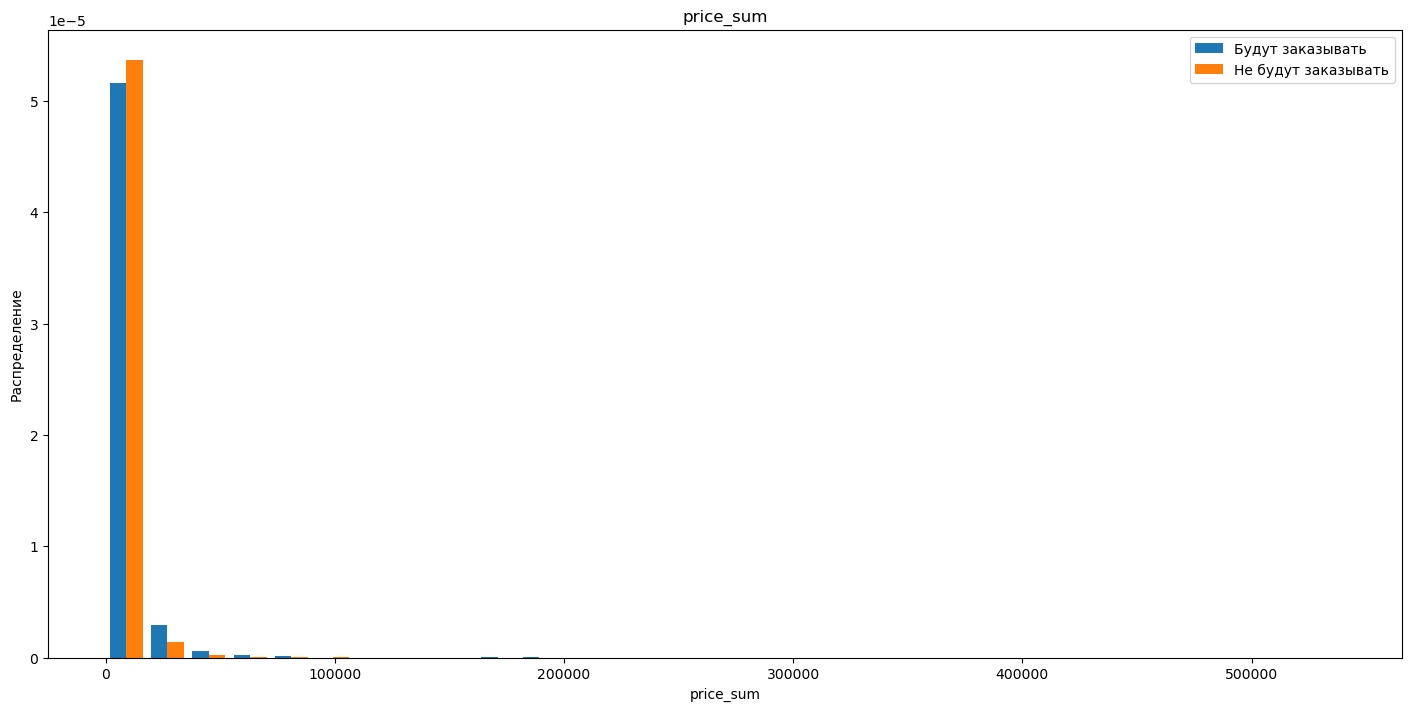

In [163]:
hist_2_sets_density(ds_merged,      #                         # Набор данных
            'price_sum',   #  column_for_paining     # По какому признаку строим график
            'target',            #  column_for_filtering   # По какому признаку разделяем по цветам
            1,                #  filter_1               # Условие отбора для первого нобора
            0,                 #  filter_2               # Условие отбора для второго набора
            'Будут заказывать',         #  set1_label             # Название первого набора
            'Не будут заказывать',           #  set2_label             # Название второго набора
           ) 

### Итог шага объединения агрегированных таблиц
* Были соеденены все агрегированные таблицы с целевым набором данных ds_a_target_binary. Соединение происходило по признаку client_id.
* Добавлено ещё одно поле : количество заказов делёное на количество рекламных акций.

##  Оптимизация

In [164]:
# удаляем неиспользуемые датафреймы
del ds_a_messages
del ds_daily_event
del ds_daily_event_channel

del ds_aggr_purchases
del ds_pivot_purchases
del ds_pivot_messages

#del ds_pivot_messages
del ds_aggr_messages

# Удалим поля с датами, они не участвуют в подстчёте моделей
ds_merged = ds_merged.drop(['start_date_pur','end_date_pur', 'start_date_mess', 'end_date_mess'], axis = 1)

#optimize_numeric_columns(ds_merged)

In [165]:
display(ds_merged.head(10))

,client_id,target,quantity_count_pur,price_sum,price_mean,day_to_0_pur,winter,spring,summer,autumn,...,cat_event_9_months,cat_event_12_months,cat_event_12+_months,cat_bulk_campaign_id_1_month,cat_bulk_campaign_id_3_months,cat_bulk_campaign_id_6_months,cat_bulk_campaign_id_9_months,cat_bulk_campaign_id_12_months,cat_bulk_campaign_id_12+_months,purchases_per_bulk
0,1515915625468060902,0,7,6993,999.000000,629,0,1,0,0,...,1,1,1,1,1,1,1,1,1,0.055118
1,1515915625468061003,1,7,16235,2319.285645,407,1,0,0,0,...,1,1,1,1,1,1,1,1,1,0.045455
2,1515915625468061099,0,1,299,299.000000,639,0,1,0,0,...,1,1,1,1,1,1,1,1,1,0.004651
3,1515915625468061100,0,2,2098,1049.000000,5,1,0,0,0,...,1,0,1,1,1,1,1,0,1,0.007547
4,1515915625468061170,0,19,33601,1768.473633,243,0,1,1,0,...,1,1,1,1,1,1,1,1,1,0.079167
5,1515915625468061514,0,1,999,999.000000,565,0,0,1,0,...,1,1,1,1,1,1,1,1,1,0.006667
6,1515915625468061877,0,1,1499,1499.000000,545,0,0,1,0,...,0,0,1,1,1,1,0,0,1,0.005882
7,1515915625468061975,0,1,299,299.000000,568,0,0,1,0,...,1,1,1,1,1,1,1,1,1,0.006494
8,1515915625468061994,0,8,1012,126.500000,428,1,0,0,1,...,1,1,1,1,1,1,1,1,1,0.023599
9,1515915625468062158,0,4,6096,1524.000000,293,0,1,0,0,...,1,1,1,1,1,1,1,1,1,0.035398


In [166]:
#emptyes_finder(ds_merged)

In [167]:
display(ds_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 69 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   client_id                        49849 non-null  int64   
 1   target                           49849 non-null  int8    
 2   quantity_count_pur               49849 non-null  int16   
 3   price_sum                        49849 non-null  int32   
 4   price_mean                       49849 non-null  float32 
 5   day_to_0_pur                     49849 non-null  int16   
 6   winter                           49849 non-null  category
 7   spring                           49849 non-null  category
 8   summer                           49849 non-null  category
 9   autumn                           49849 non-null  category
 10  first_category                   49849 non-null  category
 11  last_category                    49849 non-null  category
 12  day_

None

## Matrix

In [168]:
import phik

phik_overview = ds_merged.drop(['client_id'], axis = 1).phik_matrix(
#    interval_cols=['RegistrationYear', 'Kilometer','Price', 'Power']
)

interval columns not set, guessing: ['target', 'quantity_count_pur', 'price_sum', 'price_mean', 'day_to_0_pur', 'day_min_max_delta_pur', 'campaign_count', 'day_to_0_mess', 'email_cnt', 'mobile_cnt', 'day_min_max_delta_mess', 'price_12+_months', 'price_12_months', 'price_1_month', 'price_3_months', 'price_6_months', 'price_9_months', 'quantity_12+_months', 'quantity_12_months', 'quantity_1_month', 'quantity_3_months', 'quantity_6_months', 'quantity_9_months', 'bulk_campaign_id_12+_months', 'bulk_campaign_id_12_months', 'bulk_campaign_id_1_month', 'bulk_campaign_id_3_months', 'bulk_campaign_id_6_months', 'bulk_campaign_id_9_months', 'event_12+_months', 'event_12_months', 'event_1_month', 'event_3_months', 'event_6_months', 'event_9_months', 'purchases_per_bulk']


In [169]:
display(phik_overview['target'].loc[ phik_overview['target'] > 0.05].sort_values(ascending=False))

target                          1.000000
last_category                   0.137403
day_min_max_delta_pur           0.134146
cat_quantity_1_month            0.117762
day_to_0_pur                    0.115966
winter                          0.085080
bulk_campaign_id_3_months       0.070606
event_3_months                  0.070606
mobile_cnt                      0.064969
event_9_months                  0.064526
bulk_campaign_id_9_months       0.064526
cat_quantity_3_months           0.063883
bulk_campaign_id_1_month        0.060850
event_1_month                   0.060850
cat_quantity_6_months           0.056486
pur_day_activity                0.056074
cat_event_1_month               0.055974
cat_bulk_campaign_id_1_month    0.055974
last_activity_pur               0.055698
campaign_count                  0.055566
Name: target, dtype: float64

Phi_k  считает что максимальная зависимость есть у признаков: 
* "сколько дней прошло между первым и последним закозом клиента"
* "признак совершения заказа за последний месяц"
* "сколько дней прошло после последнего заказа"

Посмотрим на значения которые оказывают наименьшее влияние на оценку.

In [170]:
display(phik_overview['target'].sort_values(ascending=True).head(10))

price_mean                         0.000000
cat_bulk_campaign_id_12+_months    0.000000
cat_event_12+_months               0.000000
price_1_month                      0.000000
price_12_months                    0.000000
purchase                           0.007970
bounce                             0.008200
quantity_12_months                 0.009969
quantity_6_months                  0.010231
click                              0.010735
Name: target, dtype: float64

<Axes: >

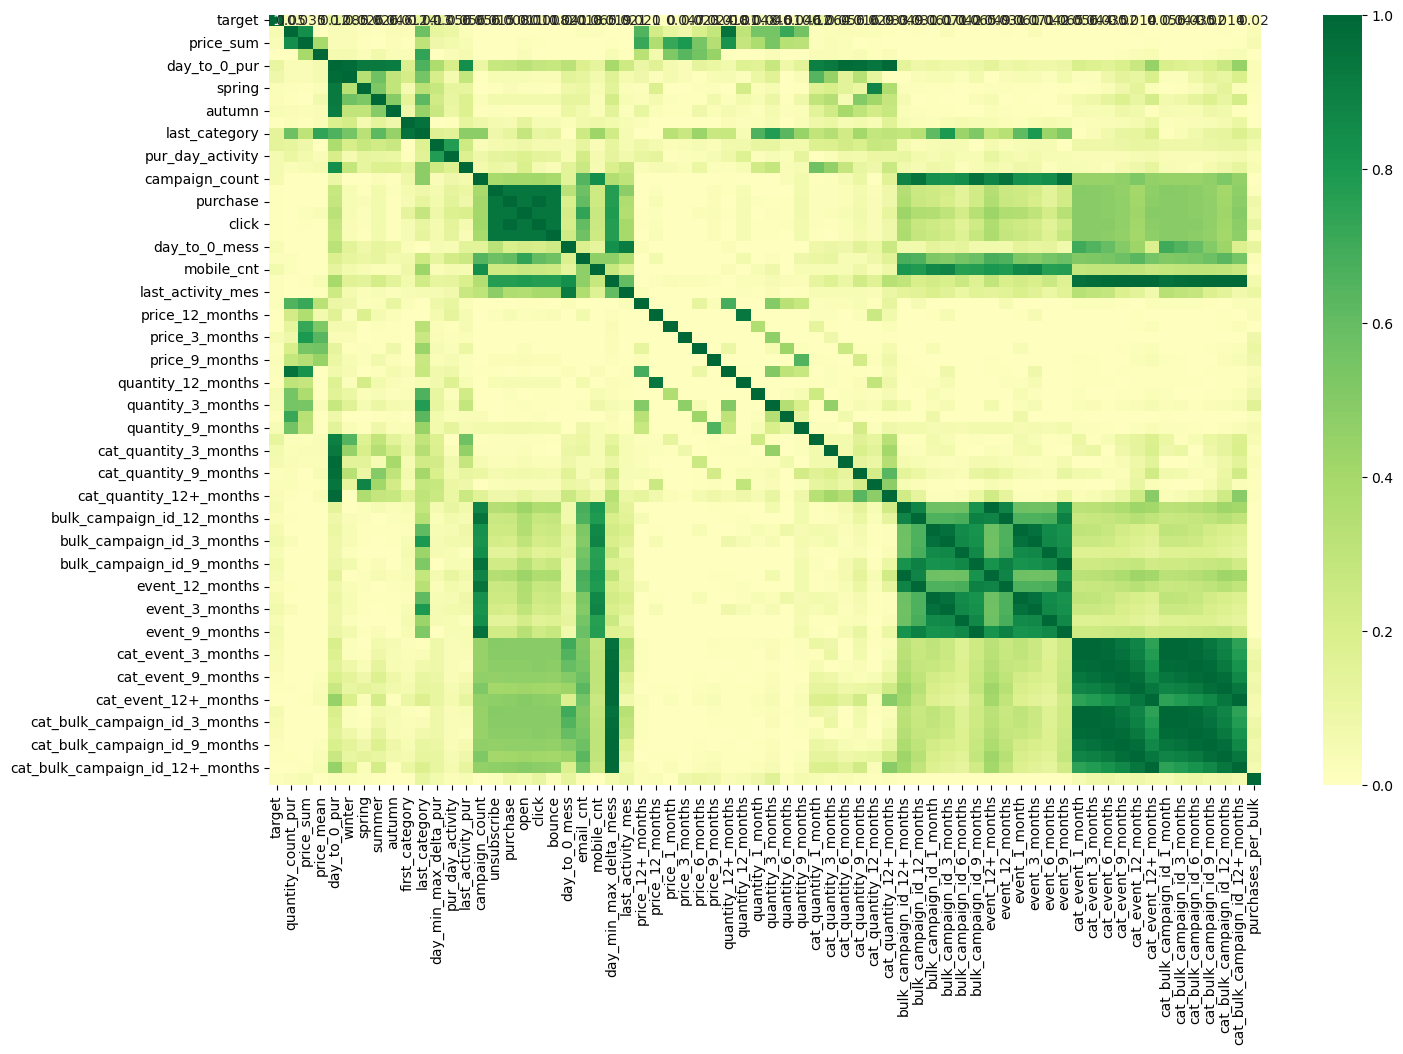

In [171]:
plt.figure(
            figsize=(16,10),
    #        dpi= 80\n",
        )
sns.heatmap(
    phik_overview,
    annot = True,
    fmt='.2g',
    cmap= 'RdYlGn',
    center=0,
)

Много признаков, тяжело понять кто влияет на "Target"/

## Подготовим данные

In [172]:
# Объявим константу random_state
RANDOM_STATE = 42

iter_num = 5    # Сколько шагов будет делать RandomizedSearchCV для определения лучшей модели.
kfold = 5        # На сколько частей будет делиться тренеровочные данные при кросс валидации.


#ds_mitrics_result = []

In [173]:
#emptyes_finder(ds_merged)ds_pivot_messages

In [174]:
ds_prep = ds_merged.set_index('client_id', inplace=False)

display(ds_prep.head())
display(ds_prep['target'].value_counts())

,target,quantity_count_pur,price_sum,price_mean,day_to_0_pur,winter,spring,summer,autumn,first_category,...,cat_event_9_months,cat_event_12_months,cat_event_12+_months,cat_bulk_campaign_id_1_month,cat_bulk_campaign_id_3_months,cat_bulk_campaign_id_6_months,cat_bulk_campaign_id_9_months,cat_bulk_campaign_id_12_months,cat_bulk_campaign_id_12+_months,purchases_per_bulk
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,0,7,6993,999.000000,629,0,1,0,0,4,...,1,1,1,1,1,1,1,1,1,0.055118
1515915625468061003,1,7,16235,2319.285645,407,1,0,0,0,4,...,1,1,1,1,1,1,1,1,1,0.045455
1515915625468061099,0,1,299,299.000000,639,0,1,0,0,4,...,1,1,1,1,1,1,1,1,1,0.004651
1515915625468061100,0,2,2098,1049.000000,5,1,0,0,0,4,...,1,0,1,1,1,1,1,0,1,0.007547
1515915625468061170,0,19,33601,1768.473633,243,0,1,1,0,4,...,1,1,1,1,1,1,1,1,1,0.079167


target
0    48888
1      961
Name: count, dtype: int64

In [175]:
#df_short_view(ds_prep)

In [176]:
y = ds_prep['target']
#X = ds_prep.drop(['target'], axis = 1).drop(['category_ids'], axis = 1)
X = ds_prep.drop(['target'], axis = 1)


Ещё раз проверим что у нас нет признаков с пропусками.

In [177]:
emptyes_finder(X)

Анализ пропущенных значений:
Колонка: quantity_count_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_sum
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: price_mean
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: day_to_0_pur
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: winter
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: spring
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: summer
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: autumn
Пропущенных значений: 0
Процент пропусков: 0.00%
----------------------------------------
Колонка: first_category
Пропущенных значений: 0
Процент пропусков: 0.00%
-------------------------

,Column,Missing_Count,Missing_Percentage
0,quantity_count_pur,0,0.00%
1,price_sum,0,0.00%
2,price_mean,0,0.00%
3,day_to_0_pur,0,0.00%
4,winter,0,0.00%
...,...,...,...
62,cat_bulk_campaign_id_6_months,0,0.00%
63,cat_bulk_campaign_id_9_months,0,0.00%
64,cat_bulk_campaign_id_12_months,0,0.00%
65,cat_bulk_campaign_id_12+_months,0,0.00%


In [178]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify = y, 
)

# Проверим размеры получившихся выборок
print('Размер тренировочной выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)
print('Размер выборки для целевых признаков тренировочной выборки:', y_train.shape)
print('Размер выборки для целевых признаков тестовой выборки:', y_test.shape)
print()

Размер тренировочной выборки: (39879, 67)
Размер тестовой выборки: (9970, 67)
Размер выборки для целевых признаков тренировочной выборки: (39879,)
Размер выборки для целевых признаков тестовой выборки: (9970,)



In [179]:
# Разделим все входные признаки на 3 группы

ohe_columns  = X.select_dtypes('category').columns.tolist()
ord_columns = []
num_columns  = X.select_dtypes('number').columns.tolist()


In [180]:
display('ohe_columns',ohe_columns)
print()
display('ord_columns',ord_columns)
print()
display('num_columns',num_columns)

'ohe_columns'

['winter',
 'spring',
 'summer',
 'autumn',
 'first_category',
 'last_category',
 'pur_day_activity',
 'last_activity_pur',
 'unsubscribe',
 'purchase',
 'open',
 'click',
 'bounce',
 'last_activity_mes',
 'cat_quantity_1_month',
 'cat_quantity_3_months',
 'cat_quantity_6_months',
 'cat_quantity_9_months',
 'cat_quantity_12_months',
 'cat_quantity_12+_months',
 'cat_event_1_month',
 'cat_event_3_months',
 'cat_event_6_months',
 'cat_event_9_months',
 'cat_event_12_months',
 'cat_event_12+_months',
 'cat_bulk_campaign_id_1_month',
 'cat_bulk_campaign_id_3_months',
 'cat_bulk_campaign_id_6_months',
 'cat_bulk_campaign_id_9_months',
 'cat_bulk_campaign_id_12_months',
 'cat_bulk_campaign_id_12+_months']

'ord_columns'

[]

'num_columns'

['quantity_count_pur',
 'price_sum',
 'price_mean',
 'day_to_0_pur',
 'day_min_max_delta_pur',
 'campaign_count',
 'day_to_0_mess',
 'email_cnt',
 'mobile_cnt',
 'day_min_max_delta_mess',
 'price_12+_months',
 'price_12_months',
 'price_1_month',
 'price_3_months',
 'price_6_months',
 'price_9_months',
 'quantity_12+_months',
 'quantity_12_months',
 'quantity_1_month',
 'quantity_3_months',
 'quantity_6_months',
 'quantity_9_months',
 'bulk_campaign_id_12+_months',
 'bulk_campaign_id_12_months',
 'bulk_campaign_id_1_month',
 'bulk_campaign_id_3_months',
 'bulk_campaign_id_6_months',
 'bulk_campaign_id_9_months',
 'event_12+_months',
 'event_12_months',
 'event_1_month',
 'event_3_months',
 'event_6_months',
 'event_9_months',
 'purchases_per_bulk']

In [181]:
# создаём пайплайны для разных типов данных
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(
        drop='first', 
#        handle_unknown='ignore', 
        handle_unknown='infrequent_if_exist',
#        sparse=False
        sparse_output=False
    )
    )
])

ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# объединяем пайплайны
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough', 
    force_int_remainder_cols=False  # Используем новый формат
                                     )

In [182]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

display(class_weights)



{0: 0.5098312452058297, 1: 25.929128738621586}

## Запустим расчёт на нескольких моделях для определения самой перспективной
Результат проверим в итоговой таблице

### CatBoostClassifier

In [183]:
pipe_cb = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', CatBoostClassifier(
                                silent=True, 
#                                cat_features=ohe_columns,
#                                  class_weights=class_weights, 
                                auto_class_weights='Balanced',                                  
                                iterations=200,
                                random_state=RANDOM_STATE,         
#                                eval_metric = 'Precision',
                                )
    )
])


params_cb = {'model__learning_rate': [0.05,0.1,0.25, 0.5],
#        'model__depth': [4, 6, 10, 16, 20, 25, 30],
             'model__l2_leaf_reg': [1, 3, 5, 7, 9],
             'model__depth': [ 3,4, 5,  ],
            }

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 2/5; 1/5] START model__depth=3, model__l2_leaf_reg=1, model__learning_rate=0.05
[CV 1/5; 1/5] START model__depth=3, model__l2_leaf_reg=1, model__learning_rate=0.05
[CV 4/5; 1/5] START model__depth=3, model__l2_leaf_reg=1, model__learning_rate=0.05
[CV 3/5; 1/5] START model__depth=3, model__l2_leaf_reg=1, model__learning_rate=0.05
[CV 5/5; 1/5] START model__depth=3, model__l2_leaf_reg=1, model__learning_rate=0.05
[CV 1/5; 2/5] START model__depth=3, model__l2_leaf_reg=3, model__learning_rate=0.1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/prep

[CV 3/5; 1/5] END model__depth=3, model__l2_leaf_reg=1, model__learning_rate=0.05;, score=0.735 total time=  13.3s
[CV 2/5; 2/5] START model__depth=3, model__l2_leaf_reg=3, model__learning_rate=0.1
[CV 5/5; 1/5] END model__depth=3, model__l2_leaf_reg=1, model__learning_rate=0.05;, score=0.741 total time=  13.4s
[CV 3/5; 2/5] START model__depth=3, model__l2_leaf_reg=3, model__learning_rate=0.1
[CV 2/5; 1/5] END model__depth=3, model__l2_leaf_reg=1, model__learning_rate=0.05;, score=0.750 total time=  13.7s
[CV 4/5; 2/5] START model__depth=3, model__l2_leaf_reg=3, model__learning_rate=0.1
[CV 1/5; 2/5] END model__depth=3, model__l2_leaf_reg=3, model__learning_rate=0.1;, score=0.725 total time=  13.5s
[CV 5/5; 2/5] START model__depth=3, model__l2_leaf_reg=3, model__learning_rate=0.1
[CV 4/5; 1/5] END model__depth=3, model__l2_leaf_reg=1, model__learning_rate=0.05;, score=0.713 total time=  14.0s
[CV 1/5; 3/5] START model__depth=4, model__l2_leaf_reg=9, model__learning_rate=0.05
[CV 1/5; 1

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/p

[CV 2/5; 2/5] END model__depth=3, model__l2_leaf_reg=3, model__learning_rate=0.1;, score=0.738 total time=  14.6s
[CV 3/5; 3/5] START model__depth=4, model__l2_leaf_reg=9, model__learning_rate=0.05
[CV 4/5; 2/5] END model__depth=3, model__l2_leaf_reg=3, model__learning_rate=0.1;, score=0.700 total time=  14.8s
[CV 4/5; 3/5] START model__depth=4, model__l2_leaf_reg=9, model__learning_rate=0.05
[CV 5/5; 2/5] END model__depth=3, model__l2_leaf_reg=3, model__learning_rate=0.1;, score=0.726 total time=  14.8s
[CV 5/5; 3/5] START model__depth=4, model__l2_leaf_reg=9, model__learning_rate=0.05
[CV 2/5; 3/5] END model__depth=4, model__l2_leaf_reg=9, model__learning_rate=0.05;, score=0.750 total time=  14.1s
[CV 1/5; 4/5] START model__depth=5, model__l2_leaf_reg=3, model__learning_rate=0.1
[CV 3/5; 2/5] END model__depth=3, model__l2_leaf_reg=3, model__learning_rate=0.1;, score=0.714 total time=  15.6s
[CV 2/5; 4/5] START model__depth=5, model__l2_leaf_reg=3, model__learning_rate=0.1
[CV 1/5; 3/

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 3/5] END model__depth=4, model__l2_leaf_reg=9, model__learning_rate=0.05;, score=0.731 total time=  15.2s
[CV 4/5; 4/5] START model__depth=5, model__l2_leaf_reg=3, model__learning_rate=0.1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 3/5] END model__depth=4, model__l2_leaf_reg=9, model__learning_rate=0.05;, score=0.718 total time=  15.7s
[CV 5/5; 4/5] START model__depth=5, model__l2_leaf_reg=3, model__learning_rate=0.1
[CV 2/5; 4/5] END model__depth=5, model__l2_leaf_reg=3, model__learning_rate=0.1;, score=0.731 total time=  15.1s
[CV 1/5; 5/5] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.1
[CV 5/5; 3/5] END model__depth=4, model__l2_leaf_reg=9, model__learning_rate=0.05;, score=0.746 total time=  16.0s
[CV 2/5; 5/5] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.1
[CV 1/5; 4/5] END model__depth=5, model__l2_leaf_reg=3, model__learning_rate=0.1;, score=0.700 total time=  16.5s
[CV 3/5; 5/5] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.1
[CV 3/5; 4/5] END model__depth=5, model__l2_leaf_reg=3, model__learning_rate=0.1;, score=0.688 total time=  16.2s
[CV 4/5; 5/5] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/p

[CV 4/5; 4/5] END model__depth=5, model__l2_leaf_reg=3, model__learning_rate=0.1;, score=0.684 total time=  15.4s
[CV 5/5; 5/5] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 5/5] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.1;, score=0.747 total time=  14.8s
[CV 5/5; 4/5] END model__depth=5, model__l2_leaf_reg=3, model__learning_rate=0.1;, score=0.704 total time=  15.4s[CV 3/5; 5/5] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.1;, score=0.726 total time=  14.5s

[CV 1/5; 5/5] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.1;, score=0.731 total time=  15.9s
[CV 4/5; 5/5] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.1;, score=0.710 total time=  15.1s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 5/5] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.1;, score=0.746 total time=   8.4s



{'model__learning_rate': 0.05, 'model__l2_leaf_reg': 9, 'model__depth': 4}

Метрики модели CatBoostClassifier на тестовых данных :


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ROC-AUC = 0.68
Precision = 0.05
Recall = 0.6
Accuracy = 0.76
Метрики модели CatBoostClassifier на тренировочных данных:
ROC-AUC = 0.72
Precision = 0.05
Recall = 0.69
Accuracy = 0.76

Метрика оценки roc_auc



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__l2_leaf_reg,param_model__depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.788666,0.543025,1.979869,0.147658,0.05,1,3,"{'model__learning_rate': 0.05, 'model__l2_leaf...",0.737647,0.750168,0.735315,0.713321,0.740809,0.735452,0.012164,2
1,12.568251,0.751302,2.098460,0.381913,0.10,3,3,"{'model__learning_rate': 0.1, 'model__l2_leaf_...",0.725067,0.738281,0.713550,0.699628,0.725747,0.720455,0.013027,4
2,13.022696,0.873195,2.245731,0.538701,0.05,9,4,"{'model__learning_rate': 0.05, 'model__l2_leaf...",0.742769,0.750278,0.730865,0.718310,0.746119,0.737668,0.011640,1
3,13.331775,1.048665,2.405407,0.673470,0.10,3,5,"{'model__learning_rate': 0.1, 'model__l2_leaf_...",0.699823,0.730660,0.687818,0.684267,0.704217,0.701357,0.016399,5
4,11.864785,2.558665,1.857078,0.385688,0.10,7,3,"{'model__learning_rate': 0.1, 'model__l2_leaf_...",0.730859,0.746534,0.725827,0.710440,0.745939,0.731920,0.013489,3


Время запуска перебора: 86.41 секунд


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------------------



,ROC_AUC,precision,recall,accuracy,f1_score,TN,FN,TP,FP,Model_name,Model_check,Model_scoring,Model_best_params
0,0.723385,0.053290,0.686606,0.758745,0.098904,29730,241,528,9380,CatBoostClassifier,Train,roc_auc,"{'model__learning_rate': 0.05, 'model__l2_leaf..."
0,0.680488,0.047093,0.598958,0.758877,0.087320,7451,77,115,2327,CatBoostClassifier,Test,roc_auc,"{'model__learning_rate': 0.05, 'model__l2_leaf..."


-----------------------------------------------


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


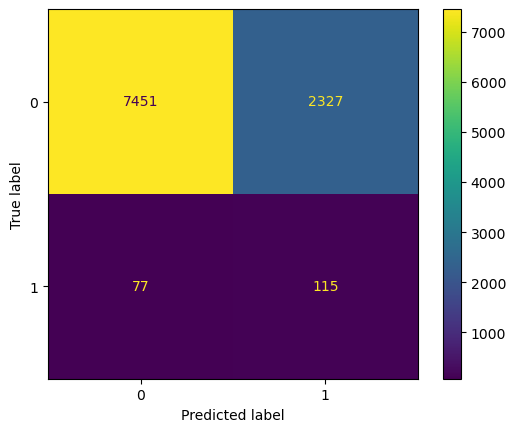

In [184]:
ds_result = fit_and_metrics_return(
        model_name='CatBoostClassifier',  #  Имя модели
        pipe = pipe_cb,       # pipeline
        param = params_cb,      # подготовленные параметры для перебора
        n_iter =iter_num,     # количество итераций
        verbose = 100,    # уровень логирования
        X_train = X_train,    #  Тренеровочные данные
        y_train = y_train,    # тренеровочный признак
        X_test = X_test,     #  тестовые данные
        y_test = y_test      #  тестовый признак
)
# Запишем данные в нашу сводную табличку
ds_mitrics_result = ds_result

In [185]:
print('n_iter =',iter_num)
print('kfold = ', kfold)

n_iter = 5
kfold =  5


### KNeighborsClassifier

In [186]:
pipe_knn = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', KNeighborsClassifier( ))
])
param_knn = {
    'model__n_neighbors': [3, 5, 7, 9],  # Указываем с префиксом classifier__
    'model__weights': ['uniform', 'distance'],
}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START model__n_neighbors=3, model__weights=distance...............
[CV 2/5; 1/5] START model__n_neighbors=3, model__weights=distance...............
[CV 3/5; 1/5] START model__n_neighbors=3, model__weights=distance...............
[CV 4/5; 1/5] START model__n_neighbors=3, model__weights=distance...............
[CV 5/5; 1/5] START model__n_neighbors=3, model__weights=distance...............
[CV 1/5; 2/5] START model__n_neighbors=7, model__weights=distance...............


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/p

[CV 5/5; 1/5] END model__n_neighbors=3, model__weights=distance;, score=0.510 total time=  19.0s
[CV 2/5; 2/5] START model__n_neighbors=7, model__weights=distance...............
[CV 4/5; 1/5] END model__n_neighbors=3, model__weights=distance;, score=0.515 total time=  19.2s
[CV 3/5; 2/5] START model__n_neighbors=7, model__weights=distance...............
[CV 3/5; 1/5] END model__n_neighbors=3, model__weights=distance;, score=0.528 total time=  19.4s
[CV 4/5; 2/5] START model__n_neighbors=7, model__weights=distance...............
[CV 1/5; 2/5] END model__n_neighbors=7, model__weights=distance;, score=0.549 total time=  19.4s
[CV 5/5; 2/5] START model__n_neighbors=7, model__weights=distance...............
[CV 2/5; 1/5] END model__n_neighbors=3, model__weights=distance;, score=0.513 total time=  19.5s
[CV 1/5; 1/5] END model__n_neighbors=3, model__weights=distance;, score=0.529 total time=  19.5s
[CV 1/5; 3/5] START model__n_neighbors=3, model__weights=uniform................
[CV 2/5; 3/5]

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/p

[CV 2/5; 2/5] END model__n_neighbors=7, model__weights=distance;, score=0.547 total time=  19.2s
[CV 3/5; 3/5] START model__n_neighbors=3, model__weights=uniform................
[CV 2/5; 3/5] END model__n_neighbors=3, model__weights=uniform;, score=0.513 total time=  19.2s
[CV 4/5; 3/5] START model__n_neighbors=3, model__weights=uniform................
[CV 4/5; 2/5] END model__n_neighbors=7, model__weights=distance;, score=0.541 total time=  19.4s
[CV 5/5; 3/5] START model__n_neighbors=3, model__weights=uniform................
[CV 5/5; 2/5] END model__n_neighbors=7, model__weights=distance;, score=0.528 total time=  19.5s
[CV 1/5; 4/5] START model__n_neighbors=9, model__weights=distance...............
[CV 3/5; 2/5] END model__n_neighbors=7, model__weights=distance;, score=0.551 total time=  19.9s
[CV 2/5; 4/5] START model__n_neighbors=9, model__weights=distance...............


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 3/5] END model__n_neighbors=3, model__weights=uniform;, score=0.529 total time=  19.8s
[CV 3/5; 4/5] START model__n_neighbors=9, model__weights=distance...............


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/p

[CV 4/5; 3/5] END model__n_neighbors=3, model__weights=uniform;, score=0.515 total time=  20.2s
[CV 4/5; 4/5] START model__n_neighbors=9, model__weights=distance...............
[CV 3/5; 3/5] END model__n_neighbors=3, model__weights=uniform;, score=0.528 total time=  21.0s
[CV 5/5; 3/5] END model__n_neighbors=3, model__weights=uniform;, score=0.510 total time=  20.4s
[CV 5/5; 4/5] START model__n_neighbors=9, model__weights=distance...............
[CV 2/5; 4/5] END model__n_neighbors=9, model__weights=distance;, score=0.565 total time=  20.2s
[CV 1/5; 5/5] START model__n_neighbors=5, model__weights=uniform................
[CV 2/5; 5/5] START model__n_neighbors=5, model__weights=uniform................
[CV 3/5; 4/5] END model__n_neighbors=9, model__weights=distance;, score=0.556 total time=  20.2s
[CV 3/5; 5/5] START model__n_neighbors=5, model__weights=uniform................
[CV 1/5; 4/5] END model__n_neighbors=9, model__weights=distance;, score=0.561 total time=  20.6s
[CV 4/5; 5/5] ST

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/p

[CV 4/5; 4/5] END model__n_neighbors=9, model__weights=distance;, score=0.536 total time=  18.9s
[CV 5/5; 5/5] START model__n_neighbors=5, model__weights=uniform................
[CV 4/5; 5/5] END model__n_neighbors=5, model__weights=uniform;, score=0.536 total time=  18.8s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 4/5] END model__n_neighbors=9, model__weights=distance;, score=0.536 total time=  19.5s
[CV 3/5; 5/5] END model__n_neighbors=5, model__weights=uniform;, score=0.537 total time=  19.2s
[CV 2/5; 5/5] END model__n_neighbors=5, model__weights=uniform;, score=0.536 total time=  19.6s
[CV 1/5; 5/5] END model__n_neighbors=5, model__weights=uniform;, score=0.535 total time=  19.9s
[CV 5/5; 5/5] END model__n_neighbors=5, model__weights=uniform;, score=0.515 total time=  10.5s



{'model__weights': 'distance', 'model__n_neighbors': 9}

Метрики модели KNeighborsClassifier на тестовых данных :


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ROC-AUC = 0.5
Precision = 0.25
Recall = 0.01
Accuracy = 0.98
Метрики модели KNeighborsClassifier на тренировочных данных:
ROC-AUC = 1.0
Precision = 1.0
Recall = 1.0
Accuracy = 1.0

Метрика оценки roc_auc



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__weights,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.784296,0.008310,18.515441,0.201408,distance,3,"{'model__weights': 'distance', 'model__n_neigh...",0.529313,0.513157,0.528167,0.515073,0.509809,0.519104,0.008055,5
1,0.813838,0.123488,18.652328,0.107025,distance,7,"{'model__weights': 'distance', 'model__n_neigh...",0.549193,0.547406,0.550868,0.540684,0.528204,0.543271,0.008289,2
2,0.746557,0.050512,19.360546,0.608037,uniform,3,"{'model__weights': 'uniform', 'model__n_neighb...",0.529150,0.513460,0.528340,0.515427,0.509586,0.519193,0.008027,4
3,0.887777,0.122193,18.993339,0.548951,distance,9,"{'model__weights': 'distance', 'model__n_neigh...",0.561179,0.565228,0.555956,0.536114,0.535767,0.550849,0.012523,1
4,0.826675,0.085545,16.781135,3.559877,uniform,5,"{'model__weights': 'uniform', 'model__n_neighb...",0.535290,0.536032,0.536869,0.536055,0.515172,0.531884,0.008371,3


Время запуска перебора: 114.35 секунд


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------------------



,ROC_AUC,precision,recall,accuracy,f1_score,TN,FN,TP,FP,Model_name,Model_check,Model_scoring,Model_best_params
0,0.999350,1.00,0.998700,0.999975,0.999349,39110,1,768,0,KNeighborsClassifier,Train,roc_auc,"{'model__weights': 'distance', 'model__n_neigh..."
0,0.502451,0.25,0.005208,0.980542,0.010204,9775,191,1,3,KNeighborsClassifier,Test,roc_auc,"{'model__weights': 'distance', 'model__n_neigh..."


-----------------------------------------------


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


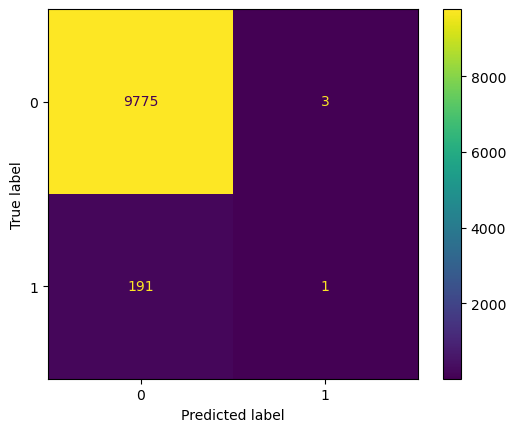

In [187]:
ds_result = fit_and_metrics_return(
        model_name='KNeighborsClassifier',  #  Имя модели
        pipe = pipe_knn,       # pipeline
        param = param_knn,      # подготовленные параметры для перебора
        n_iter =iter_num,     # количество итераций
        verbose = 100,    # уровень логирования
        X_train = X_train,    #  Тренеровочные данные
        y_train = y_train,    # тренеровочный признак
        X_test = X_test,     #  тестовые данные
        y_test = y_test      #  тестовый признак
)
# Запишем данные в сводную таблицу
ds_mitrics_result = pd.concat([
                                ds_mitrics_result,
                                ds_result
                            ])

### RandomForestClassifier

In [188]:
pipe_rfc = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', RandomForestClassifier(
                                        random_state=RANDOM_STATE,  
#                                        class_weight = 'balanced',
                                        class_weight = class_weights,        
                                        )
    )
])

param_rfc = {
    'model__n_estimators': [50, 100, 250, 500, 750],  # 
    'model__max_depth': [None,5, 10, 15, 20, 25, 30],
    'model__min_samples_split': [2, 4, 6, 8,],
    'model__min_samples_leaf': [2, 3, 4,],    
#    'model__max_features': ['sqrt', 'log2'],  
    
}



Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START model__max_depth=10, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=50
[CV 2/5; 1/5] START model__max_depth=10, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=50
[CV 3/5; 1/5] START model__max_depth=10, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=50
[CV 4/5; 1/5] START model__max_depth=10, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=50[CV 5/5; 1/5] START model__max_depth=10, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=50

[CV 1/5; 2/5] START model__max_depth=25, model__min_samples_leaf=3, model__min_samples_split=6, model__n_estimators=750


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 1/5] END model__max_depth=10, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=50;, score=0.739 total time=   6.0s
[CV 2/5; 2/5] START model__max_depth=25, model__min_samples_leaf=3, model__min_samples_split=6, model__n_estimators=750
[CV 1/5; 1/5] END model__max_depth=10, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=50;, score=0.707 total time=   6.1s
[CV 3/5; 2/5] START model__max_depth=25, model__min_samples_leaf=3, model__min_samples_split=6, model__n_estimators=750


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 1/5] END model__max_depth=10, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=50;, score=0.725 total time=   6.2s
[CV 3/5; 1/5] END model__max_depth=10, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=50;, score=0.718 total time=   6.3s
[CV 4/5; 2/5] START model__max_depth=25, model__min_samples_leaf=3, model__min_samples_split=6, model__n_estimators=750
[CV 5/5; 2/5] START model__max_depth=25, model__min_samples_leaf=3, model__min_samples_split=6, model__n_estimators=750


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 1/5] END model__max_depth=10, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=50;, score=0.690 total time=   6.5s
[CV 1/5; 3/5] START model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 3/5] END model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=50;, score=0.717 total time=   5.8s
[CV 2/5; 3/5] START model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 3/5] END model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=50;, score=0.748 total time=   5.8s
[CV 3/5; 3/5] START model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 3/5] END model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=50;, score=0.716 total time=   5.8s
[CV 4/5; 3/5] START model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 3/5] END model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=50;, score=0.695 total time=   5.8s
[CV 5/5; 3/5] START model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=50


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 3/5] END model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=50;, score=0.726 total time=   5.6s
[CV 1/5; 4/5] START model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=750


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 2/5] END model__max_depth=25, model__min_samples_leaf=3, model__min_samples_split=6, model__n_estimators=750;, score=0.716 total time= 1.7min


/home/segius/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5; 4/5] START model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=750


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 2/5] END model__max_depth=25, model__min_samples_leaf=3, model__min_samples_split=6, model__n_estimators=750;, score=0.703 total time= 1.7min
[CV 2/5; 2/5] END model__max_depth=25, model__min_samples_leaf=3, model__min_samples_split=6, model__n_estimators=750;, score=0.732 total time= 1.7min


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 4/5] START model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=750
[CV 3/5; 2/5] END model__max_depth=25, model__min_samples_leaf=3, model__min_samples_split=6, model__n_estimators=750;, score=0.698 total time= 1.7min
[CV 4/5; 4/5] START model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=750
[CV 5/5; 2/5] END model__max_depth=25, model__min_samples_leaf=3, model__min_samples_split=6, model__n_estimators=750;, score=0.734 total time= 1.7min
[CV 5/5; 4/5] START model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=750
[CV 1/5; 5/5] START model__max_depth=30, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=100


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 5/5] END model__max_depth=30, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=100;, score=0.724 total time=  14.6s
[CV 2/5; 5/5] START model__max_depth=30, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=100


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 5/5] END model__max_depth=30, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=100;, score=0.725 total time=  14.1s
[CV 3/5; 5/5] START model__max_depth=30, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=100
[CV 1/5; 4/5] END model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=750;, score=0.709 total time= 1.8min
[CV 4/5; 5/5] START model__max_depth=30, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=100


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 5/5] END model__max_depth=30, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=100;, score=0.711 total time=  13.9s
[CV 5/5; 5/5] START model__max_depth=30, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=100


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 5/5] END model__max_depth=30, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=100;, score=0.702 total time=  14.7s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 5/5] END model__max_depth=30, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=100;, score=0.722 total time=  12.4s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 4/5] END model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=750;, score=0.723 total time= 1.5min


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 4/5] END model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=750;, score=0.703 total time= 1.5min
[CV 3/5; 4/5] END model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=750;, score=0.691 total time= 1.5min


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 4/5] END model__max_depth=30, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=750;, score=0.737 total time= 1.5min



{'model__n_estimators': 50,
 'model__min_samples_split': 8,
 'model__min_samples_leaf': 4,
 'model__max_depth': 10}

Метрики модели RandomForestClassifier на тестовых данных :


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ROC-AUC = 0.65
Precision = 0.06
Recall = 0.42
Accuracy = 0.87
Метрики модели RandomForestClassifier на тренировочных данных:
ROC-AUC = 0.77
Precision = 0.1
Recall = 0.67
Accuracy = 0.88

Метрика оценки roc_auc



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.939807,0.177515,0.275862,0.025214,50,4,3,10,"{'model__n_estimators': 50, 'model__min_sample...",0.706937,0.738839,0.717544,0.689773,0.725164,0.715651,0.016597,4
1,100.558539,1.322814,2.137307,0.138251,750,6,3,25,"{'model__n_estimators': 750, 'model__min_sampl...",0.715617,0.731731,0.697552,0.702857,0.734485,0.716448,0.014842,3
2,5.492261,0.085558,0.252394,0.008039,50,8,4,10,"{'model__n_estimators': 50, 'model__min_sample...",0.717488,0.747736,0.715982,0.694520,0.726194,0.720384,0.017197,1
3,91.465939,6.622315,1.650628,0.363684,750,4,2,30,"{'model__n_estimators': 750, 'model__min_sampl...",0.708717,0.722736,0.691162,0.702550,0.736908,0.712415,0.015932,5
4,13.529306,0.822087,0.417827,0.012629,100,8,4,30,"{'model__n_estimators': 100, 'model__min_sampl...",0.723581,0.724712,0.710567,0.702224,0.722140,0.716645,0.008812,2


Время запуска перебора: 205.78 секунд


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------------------



,ROC_AUC,precision,recall,accuracy,f1_score,TN,FN,TP,FP,Model_name,Model_check,Model_scoring,Model_best_params
0,0.772532,0.097822,0.665800,0.875147,0.170581,34388,257,512,4722,RandomForestClassifier,Train,roc_auc,"{'model__n_estimators': 50, 'model__min_sample..."
0,0.650751,0.064388,0.421875,0.870812,0.111724,8601,111,81,1177,RandomForestClassifier,Test,roc_auc,"{'model__n_estimators': 50, 'model__min_sample..."


-----------------------------------------------


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


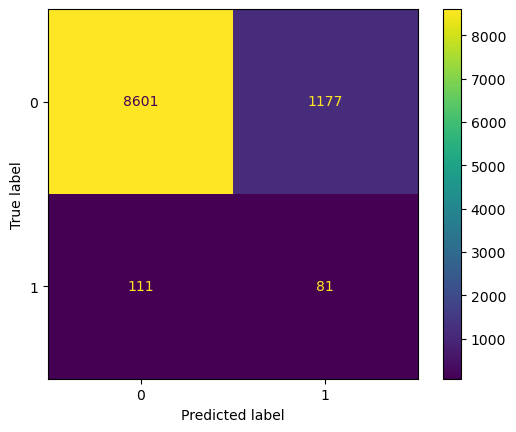

In [189]:
ds_result = fit_and_metrics_return(
        model_name='RandomForestClassifier',  #  Имя модели
        pipe = pipe_rfc,       # pipeline
        param = param_rfc,      # подготовленные параметры для перебора
        n_iter =iter_num,     # количество итераций
        verbose = 100,    # уровень логирования
        X_train = X_train,    #  Тренеровочные данные
        y_train = y_train,    # тренеровочный признак
        X_test = X_test,     #  тестовые данные
        y_test = y_test      #  тестовый признак
)
# Запишем данные в сводную таблицу
ds_mitrics_result = pd.concat([
                                ds_mitrics_result,
                                ds_result
                            ])

### DecisionTreeClassifier

In [190]:

#model_dt = DecisionTreeClassifier(random_state=42,  class_weight = 'balanced')

pipe_dt = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeClassifier( 
                                     random_state=RANDOM_STATE,
                                     class_weight = 'balanced'
                                    )
    )
])

param_dt = {
    'model__min_samples_leaf': [ 2, 4, 8, 16],
    'model__max_depth': [None, 3, 4,5, 6, 7, 8, 10],
    'model__min_samples_split': [ 2, 4, 8],
#    'model__max_features': ['auto', 'sqrt', 'log2']
}


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START model__max_depth=8, model__min_samples_leaf=8, model__min_samples_split=8
[CV 2/5; 1/5] START model__max_depth=8, model__min_samples_leaf=8, model__min_samples_split=8
[CV 3/5; 1/5] START model__max_depth=8, model__min_samples_leaf=8, model__min_samples_split=8
[CV 4/5; 1/5] START model__max_depth=8, model__min_samples_leaf=8, model__min_samples_split=8
[CV 5/5; 1/5] START model__max_depth=8, model__min_samples_leaf=8, model__min_samples_split=8
[CV 1/5; 2/5] START model__max_depth=8, model__min_samples_leaf=4, model__min_samples_split=8


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/p

[CV 1/5; 2/5] END model__max_depth=8, model__min_samples_leaf=4, model__min_samples_split=8;, score=0.611 total time=   4.0s
[CV 2/5; 2/5] START model__max_depth=8, model__min_samples_leaf=4, model__min_samples_split=8
[CV 1/5; 1/5] END model__max_depth=8, model__min_samples_leaf=8, model__min_samples_split=8;, score=0.611 total time=   4.2s
[CV 2/5; 1/5] END model__max_depth=8, model__min_samples_leaf=8, model__min_samples_split=8;, score=0.608 total time=   4.1s
[CV 3/5; 2/5] START model__max_depth=8, model__min_samples_leaf=4, model__min_samples_split=8
[CV 4/5; 1/5] END model__max_depth=8, model__min_samples_leaf=8, model__min_samples_split=8;, score=0.581 total time=   4.1s
[CV 4/5; 2/5] START model__max_depth=8, model__min_samples_leaf=4, model__min_samples_split=8
[CV 5/5; 1/5] END model__max_depth=8, model__min_samples_leaf=8, model__min_samples_split=8;, score=0.605 total time=   4.2s
[CV 5/5; 2/5] START model__max_depth=8, model__min_samples_leaf=4, model__min_samples_split=8

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 1/5] END model__max_depth=8, model__min_samples_leaf=8, model__min_samples_split=8;, score=0.578 total time=   4.4s
[CV 2/5; 3/5] START model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=4


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 2/5] END model__max_depth=8, model__min_samples_leaf=4, model__min_samples_split=8;, score=0.602 total time=   4.0s
[CV 3/5; 3/5] START model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=4
[CV 2/5; 3/5] END model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=4;, score=0.609 total time=   3.9s
[CV 1/5; 3/5] END model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=4;, score=0.612 total time=   4.0s
[CV 3/5; 2/5] END model__max_depth=8, model__min_samples_leaf=4, model__min_samples_split=8;, score=0.572 total time=   4.1s
[CV 4/5; 3/5] START model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=4
[CV 5/5; 3/5] START model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=4


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 4/5] START model__max_depth=10, model__min_samples_leaf=16, model__min_samples_split=4
[CV 5/5; 2/5] END model__max_depth=8, model__min_samples_leaf=4, model__min_samples_split=8;, score=0.593 total time=   4.2s
[CV 2/5; 4/5] START model__max_depth=10, model__min_samples_leaf=16, model__min_samples_split=4
[CV 4/5; 2/5] END model__max_depth=8, model__min_samples_leaf=4, model__min_samples_split=8;, score=0.581 total time=   4.2s
[CV 3/5; 4/5] START model__max_depth=10, model__min_samples_leaf=16, model__min_samples_split=4


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 3/5] END model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=4;, score=0.581 total time=   4.0s
[CV 4/5; 4/5] START model__max_depth=10, model__min_samples_leaf=16, model__min_samples_split=4
[CV 3/5; 3/5] END model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=4;, score=0.572 total time=   4.2s
[CV 5/5; 4/5] START model__max_depth=10, model__min_samples_leaf=16, model__min_samples_split=4


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 3/5] END model__max_depth=8, model__min_samples_leaf=2, model__min_samples_split=4;, score=0.600 total time=   4.3s
[CV 1/5; 5/5] START model__max_depth=4, model__min_samples_leaf=16, model__min_samples_split=2
[CV 2/5; 4/5] END model__max_depth=10, model__min_samples_leaf=16, model__min_samples_split=4;, score=0.547 total time=   4.3s
[CV 2/5; 5/5] START model__max_depth=4, model__min_samples_leaf=16, model__min_samples_split=2
[CV 1/5; 4/5] END model__max_depth=10, model__min_samples_leaf=16, model__min_samples_split=4;, score=0.599 total time=   4.4s
[CV 3/5; 5/5] START model__max_depth=4, model__min_samples_leaf=16, model__min_samples_split=2


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 4/5] END model__max_depth=10, model__min_samples_leaf=16, model__min_samples_split=4;, score=0.549 total time=   4.6s
[CV 4/5; 5/5] START model__max_depth=4, model__min_samples_leaf=16, model__min_samples_split=2


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 5/5] END model__max_depth=4, model__min_samples_leaf=16, model__min_samples_split=2;, score=0.710 total time=   3.0s
[CV 5/5; 5/5] START model__max_depth=4, model__min_samples_leaf=16, model__min_samples_split=2
[CV 1/5; 5/5] END model__max_depth=4, model__min_samples_leaf=16, model__min_samples_split=2;, score=0.713 total time=   3.2s
[CV 3/5; 5/5] END model__max_depth=4, model__min_samples_leaf=16, model__min_samples_split=2;, score=0.595 total time=   3.2s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 5/5] END model__max_depth=4, model__min_samples_leaf=16, model__min_samples_split=2;, score=0.671 total time=   2.9s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 4/5] END model__max_depth=10, model__min_samples_leaf=16, model__min_samples_split=4;, score=0.542 total time=   4.2s
[CV 5/5; 4/5] END model__max_depth=10, model__min_samples_leaf=16, model__min_samples_split=4;, score=0.595 total time=   4.1s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 5/5] END model__max_depth=4, model__min_samples_leaf=16, model__min_samples_split=2;, score=0.693 total time=   1.6s



{'model__min_samples_split': 2,
 'model__min_samples_leaf': 16,
 'model__max_depth': 4}

Метрики модели DecisionTreeClassifier на тестовых данных :
ROC-AUC = 0.65
Precision = 0.04
Recall = 0.6
Accuracy = 0.7
Метрики модели DecisionTreeClassifier на тренировочных данных:


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ROC-AUC = 0.69
Precision = 0.04
Recall = 0.68
Accuracy = 0.7

Метрика оценки roc_auc



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.015330,0.067959,0.177442,0.015299,8,8,8,"{'model__min_samples_split': 8, 'model__min_sa...",0.611336,0.607969,0.577612,0.580682,0.605053,0.596530,0.014365,2
1,3.934844,0.072151,0.164207,0.016210,8,4,8,"{'model__min_samples_split': 8, 'model__min_sa...",0.611096,0.602239,0.571996,0.580703,0.593247,0.591856,0.014133,4
2,3.901227,0.154358,0.160314,0.008177,4,2,8,"{'model__min_samples_split': 4, 'model__min_sa...",0.612003,0.608624,0.572405,0.580609,0.599744,0.594677,0.015584,3
3,4.156398,0.165619,0.153078,0.027092,4,16,10,"{'model__min_samples_split': 4, 'model__min_sa...",0.599137,0.547323,0.548791,0.541710,0.594882,0.566368,0.025165,5
4,2.612715,0.585437,0.163055,0.047145,2,16,4,"{'model__min_samples_split': 2, 'model__min_sa...",0.713480,0.709809,0.594693,0.671373,0.692579,0.676387,0.043484,1


Время запуска перебора: 19.73 секунд


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------------------



,ROC_AUC,precision,recall,accuracy,f1_score,TN,FN,TP,FP,Model_name,Model_check,Model_scoring,Model_best_params
0,0.688894,0.042654,0.676203,0.701096,0.080247,27439,249,520,11671,DecisionTreeClassifier,Train,roc_auc,"{'model__min_samples_split': 2, 'model__min_sa..."
0,0.654098,0.038538,0.604167,0.702106,0.072455,6884,76,116,2894,DecisionTreeClassifier,Test,roc_auc,"{'model__min_samples_split': 2, 'model__min_sa..."


-----------------------------------------------


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


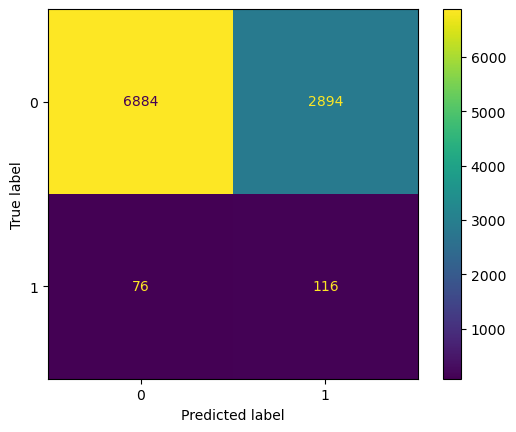

In [191]:
ds_result = fit_and_metrics_return(
        model_name='DecisionTreeClassifier',  #  Имя модели
        pipe = pipe_dt,       # pipeline
        param = param_dt,      # подготовленные параметры для перебора
        n_iter =iter_num,     # количество итераций
        verbose = 100,    # уровень логирования
        X_train = X_train,    #  Тренеровочные данные
        y_train = y_train,    # тренеровочный признак
        X_test = X_test,     #  тестовые данные
        y_test = y_test      #  тестовый признак
)
# Запишем данные в сводную таблицу
ds_mitrics_result = pd.concat([
                                ds_mitrics_result,
                                ds_result
                            ])

### SVC

In [192]:
from sklearn.svm import SVC

model_SVC = SVC(random_state=42)

pipe_svc = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', SVC(
                    random_state=RANDOM_STATE, 
                    cache_size=1000, 
                    class_weight = 'balanced'
                )
    )
])

param_SVC = {
#    'model__gamma': [ 'scale', 'auto'],
    'model__kernel': [
        'linear', 
        'poly', 
        'rbf', 
        'sigmoid',
    ],
        'model__C': [0.1, 0.2, 0.4, 0.8, 1],
#    'model__max_features': ['auto', 'sqrt', 'log2']
}


Очень долго считает, выигрыша в качестве нет.

### RidgeClassifier

In [193]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

In [194]:
pipe_rc = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', RidgeClassifier(
                                random_state=RANDOM_STATE, 
                                max_iter= 5000,
                                #class_weight = 'balanced',
                                class_weight=class_weights
                                )
    )
])

param_rc = {
    'model__solver': [
                        'svd', 
                        'cholesky', 
                        'lsqr', 
                        'sparse_cg', 
#                        'sag', 
#                        'saga', 
#                        'lbfgs'
                    ],
    'model__alpha': [0.1, 0.5, 1.0, 10.0],
}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START model__alpha=0.1, model__solver=svd.........................
[CV 2/5; 1/5] START model__alpha=0.1, model__solver=svd.........................
[CV 3/5; 1/5] START model__alpha=0.1, model__solver=svd.........................
[CV 4/5; 1/5] START model__alpha=0.1, model__solver=svd.........................
[CV 5/5; 1/5] START model__alpha=0.1, model__solver=svd.........................
[CV 1/5; 2/5] START model__alpha=0.1, model__solver=cholesky....................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 2/5] END model__alpha=0.1, model__solver=cholesky;, score=0.676 total time=   4.4s
[CV 2/5; 2/5] START model__alpha=0.1, model__solver=cholesky....................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 2/5] END model__alpha=0.1, model__solver=cholesky;, score=0.702 total time=   4.4s
[CV 3/5; 2/5] START model__alpha=0.1, model__solver=cholesky....................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 2/5] END model__alpha=0.1, model__solver=cholesky;, score=0.664 total time=   4.3s
[CV 4/5; 2/5] START model__alpha=0.1, model__solver=cholesky....................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 2/5] END model__alpha=0.1, model__solver=cholesky;, score=0.701 total time=   3.4s
[CV 5/5; 2/5] START model__alpha=0.1, model__solver=cholesky....................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 1/5] END model__alpha=0.1, model__solver=svd;, score=0.701 total time=  17.1s
[CV 1/5; 3/5] START model__alpha=0.5, model__solver=cholesky....................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 1/5] END model__alpha=0.1, model__solver=svd;, score=0.687 total time=  17.4s
[CV 2/5; 3/5] START model__alpha=0.5, model__solver=cholesky....................
[CV 3/5; 1/5] END model__alpha=0.1, model__solver=svd;, score=0.664 total time=  17.6s
[CV 3/5; 3/5] START model__alpha=0.5, model__solver=cholesky....................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 1/5] END model__alpha=0.1, model__solver=svd;, score=0.676 total time=  17.8s
[CV 4/5; 3/5] START model__alpha=0.5, model__solver=cholesky....................
[CV 2/5; 1/5] END model__alpha=0.1, model__solver=svd;, score=0.702 total time=  17.9s
[CV 5/5; 3/5] START model__alpha=0.5, model__solver=cholesky....................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 2/5] END model__alpha=0.1, model__solver=cholesky;, score=0.687 total time=   3.1s
[CV 1/5; 4/5] START model__alpha=10.0, model__solver=lsqr.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 3/5] END model__alpha=0.5, model__solver=cholesky;, score=0.678 total time=   3.1s
[CV 2/5; 4/5] START model__alpha=10.0, model__solver=lsqr.......................
[CV 2/5; 3/5] END model__alpha=0.5, model__solver=cholesky;, score=0.704 total time=   2.8s
[CV 3/5; 4/5] START model__alpha=10.0, model__solver=lsqr.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 3/5] END model__alpha=0.5, model__solver=cholesky;, score=0.667 total time=   3.0s
[CV 4/5; 4/5] START model__alpha=10.0, model__solver=lsqr.......................
[CV 5/5; 3/5] END model__alpha=0.5, model__solver=cholesky;, score=0.691 total time=   2.9s
[CV 5/5; 4/5] START model__alpha=10.0, model__solver=lsqr.......................
[CV 4/5; 3/5] END model__alpha=0.5, model__solver=cholesky;, score=0.703 total time=   3.0s
[CV 1/5; 5/5] START model__alpha=10.0, model__solver=cholesky...................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 5/5] END model__alpha=10.0, model__solver=cholesky;, score=0.696 total time=   4.7s
[CV 2/5; 5/5] START model__alpha=10.0, model__solver=cholesky...................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 4/5] END model__alpha=10.0, model__solver=lsqr;, score=0.718 total time=   6.5s
[CV 3/5; 5/5] START model__alpha=10.0, model__solver=cholesky...................
[CV 2/5; 4/5] END model__alpha=10.0, model__solver=lsqr;, score=0.728 total time=   7.2s
[CV 4/5; 5/5] START model__alpha=10.0, model__solver=cholesky...................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 4/5] END model__alpha=10.0, model__solver=lsqr;, score=0.688 total time=   7.3s
[CV 5/5; 5/5] START model__alpha=10.0, model__solver=cholesky...................
[CV 4/5; 4/5] END model__alpha=10.0, model__solver=lsqr;, score=0.718 total time=   7.0s
[CV 1/5; 4/5] END model__alpha=10.0, model__solver=lsqr;, score=0.697 total time=   8.0s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 5/5] END model__alpha=10.0, model__solver=cholesky;, score=0.727 total time=   3.3s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 5/5] END model__alpha=10.0, model__solver=cholesky;, score=0.689 total time=   2.2s
[CV 4/5; 5/5] END model__alpha=10.0, model__solver=cholesky;, score=0.719 total time=   2.2s
[CV 5/5; 5/5] END model__alpha=10.0, model__solver=cholesky;, score=0.718 total time=   2.0s



{'model__solver': 'lsqr', 'model__alpha': 10.0}

Метрики модели RidgeClassifier на тестовых данных :
ROC-AUC = 0.64
Precision = 0.04
Recall = 0.53
Accuracy = 0.76
Метрики модели RidgeClassifier на тренировочных данных:


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ROC-AUC = 0.75
Precision = 0.06
Recall = 0.72
Accuracy = 0.77

Метрика оценки roc_auc



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__solver,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,17.363421,0.294244,0.200134,0.040872,svd,0.1,"{'model__solver': 'svd', 'model__alpha': 0.1}",0.676308,0.701847,0.664470,0.700975,0.687477,0.686215,0.014386,4
1,3.702657,0.557365,0.215068,0.022536,cholesky,0.1,"{'model__solver': 'cholesky', 'model__alpha': ...",0.676308,0.701847,0.664470,0.700975,0.687477,0.686215,0.014386,4
2,2.793103,0.099184,0.177577,0.010016,cholesky,0.5,"{'model__solver': 'cholesky', 'model__alpha': ...",0.677612,0.703905,0.666847,0.702825,0.690747,0.688387,0.014387,3
3,6.983970,0.524197,0.238495,0.062818,lsqr,10.0,"{'model__solver': 'lsqr', 'model__alpha': 10.0}",0.696925,0.727537,0.688479,0.717935,0.718287,0.709832,0.014650,1
4,2.740930,0.976689,0.139869,0.041134,cholesky,10.0,"{'model__solver': 'cholesky', 'model__alpha': ...",0.695926,0.727316,0.688679,0.719012,0.717565,0.709700,0.014768,2


Время запуска перебора: 33.59 секунд


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------------------



,ROC_AUC,precision,recall,accuracy,f1_score,TN,FN,TP,FP,Model_name,Model_check,Model_scoring,Model_best_params
0,0.745837,0.058103,0.721717,0.769026,0.107548,30113,214,555,8997,RidgeClassifier,Train,roc_auc,"{'model__solver': 'lsqr', 'model__alpha': 10.0}"
0,0.644489,0.041753,0.526042,0.758375,0.077365,7460,91,101,2318,RidgeClassifier,Test,roc_auc,"{'model__solver': 'lsqr', 'model__alpha': 10.0}"


-----------------------------------------------


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


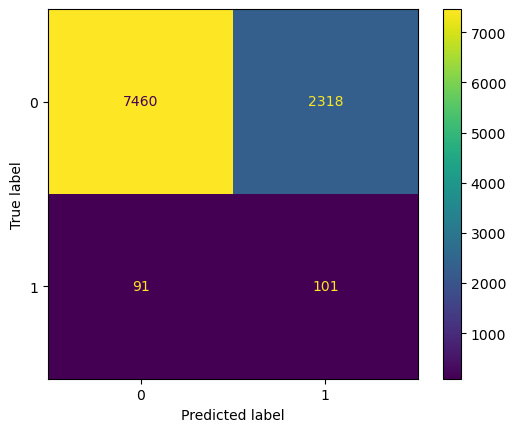

In [195]:
ds_result = fit_and_metrics_return(
        model_name='RidgeClassifier',  #  Имя модели
        pipe = pipe_rc,       # pipeline
        param = param_rc,      # подготовленные параметры для перебора
        n_iter =iter_num,     # количество итераций
        verbose = 100,    # уровень логирования
        X_train = X_train,    #  Тренеровочные данные
        y_train = y_train,    # тренеровочный признак
        X_test = X_test,     #  тестовые данные
        y_test = y_test      #  тестовый признак
)


ds_mitrics_result = pd.concat([
                                ds_mitrics_result,
                                ds_result
                            ])

#ds_mitrics_result = ds_result

### LogisticRegression

In [196]:
pipe_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression(
                                random_state=RANDOM_STATE, 
                                max_iter= 5000,
                                class_weight = 'balanced'
                                )
    )
])

param_lr = {
    'model__solver': [
                      'newton-cg', 
                      'lbfgs', 
                      'liblinear', 
#                      'sag', 
#                      'saga'
                     ],
    'model__C': [0.1, 0.5, 1.0, 10.0],
}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START model__C=10.0, model__solver=lbfgs..........................
[CV 2/5; 1/5] START model__C=10.0, model__solver=lbfgs..........................
[CV 3/5; 1/5] START model__C=10.0, model__solver=lbfgs..........................
[CV 4/5; 1/5] START model__C=10.0, model__solver=lbfgs..........................
[CV 5/5; 1/5] START model__C=10.0, model__solver=lbfgs..........................
[CV 1/5; 2/5] START model__C=10.0, model__solver=newton-cg......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 2/5] END model__C=10.0, model__solver=newton-cg;, score=0.658 total time=  23.4s
[CV 2/5; 2/5] START model__C=10.0, model__solver=newton-cg......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 1/5] END model__C=10.0, model__solver=lbfgs;, score=0.686 total time=  36.1s
[CV 3/5; 2/5] START model__C=10.0, model__solver=newton-cg......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 1/5] END model__C=10.0, model__solver=lbfgs;, score=0.643 total time=  36.5s
[CV 4/5; 2/5] START model__C=10.0, model__solver=newton-cg......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 1/5] END model__C=10.0, model__solver=lbfgs;, score=0.656 total time=  39.8s
[CV 5/5; 2/5] START model__C=10.0, model__solver=newton-cg......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 1/5] END model__C=10.0, model__solver=lbfgs;, score=0.685 total time=  47.0s
[CV 1/5; 3/5] START model__C=0.1, model__solver=newton-cg.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 1/5] END model__C=10.0, model__solver=lbfgs;, score=0.666 total time=  47.2s
[CV 2/5; 3/5] START model__C=0.1, model__solver=newton-cg.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 2/5] END model__C=10.0, model__solver=newton-cg;, score=0.685 total time=  26.0s
[CV 3/5; 3/5] START model__C=0.1, model__solver=newton-cg.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 3/5] END model__C=0.1, model__solver=newton-cg;, score=0.739 total time=  10.7s
[CV 4/5; 3/5] START model__C=0.1, model__solver=newton-cg.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 3/5] END model__C=0.1, model__solver=newton-cg;, score=0.718 total time=  11.4s
[CV 5/5; 3/5] START model__C=0.1, model__solver=newton-cg.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 2/5] END model__C=10.0, model__solver=newton-cg;, score=0.686 total time=  24.8s
[CV 1/5; 4/5] START model__C=1.0, model__solver=liblinear.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 3/5] END model__C=0.1, model__solver=newton-cg;, score=0.699 total time=  15.0s
[CV 2/5; 4/5] START model__C=1.0, model__solver=liblinear.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 3/5] END model__C=0.1, model__solver=newton-cg;, score=0.736 total time=   9.7s
[CV 3/5; 4/5] START model__C=1.0, model__solver=liblinear.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 3/5] END model__C=0.1, model__solver=newton-cg;, score=0.728 total time=  10.8s
[CV 4/5; 4/5] START model__C=1.0, model__solver=liblinear.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 2/5] END model__C=10.0, model__solver=newton-cg;, score=0.640 total time=  35.1s
[CV 5/5; 4/5] START model__C=1.0, model__solver=liblinear.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 4/5] END model__C=1.0, model__solver=liblinear;, score=0.676 total time=  10.2s
[CV 1/5; 5/5] START model__C=0.5, model__solver=liblinear.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 2/5] END model__C=10.0, model__solver=newton-cg;, score=0.666 total time=  32.1s
[CV 2/5; 5/5] START model__C=0.5, model__solver=liblinear.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 4/5] END model__C=1.0, model__solver=liblinear;, score=0.715 total time=  10.0s
[CV 3/5; 5/5] START model__C=0.5, model__solver=liblinear.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 4/5] END model__C=1.0, model__solver=liblinear;, score=0.669 total time=   8.5s
[CV 4/5; 5/5] START model__C=0.5, model__solver=liblinear.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 4/5] END model__C=1.0, model__solver=liblinear;, score=0.706 total time=   8.7s
[CV 5/5; 5/5] START model__C=0.5, model__solver=liblinear.......................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 5/5] END model__C=0.5, model__solver=liblinear;, score=0.688 total time=   6.3s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 5/5] END model__C=0.5, model__solver=liblinear;, score=0.725 total time=   6.6s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 4/5] END model__C=1.0, model__solver=liblinear;, score=0.699 total time=   7.5s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 5/5] END model__C=0.5, model__solver=liblinear;, score=0.679 total time=   5.5s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 5/5] END model__C=0.5, model__solver=liblinear;, score=0.712 total time=   3.8s
[CV 4/5; 5/5] END model__C=0.5, model__solver=liblinear;, score=0.715 total time=   4.7s



{'model__solver': 'newton-cg', 'model__C': 0.1}

Метрики модели LogisticRegression на тестовых данных :
ROC-AUC = 0.67
Precision = 0.04
Recall = 0.58
Accuracy = 0.75
Метрики модели LogisticRegression на тренировочных данных:


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ROC-AUC = 0.73
Precision = 0.05
Recall = 0.7
Accuracy = 0.76

Метрика оценки roc_auc



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__solver,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,41.093619,4.922599,0.230695,0.018850,lbfgs,10.0,"{'model__solver': 'lbfgs', 'model__C': 10.0}",0.655605,0.685092,0.642591,0.685528,0.665530,0.666869,0.016723,5
1,28.099699,4.527819,0.204451,0.024925,newton-cg,10.0,"{'model__solver': 'newton-cg', 'model__C': 10.0}",0.657675,0.685344,0.640156,0.685638,0.666205,0.667003,0.017275,4
2,11.301558,1.817537,0.222115,0.016330,newton-cg,0.1,"{'model__solver': 'newton-cg', 'model__C': 0.1}",0.718309,0.739215,0.698690,0.728303,0.735582,0.724020,0.014541,1
3,8.810976,0.998982,0.172752,0.013673,liblinear,1.0,"{'model__solver': 'liblinear', 'model__C': 1.0}",0.676273,0.714686,0.669261,0.705780,0.698816,0.692963,0.017382,3
4,5.245345,1.004288,0.141140,0.043474,liblinear,0.5,"{'model__solver': 'liblinear', 'model__C': 0.5}",0.688466,0.724888,0.678985,0.714587,0.711979,0.703781,0.017198,2


Время запуска перебора: 87.60 секунд


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------------------



,ROC_AUC,precision,recall,accuracy,f1_score,TN,FN,TP,FP,Model_name,Model_check,Model_scoring,Model_best_params
0,0.731503,0.054205,0.704811,0.757165,0.100669,29653,227,542,9457,LogisticRegression,Train,roc_auc,"{'model__solver': 'newton-cg', 'model__C': 0.1}"
0,0.669300,0.044711,0.583333,0.751956,0.083055,7385,80,112,2393,LogisticRegression,Test,roc_auc,"{'model__solver': 'newton-cg', 'model__C': 0.1}"


-----------------------------------------------


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


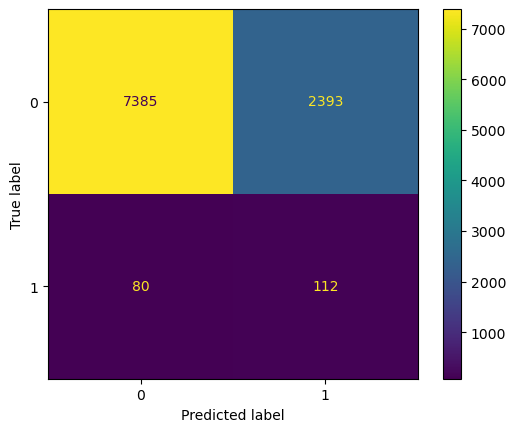

In [197]:
ds_result = fit_and_metrics_return(
        model_name='LogisticRegression',  #  Имя модели
        pipe = pipe_lr,       # pipeline
        param = param_lr,      # подготовленные параметры для перебора
        n_iter =iter_num,     # количество итераций
        verbose = 100,    # уровень логирования
        X_train = X_train,    #  Тренеровочные данные
        y_train = y_train,    # тренеровочный признак
        X_test = X_test,     #  тестовые данные
        y_test = y_test      #  тестовый признак
)
ds_mitrics_result = pd.concat([
                                ds_mitrics_result,
                                ds_result
                            ])

### DummyClassifier

In [198]:
pipe_dc = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DummyClassifier(
                                random_state=RANDOM_STATE,                                
                                )
    )
])

param_dc = {
    'model__strategy': [
                      'most_frequent', 
                      'prior', 
                      'stratified', 
                      'uniform', 
                     ],
}

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START model__strategy=most_frequent...............................
[CV 2/5; 1/4] START model__strategy=most_frequent...............................
[CV 3/5; 1/4] START model__strategy=most_frequent...............................
[CV 4/5; 1/4] START model__strategy=most_frequent...............................
[CV 5/5; 1/4] START model__strategy=most_frequent...............................
[CV 1/5; 2/4] START model__strategy=prior.......................................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/p

[CV 2/5; 1/4] END model__strategy=most_frequent;, score=0.500 total time=   0.9s
[CV 1/5; 1/4] END model__strategy=most_frequent;, score=0.500 total time=   0.9s
[CV 2/5; 2/4] START model__strategy=prior.......................................
[CV 3/5; 2/4] START model__strategy=prior.......................................
[CV 3/5; 1/4] END model__strategy=most_frequent;, score=0.500 total time=   0.9s
[CV 4/5; 2/4] START model__strategy=prior.......................................
[CV 4/5; 1/4] END model__strategy=most_frequent;, score=0.500 total time=   1.0s
[CV 1/5; 2/4] END ........model__strategy=prior;, score=0.500 total time=   1.0s
[CV 5/5; 2/4] START model__strategy=prior.......................................
[CV 1/5; 3/4] START model__strategy=stratified..................................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 1/4] END model__strategy=most_frequent;, score=0.500 total time=   1.0s
[CV 2/5; 3/4] START model__strategy=stratified..................................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 2/4] END ........model__strategy=prior;, score=0.500 total time=   0.9s
[CV 3/5; 3/4] START model__strategy=stratified..................................
[CV 4/5; 2/4] END ........model__strategy=prior;, score=0.500 total time=   0.9s
[CV 4/5; 3/4] START model__strategy=stratified..................................
[CV 3/5; 2/4] END ........model__strategy=prior;, score=0.500 total time=   1.0s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 3/4] START model__strategy=stratified..................................
[CV 1/5; 3/4] END ...model__strategy=stratified;, score=0.504 total time=   1.0s
[CV 2/5; 3/4] END ...model__strategy=stratified;, score=0.497 total time=   0.9s
[CV 5/5; 2/4] END ........model__strategy=prior;, score=0.500 total time=   1.0s
[CV 1/5; 4/4] START model__strategy=uniform.....................................
[CV 2/5; 4/4] START model__strategy=uniform.....................................
[CV 3/5; 4/4] START model__strategy=uniform.....................................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 3/4] END ...model__strategy=stratified;, score=0.501 total time=   0.9s
[CV 4/5; 4/4] START model__strategy=uniform.....................................
[CV 4/5; 3/4] END ...model__strategy=stratified;, score=0.494 total time=   1.0s
[CV 5/5; 4/4] START model__strategy=uniform.....................................


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 4/4] END ......model__strategy=uniform;, score=0.500 total time=   0.9s
[CV 2/5; 4/4] END ......model__strategy=uniform;, score=0.500 total time=   0.9s
[CV 5/5; 3/4] END ...model__strategy=stratified;, score=0.507 total time=   1.0s
[CV 3/5; 4/4] END ......model__strategy=uniform;, score=0.500 total time=   1.0s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 4/4] END ......model__strategy=uniform;, score=0.500 total time=   0.7s
[CV 5/5; 4/4] END ......model__strategy=uniform;, score=0.500 total time=   0.6s



{'model__strategy': 'stratified'}

Метрики модели DummyClassifier на тестовых данных :
ROC-AUC = 0.51
Precision = 0.04
Recall = 0.03
Accuracy = 0.96
Метрики модели DummyClassifier на тренировочных данных:


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ROC-AUC = 0.5
Precision = 0.02
Recall = 0.02
Accuracy = 0.96

Метрика оценки roc_auc



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.786965,0.064307,0.156387,0.013259,most_frequent,{'model__strategy': 'most_frequent'},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,2
1,0.791753,0.087112,0.163750,0.020805,prior,{'model__strategy': 'prior'},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,2
2,0.798088,0.057166,0.163293,0.023554,stratified,{'model__strategy': 'stratified'},0.503974,0.497353,0.500663,0.494042,0.507391,0.500685,0.004712,1
3,0.708731,0.126280,0.120102,0.021864,uniform,{'model__strategy': 'uniform'},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,2


Время запуска перебора: 4.76 секунд


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------------------



,ROC_AUC,precision,recall,accuracy,f1_score,TN,FN,TP,FP,Model_name,Model_check,Model_scoring,Model_best_params
0,0.498864,0.017038,0.016905,0.962236,0.016971,38360,756,13,750,DummyClassifier,Train,roc_auc,{'model__strategy': 'stratified'}
0,0.507239,0.035294,0.031250,0.964895,0.033149,9614,186,6,164,DummyClassifier,Test,roc_auc,{'model__strategy': 'stratified'}


-----------------------------------------------


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


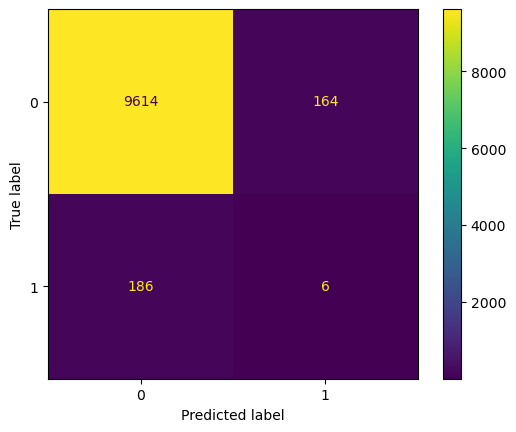

In [199]:
ds_result = fit_and_metrics_return(
        model_name='DummyClassifier',  #  Имя модели
        pipe = pipe_dc,       # pipeline
        param = param_dc,      # подготовленные параметры для перебора
        n_iter =iter_num,     # количество итераций
        verbose = 100,    # уровень логирования
        X_train = X_train,    #  Тренеровочные данные
        y_train = y_train,    # тренеровочный признак
        X_test = X_test,     #  тестовые данные
        y_test = y_test      #  тестовый признак
)
ds_mitrics_result = pd.concat([
                                ds_mitrics_result,
                                ds_result
                            ])

### LightGBM

In [200]:
#import lightgbm as lgb
from lightgbm import LGBMClassifier

pipe_LGBM = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMClassifier(
                            random_state=RANDOM_STATE,
#                             class_weight = 'balanced',
                            is_unbalance=True,
                            objective='binary',
                             )
    )
])

param_LightGBM = {
#    'models__max_depth': range(4,16),
    'models__learning_rate': [0.02, 0.05, 0.1],
    'models__n_estimators': [ 100, 200, 500, 1000],
#    'models__reg_alpha': [0, 1, 5],
#    'models__reg_lambda': [0, 1, 5],
}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 2/5; 1/5] START models__learning_rate=0.1, models__n_estimators=500.........
[CV 1/5; 1/5] START models__learning_rate=0.1, models__n_estimators=500.........
[CV 3/5; 1/5] START models__learning_rate=0.1, models__n_estimators=500.........
[CV 1/5; 2/5] START models__learning_rate=0.1, models__n_estimators=200.........
[CV 5/5; 1/5] START models__learning_rate=0.1, models__n_estimators=500.........
[CV 4/5; 1/5] START models__learning_rate=0.1, models__n_estimators=500.........
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Number of positive: 616, number of negative: 31288
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 1/5; 2/5] END models__learning_rate=0.1, models__n_estimators=200;, score=0.636 total time=  13.7s
[CV 2/5; 2/5] START models__learning_rate=0.1, models__n_estimators=200.........
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6760
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 284
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019277 -> initscore=-3.929368
[LightGBM] [Info] Start training from score -3.929368


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 2/5; 2/5] END models__learning_rate=0.1, models__n_estimators=200;, score=0.703 total time=  13.8s
[CV 3/5; 2/5] START models__learning_rate=0.1, models__n_estimators=200.........


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 1/5] END models__learning_rate=0.1, models__n_estimators=500;, score=0.635 total time=  29.1s
[CV 4/5; 2/5] START models__learning_rate=0.1, models__n_estimators=200.........


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 3/5; 1/5] END models__learning_rate=0.1, models__n_estimators=500;, score=0.591 total time=  29.5s
[CV 5/5; 2/5] START models__learning_rate=0.1, models__n_estimators=200.........
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6763
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 281
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019277 -> initscore=-3.929368
[LightGBM] [Info] Start training from score -3.929368


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 4/5; 1/5] END models__learning_rate=0.1, models__n_estimators=500;, score=0.628 total time=  31.3s
[CV 1/5; 3/5] START models__learning_rate=0.02, models__n_estimators=100........
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6755
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 280
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019277 -> initscore=-3.929368
[LightGBM] [Info] Start training from score -3.929368
[LightGBM] [Info] Number of positive: 616, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 5/5; 1/5] END models__learning_rate=0.1, models__n_estimators=500;, score=0.613 total time=  34.5s
[CV 2/5; 3/5] START models__learning_rate=0.02, models__n_estimators=100........
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6755
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 282
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019277 -> initscore=-3.929368
[LightGBM] [Info] Start training from score -3.929368


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 2/5; 1/5] END models__learning_rate=0.1, models__n_estimators=500;, score=0.687 total time=  37.4s
[CV 3/5; 3/5] START models__learning_rate=0.02, models__n_estimators=100........
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6760
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 284
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019277 -> initscore=-3.929368
[LightGBM] [Info] Start training from score -3.929368


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[CV 1/5; 3/5] END models__learning_rate=0.02, models__n_estimators=100;, score=0.717 total time=   9.6s
[CV 4/5; 3/5] START models__learning_rate=0.02, models__n_estimators=100........
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6763
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 281
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019277 -> initscore=-3.929368
[LightGBM] [Info] Start training from score -3.929368


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 3/5] END models__learning_rate=0.02, models__n_estimators=100;, score=0.731 total time=   9.1s
[CV 5/5; 3/5] START models__learning_rate=0.02, models__n_estimators=100........


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 5/5; 2/5] END models__learning_rate=0.1, models__n_estimators=200;, score=0.651 total time=  14.5s
[CV 1/5; 4/5] START models__learning_rate=0.1, models__n_estimators=100.........
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6755
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 280
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019277 -> initscore=-3.929368
[LightGBM] [Info] Start training from score -3.929368


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 4/5; 2/5] END models__learning_rate=0.1, models__n_estimators=200;, score=0.648 total time=  16.0s
[CV 2/5; 4/5] START models__learning_rate=0.1, models__n_estimators=100.........


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 616, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6773
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 287
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019308 -> initscore=-3.927743
[LightGBM] [Info] Start training from score -3.927743
[CV 3/5; 2/5] END models__learning_rate=0.1, models__n_estimators=200;, score=0.600 total time=  19.1s
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6755
[CV 3/5; 4/

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6760
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 284
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019277 -> initscore=-3.929368
[LightGBM] [Info] Start training from score -3.929368


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 3/5; 3/5] END models__learning_rate=0.02, models__n_estimators=100;, score=0.690 total time=  10.4s
[CV 4/5; 4/5] START models__learning_rate=0.1, models__n_estimators=100.........
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6763
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 281
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019277 -> initscore=-3.929368
[LightGBM] [Info] Start training from score -3.929368
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bin

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 4/5; 3/5] END models__learning_rate=0.02, models__n_estimators=100;, score=0.718 total time=  11.4s
[CV 5/5; 4/5] START models__learning_rate=0.1, models__n_estimators=100.........


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 1/5; 4/5] END models__learning_rate=0.1, models__n_estimators=100;, score=0.664 total time=   8.8s
[CV 1/5; 5/5] START models__learning_rate=0.05, models__n_estimators=200........


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 5/5; 3/5] END models__learning_rate=0.02, models__n_estimators=100;, score=0.719 total time=   9.8s
[CV 2/5; 5/5] START models__learning_rate=0.05, models__n_estimators=200........
[CV 2/5; 4/5] END models__learning_rate=0.1, models__n_estimators=100;, score=0.702 total time=   8.4s
[CV 3/5; 5/5] START models__learning_rate=0.05, models__n_estimators=200........


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 616, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6773
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 287
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019308 -> initscore=-3.927743
[LightGBM] [Info] Start training from score -3.927743
[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6755
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 282
[LightGBM] [Info] [b

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 4/5; 4/5] END models__learning_rate=0.1, models__n_estimators=100;, score=0.654 total time=   9.6s
[CV 4/5; 5/5] START models__learning_rate=0.05, models__n_estimators=200........


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 3/5; 4/5] END models__learning_rate=0.1, models__n_estimators=100;, score=0.600 total time=  11.6s
[CV 5/5; 5/5] START models__learning_rate=0.05, models__n_estimators=200........


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Number of positive: 615, number of negative: 31288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6755
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 280
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019277 -> initscore=-3.929368
[LightGBM] [Info] Start training from score -3.929368


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 5/5; 4/5] END models__learning_rate=0.1, models__n_estimators=100;, score=0.682 total time=   8.4s
[LightGBM] [Info] Number of positive: 616, number of negative: 31288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6773
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 287
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019308 -> initscore=-3.927743
[LightGBM] [Info] Start training from score -3.927743


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 1/5; 5/5] END models__learning_rate=0.05, models__n_estimators=200;, score=0.687 total time=  13.6s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 3/5; 5/5] END models__learning_rate=0.05, models__n_estimators=200;, score=0.649 total time=  13.4s
[CV 2/5; 5/5] END models__learning_rate=0.05, models__n_estimators=200;, score=0.718 total time=  13.7s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 5/5; 5/5] END models__learning_rate=0.05, models__n_estimators=200;, score=0.693 total time=   9.9s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV 4/5; 5/5] END models__learning_rate=0.05, models__n_estimators=200;, score=0.680 total time=  11.1s
[LightGBM] [Info] Number of positive: 769, number of negative: 39110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 39879, number of used features: 313
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019283 -> initscore=-3.929042
[LightGBM] [Info] Start training from score -3.929042



{'models__n_estimators': 100, 'models__learning_rate': 0.02}

Метрики модели LGBMClassifier на тестовых данных :
ROC-AUC = 0.64
Precision = 0.06
Recall = 0.4
Accuracy = 0.87
Метрики модели LGBMClassifier на тренировочных данных:


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ROC-AUC = 0.86
Precision = 0.12
Recall = 0.83
Accuracy = 0.88

Метрика оценки roc_auc



/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__n_estimators,param_models__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,31.528069,3.155816,0.824137,0.045231,500,0.10,"{'models__n_estimators': 500, 'models__learnin...",0.634718,0.686515,0.590793,0.627825,0.612578,0.630486,0.031813,5
1,14.831344,2.008967,0.567092,0.068099,200,0.10,"{'models__n_estimators': 200, 'models__learnin...",0.635856,0.703093,0.600376,0.647836,0.650745,0.647581,0.033037,4
2,9.539017,0.769926,0.522020,0.078666,100,0.02,"{'models__n_estimators': 100, 'models__learnin...",0.717292,0.730682,0.689737,0.718494,0.719413,0.715123,0.013572,1
3,8.840624,1.161413,0.529035,0.056864,100,0.10,"{'models__n_estimators': 100, 'models__learnin...",0.664176,0.702272,0.599522,0.653879,0.682112,0.660393,0.034605,3
4,11.911483,1.403734,0.415213,0.173403,200,0.05,"{'models__n_estimators': 200, 'models__learnin...",0.687469,0.717582,0.648895,0.680066,0.692993,0.685401,0.022175,2


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Время запуска перебора: 71.76 секунд


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


-----------------------------------------------



/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,ROC_AUC,precision,recall,accuracy,f1_score,TN,FN,TP,FP,Model_name,Model_check,Model_scoring,Model_best_params
0,0.857851,0.122095,0.833550,0.881216,0.212992,34501,128,641,4609,LGBMClassifier,Train,roc_auc,"{'models__n_estimators': 100, 'models__learnin..."
0,0.641255,0.062298,0.401042,0.872217,0.107843,8619,115,77,1159,LGBMClassifier,Test,roc_auc,"{'models__n_estimators': 100, 'models__learnin..."


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-----------------------------------------------


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


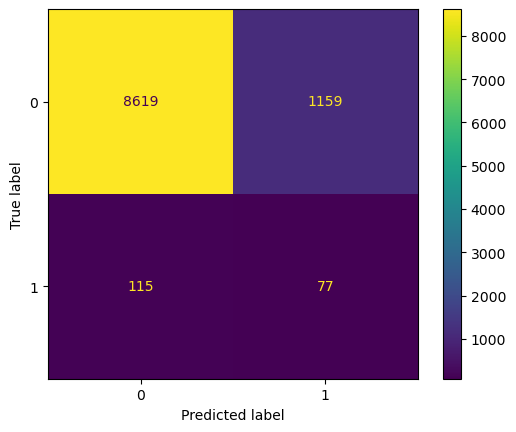

In [201]:
ds_result = fit_and_metrics_return(
        model_name='LGBMClassifier',  #  Имя модели
        pipe = pipe_LGBM,       # pipeline
        param = param_LightGBM,      # подготовленные параметры для перебора
        n_iter =iter_num,     # количество итераций
        verbose = 100,    # уровень логирования
        X_train = X_train,    #  Тренеровочные данные
        y_train = y_train,    # тренеровочный признак
        X_test = X_test,     #  тестовые данные
        y_test = y_test      #  тестовый признак
)
ds_mitrics_result = pd.concat([
                                ds_mitrics_result,
                                ds_result
                            ])

### Таблица результатов

In [202]:
display(ds_mitrics_result)

,ROC_AUC,precision,recall,accuracy,f1_score,TN,FN,TP,FP,Model_name,Model_check,Model_scoring,Model_best_params
0,0.723385,0.053290,0.686606,0.758745,0.098904,29730,241,528,9380,CatBoostClassifier,Train,roc_auc,"{'model__learning_rate': 0.05, 'model__l2_leaf..."
0,0.680488,0.047093,0.598958,0.758877,0.087320,7451,77,115,2327,CatBoostClassifier,Test,roc_auc,"{'model__learning_rate': 0.05, 'model__l2_leaf..."
0,0.999350,1.000000,0.998700,0.999975,0.999349,39110,1,768,0,KNeighborsClassifier,Train,roc_auc,"{'model__weights': 'distance', 'model__n_neigh..."
0,0.502451,0.250000,0.005208,0.980542,0.010204,9775,191,1,3,KNeighborsClassifier,Test,roc_auc,"{'model__weights': 'distance', 'model__n_neigh..."
0,0.772532,0.097822,0.665800,0.875147,0.170581,34388,257,512,4722,RandomForestClassifier,Train,roc_auc,"{'model__n_estimators': 50, 'model__min_sample..."
0,0.650751,0.064388,0.421875,0.870812,0.111724,8601,111,81,1177,RandomForestClassifier,Test,roc_auc,"{'model__n_estimators': 50, 'model__min_sample..."
0,0.688894,0.042654,0.676203,0.701096,0.080247,27439,249,520,11671,DecisionTreeClassifier,Train,roc_auc,"{'model__min_samples_split': 2, 'model__min_sa..."
0,0.654098,0.038538,0.604167,0.702106,0.072455,6884,76,116,2894,DecisionTreeClassifier,Test,roc_auc,"{'model__min_samples_split': 2, 'model__min_sa..."
0,0.745837,0.058103,0.721717,0.769026,0.107548,30113,214,555,8997,RidgeClassifier,Train,roc_auc,"{'model__solver': 'lsqr', 'model__alpha': 10.0}"
0,0.644489,0.041753,0.526042,0.758375,0.077365,7460,91,101,2318,RidgeClassifier,Test,roc_auc,"{'model__solver': 'lsqr', 'model__alpha': 10.0}"


In [203]:
display(ds_mitrics_result.loc[ds_mitrics_result['Model_check'] =='Test'].sort_values(by = 'ROC_AUC', ascending=False))

,ROC_AUC,precision,recall,accuracy,f1_score,TN,FN,TP,FP,Model_name,Model_check,Model_scoring,Model_best_params
0,0.680488,0.047093,0.598958,0.758877,0.087320,7451,77,115,2327,CatBoostClassifier,Test,roc_auc,"{'model__learning_rate': 0.05, 'model__l2_leaf..."
0,0.669300,0.044711,0.583333,0.751956,0.083055,7385,80,112,2393,LogisticRegression,Test,roc_auc,"{'model__solver': 'newton-cg', 'model__C': 0.1}"
0,0.654098,0.038538,0.604167,0.702106,0.072455,6884,76,116,2894,DecisionTreeClassifier,Test,roc_auc,"{'model__min_samples_split': 2, 'model__min_sa..."
0,0.650751,0.064388,0.421875,0.870812,0.111724,8601,111,81,1177,RandomForestClassifier,Test,roc_auc,"{'model__n_estimators': 50, 'model__min_sample..."
0,0.644489,0.041753,0.526042,0.758375,0.077365,7460,91,101,2318,RidgeClassifier,Test,roc_auc,"{'model__solver': 'lsqr', 'model__alpha': 10.0}"
0,0.641255,0.062298,0.401042,0.872217,0.107843,8619,115,77,1159,LGBMClassifier,Test,roc_auc,"{'models__n_estimators': 100, 'models__learnin..."
0,0.507239,0.035294,0.031250,0.964895,0.033149,9614,186,6,164,DummyClassifier,Test,roc_auc,{'model__strategy': 'stratified'}
0,0.502451,0.250000,0.005208,0.980542,0.010204,9775,191,1,3,KNeighborsClassifier,Test,roc_auc,"{'model__weights': 'distance', 'model__n_neigh..."


Лучший результат после проверки на тестовых данных показывает модель CatBoostClassifier с результатом по ROC-AUC = 0.68

## Посчитаем лучшей моделью

In [204]:
pipe_fin = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', CatBoostClassifier(
                                silent=True, 
#                                cat_features=cat_features,
#                                  class_weights=class_weights, 
                                auto_class_weights='Balanced',                                  
                                iterations=300,
                                random_state=RANDOM_STATE,         
#                                eval_metric = 'Precision',
                                )
    )
])


params_fin = {'model__learning_rate': [0.05,0.1,0.25, 0.5],
    'model__depth': [2, 3, 4, ],
    'model__l2_leaf_reg': [5, 7, 10],
    'model__random_strength': [0.5, 1],
#    'model__early_stopping_rounds': [50],
            }

In [205]:
randomized_search = RandomizedSearchCV(
        pipe_fin,       # pipeline
        params_fin,      # подготовленные параметры для перебора
        n_iter =20,     # количество итераций
        cv=kfold,      # 
        scoring='roc_auc',
        verbose = 100,    # уровень логирования
        random_state=RANDOM_STATE,
        n_jobs=-1,
)

In [206]:
# Обучение
randomized_search.fit(X_train, y_train)
best_model = randomized_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 2/5; 1/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5
[CV 4/5; 1/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5
[CV 1/5; 1/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5
[CV 5/5; 1/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5
[CV 1/5; 2/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.1, model__random_strength=0.5
[CV 3/5; 1/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/prep

[CV 1/5; 1/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.737 total time=  18.6s
[CV 2/5; 2/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.1, model__random_strength=0.5
[CV 1/5; 2/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.1, model__random_strength=0.5;, score=0.725 total time=  18.5s
[CV 3/5; 2/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.1, model__random_strength=0.5
[CV 3/5; 1/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.724 total time=  18.5s
[CV 4/5; 2/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.1, model__random_strength=0.5
[CV 5/5; 1/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.741 total time=  18.8s
[CV 5/5; 2/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.1,

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/p

[CV 2/5; 2/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.1, model__random_strength=0.5;, score=0.747 total time=  19.0s
[CV 3/5; 3/20] START model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.25, model__random_strength=1
[CV 3/5; 2/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.1, model__random_strength=0.5;, score=0.716 total time=  18.9s
[CV 4/5; 3/20] START model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.25, model__random_strength=1
[CV 4/5; 2/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.1, model__random_strength=0.5;, score=0.718 total time=  19.4s
[CV 5/5; 3/20] START model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.25, model__random_strength=1
[CV 5/5; 2/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.1, model__random_strength=0.5;, score=0.738 total time=  19.4s
[CV 1/5; 4/20] START model__depth=4, model__l2_leaf_reg=7, model__learning_rate=0.05, mo

/home/segius/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5; 4/20] START model__depth=4, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/p

[CV 3/5; 3/20] END model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.25, model__random_strength=1;, score=0.666 total time=  19.3s
[CV 4/5; 4/20] START model__depth=4, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5
[CV 4/5; 3/20] END model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.25, model__random_strength=1;, score=0.685 total time=  20.0s
[CV 5/5; 4/20] START model__depth=4, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5
[CV 5/5; 3/20] END model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.25, model__random_strength=1;, score=0.717 total time=  19.9s
[CV 1/5; 5/20] START model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.05, model__random_strength=0.5
[CV 1/5; 4/20] END model__depth=4, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.735 total time=  21.2s
[CV 2/5; 4/20] END model__depth=4, model__l2_leaf_reg=7, model__learning_rate=0.05, mode

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 5/20] START model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.05, model__random_strength=0.5
[CV 3/5; 4/20] END model__depth=4, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.725 total time=  21.3s
[CV 4/5; 5/20] START model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.05, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 4/20] END model__depth=4, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.707 total time=  20.0s
[CV 5/5; 5/20] START model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.05, model__random_strength=0.5
[CV 5/5; 4/20] END model__depth=4, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.741 total time=  20.0s
[CV 1/5; 6/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5
[CV 1/5; 5/20] END model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.05, model__random_strength=0.5;, score=0.738 total time=  19.7s
[CV 2/5; 6/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 5/20] END model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.05, model__random_strength=0.5;, score=0.750 total time=  18.6s
[CV 3/5; 6/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 5/20] END model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.05, model__random_strength=0.5;, score=0.728 total time=  18.6s
[CV 4/5; 6/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5
[CV 4/5; 5/20] END model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.05, model__random_strength=0.5;, score=0.717 total time=  18.9s
[CV 5/5; 6/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 5/20] END model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.05, model__random_strength=0.5;, score=0.742 total time=  18.2s
[CV 1/5; 7/20] START model__depth=3, model__l2_leaf_reg=5, model__learning_rate=1, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 6/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.686 total time=  18.0s
[CV 2/5; 7/20] START model__depth=3, model__l2_leaf_reg=5, model__learning_rate=1, model__random_strength=1
[CV 1/5; 6/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.616 total time=  19.4s
[CV 3/5; 7/20] START model__depth=3, model__l2_leaf_reg=5, model__learning_rate=1, model__random_strength=1
[CV 2/5; 6/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.710 total time=  19.7s
[CV 4/5; 7/20] START model__depth=3, model__l2_leaf_reg=5, model__learning_rate=1, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 6/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.662 total time=  18.1s
[CV 5/5; 7/20] START model__depth=3, model__l2_leaf_reg=5, model__learning_rate=1, model__random_strength=1
[CV 5/5; 6/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.678 total time=  18.4s
[CV 1/5; 8/20] START model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 7/20] END model__depth=3, model__l2_leaf_reg=5, model__learning_rate=1, model__random_strength=1;, score=0.612 total time=  19.3s
[CV 2/5; 8/20] START model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1
[CV 1/5; 7/20] END model__depth=3, model__l2_leaf_reg=5, model__learning_rate=1, model__random_strength=1;, score=0.609 total time=  20.9s
[CV 3/5; 8/20] START model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 7/20] END model__depth=3, model__l2_leaf_reg=5, model__learning_rate=1, model__random_strength=1;, score=0.597 total time=  20.7s
[CV 4/5; 8/20] START model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1
[CV 3/5; 7/20] END model__depth=3, model__l2_leaf_reg=5, model__learning_rate=1, model__random_strength=1;, score=0.615 total time=  21.1s
[CV 5/5; 8/20] START model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1
[CV 5/5; 7/20] END model__depth=3, model__l2_leaf_reg=5, model__learning_rate=1, model__random_strength=1;, score=0.573 total time=  20.7s
[CV 1/5; 9/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5
[CV 1/5; 8/20] END model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1;, score=0.636 total time=  20.1s
[CV 2/5; 9/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_streng

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 8/20] END model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1;, score=0.701 total time=  19.8s
[CV 3/5; 9/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 8/20] END model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1;, score=0.647 total time=  20.3s
[CV 4/5; 9/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 9/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.741 total time=  18.2s
[CV 5/5; 9/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5
[CV 4/5; 8/20] END model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1;, score=0.652 total time=  20.3s
[CV 1/5; 10/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.25, model__random_strength=0.5
[CV 2/5; 9/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.748 total time=  19.0s
[CV 2/5; 10/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.25, model__random_strength=0.5
[CV 5/5; 8/20] END model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1;, score=0.645 total time=  20.9s
[CV 3/5; 10/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.25, 

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 9/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.744 total time=  16.8s
[CV 4/5; 10/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.25, model__random_strength=0.5
[CV 3/5; 9/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.726 total time=  19.2s
[CV 5/5; 10/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.25, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 9/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.05, model__random_strength=0.5;, score=0.719 total time=  19.2s
[CV 1/5; 11/20] START model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.05, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 10/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.25, model__random_strength=0.5;, score=0.721 total time=  18.7s
[CV 2/5; 11/20] START model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.05, model__random_strength=1
[CV 3/5; 10/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.25, model__random_strength=0.5;, score=0.674 total time=  19.2s
[CV 3/5; 11/20] START model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.05, model__random_strength=1
[CV 1/5; 10/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.25, model__random_strength=0.5;, score=0.677 total time=  20.0s
[CV 4/5; 11/20] START model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.05, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 10/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.25, model__random_strength=0.5;, score=0.655 total time=  18.4s
[CV 5/5; 11/20] START model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.05, model__random_strength=1
[CV 5/5; 10/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=0.25, model__random_strength=0.5;, score=0.698 total time=  19.2s
[CV 1/5; 12/20] START model__depth=3, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 11/20] END model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.05, model__random_strength=1;, score=0.734 total time=  19.6s
[CV 2/5; 12/20] START model__depth=3, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 11/20] END model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.05, model__random_strength=1;, score=0.720 total time=  19.2s
[CV 3/5; 12/20] START model__depth=3, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1
[CV 2/5; 11/20] END model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.05, model__random_strength=1;, score=0.746 total time=  20.5s
[CV 4/5; 12/20] START model__depth=3, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 11/20] END model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.05, model__random_strength=1;, score=0.715 total time=  20.6s
[CV 5/5; 12/20] START model__depth=3, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 11/20] END model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.05, model__random_strength=1;, score=0.741 total time=  20.6s
[CV 1/5; 13/20] START model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5
[CV 1/5; 12/20] END model__depth=3, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1;, score=0.697 total time=  19.8s
[CV 2/5; 13/20] START model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 12/20] END model__depth=3, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1;, score=0.704 total time=  20.5s
[CV 3/5; 13/20] START model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5
[CV 4/5; 12/20] END model__depth=3, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1;, score=0.661 total time=  19.8s
[CV 4/5; 13/20] START model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 12/20] END model__depth=3, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1;, score=0.667 total time=  20.8s
[CV 5/5; 13/20] START model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5
[CV 5/5; 12/20] END model__depth=3, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=1;, score=0.684 total time=  19.3s
[CV 1/5; 14/20] START model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 13/20] END model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.635 total time=  20.5s
[CV 2/5; 14/20] START model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5
[CV 2/5; 13/20] END model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.687 total time=  21.3s
[CV 3/5; 14/20] START model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 13/20] END model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.633 total time=  20.8s
[CV 4/5; 14/20] START model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5
[CV 4/5; 13/20] END model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.636 total time=  20.4s
[CV 5/5; 14/20] START model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5
[CV 5/5; 13/20] END model__depth=3, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.653 total time=  20.6s
[CV 1/5; 15/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.1, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 14/20] END model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.625 total time=  20.7s
[CV 2/5; 15/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.1, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 14/20] END model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.677 total time=  21.8s
[CV 3/5; 15/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.1, model__random_strength=0.5
[CV 3/5; 14/20] END model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.652 total time=  20.6s
[CV 4/5; 15/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.1, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 14/20] END model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.637 total time=  21.7s
[CV 5/5; 15/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.1, model__random_strength=0.5
[CV 5/5; 14/20] END model__depth=4, model__l2_leaf_reg=10, model__learning_rate=0.5, model__random_strength=0.5;, score=0.627 total time=  20.5s
[CV 1/5; 16/20] START model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=0.5
[CV 1/5; 15/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.1, model__random_strength=0.5;, score=0.724 total time=  19.9s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 16/20] START model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=0.5
[CV 2/5; 15/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.1, model__random_strength=0.5;, score=0.748 total time=  20.2s
[CV 3/5; 16/20] START model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 15/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.1, model__random_strength=0.5;, score=0.708 total time=  17.3s
[CV 3/5; 15/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.1, model__random_strength=0.5;, score=0.724 total time=  18.3s
[CV 4/5; 16/20] START model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 16/20] START model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=0.5
[CV 1/5; 16/20] END model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=0.5;, score=0.703 total time=  18.4s
[CV 1/5; 17/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=0.5
[CV 5/5; 15/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=0.1, model__random_strength=0.5;, score=0.735 total time=  19.1s
[CV 2/5; 17/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 16/20] END model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=0.5;, score=0.733 total time=  19.0s
[CV 3/5; 17/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=0.5
[CV 3/5; 16/20] END model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=0.5;, score=0.694 total time=  19.7s
[CV 4/5; 17/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 16/20] END model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=0.5;, score=0.676 total time=  19.1s
[CV 5/5; 17/20] START model__depth=2, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 16/20] END model__depth=2, model__l2_leaf_reg=5, model__learning_rate=0.25, model__random_strength=0.5;, score=0.709 total time=  17.9s
[CV 1/5; 18/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=1, model__random_strength=0.5
[CV 1/5; 17/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=0.5;, score=0.605 total time=  19.2s
[CV 2/5; 18/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=1, model__random_strength=0.5
[CV 2/5; 17/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=0.5;, score=0.655 total time=  19.2s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 18/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=1, model__random_strength=0.5
[CV 3/5; 17/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=0.5;, score=0.606 total time=  19.4s
[CV 4/5; 18/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=1, model__random_strength=0.5
[CV 4/5; 17/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=0.5;, score=0.644 total time=  19.1s
[CV 5/5; 18/20] START model__depth=2, model__l2_leaf_reg=10, model__learning_rate=1, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 17/20] END model__depth=2, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=0.5;, score=0.620 total time=  19.7s
[CV 1/5; 19/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=1
[CV 2/5; 18/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=1, model__random_strength=0.5;, score=0.664 total time=  19.6s
[CV 2/5; 19/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 18/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=1, model__random_strength=0.5;, score=0.601 total time=  21.9s
[CV 3/5; 19/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=1


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5; 18/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=1, model__random_strength=0.5;, score=0.622 total time=  19.9s
[CV 4/5; 19/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=1
[CV 4/5; 18/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=1, model__random_strength=0.5;, score=0.595 total time=  19.6s
[CV 5/5; 19/20] START model__depth=3, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=1
[CV 5/5; 18/20] END model__depth=2, model__l2_leaf_reg=10, model__learning_rate=1, model__random_strength=0.5;, score=0.605 total time=  19.4s
[CV 1/5; 20/20] START model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.1, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5; 19/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=1;, score=0.631 total time=  18.8s
[CV 2/5; 20/20] START model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.1, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 19/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=1;, score=0.636 total time=  19.8s
[CV 3/5; 20/20] START model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.1, model__random_strength=0.5
[CV 3/5; 19/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=1;, score=0.597 total time=  19.5s
[CV 4/5; 20/20] START model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.1, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 19/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=1;, score=0.601 total time=  20.4s
[CV 5/5; 20/20] START model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.1, model__random_strength=0.5


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 19/20] END model__depth=3, model__l2_leaf_reg=7, model__learning_rate=1, model__random_strength=1;, score=0.612 total time=  21.1s
[CV 1/5; 20/20] END model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.1, model__random_strength=0.5;, score=0.704 total time=  21.6s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5; 20/20] END model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.1, model__random_strength=0.5;, score=0.724 total time=  18.1s


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 20/20] END model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.1, model__random_strength=0.5;, score=0.689 total time=  16.3s
[CV 3/5; 20/20] END model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.1, model__random_strength=0.5;, score=0.679 total time=  16.4s
[CV 5/5; 20/20] END model__depth=4, model__l2_leaf_reg=5, model__learning_rate=0.1, model__random_strength=0.5;, score=0.712 total time=  13.9s


In [207]:
#print('Лучшая модель и её параметры:\n', randomized_search.best_estimator_)
print('Качество по кросс-валидации', randomized_search.best_score_)

Качество по кросс-валидации 0.735686787363807


In [208]:
best_model = randomized_search.best_estimator_
show_metrics(best_model, X_test, y_test)

/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ROC-AUC = 0.67
Precision = 0.04
Recall = 0.59
Accuracy = 0.75


In [209]:
data = randomized_search.cv_results_
df_result = pd.DataFrame(data)#, index=data[:,0])
display(df_result)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__random_strength,param_model__learning_rate,param_model__l2_leaf_reg,param_model__depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,16.674540,0.555018,2.315472,0.110545,0.5,0.05,7,3,"{'model__random_strength': 0.5, 'model__learni...",0.737199,0.745087,0.724286,0.717366,0.741273,0.733042,0.010512,3
1,15.968181,0.594578,3.057198,0.380094,0.5,0.10,10,2,"{'model__random_strength': 0.5, 'model__learni...",0.725460,0.746684,0.715912,0.718492,0.737542,0.728818,0.011660,6
2,16.816458,0.619612,2.882066,0.526208,1.0,0.25,10,3,"{'model__random_strength': 1, 'model__learning...",0.668347,0.729644,0.666459,0.684932,0.716821,0.693241,0.025641,10
3,17.252275,0.945116,3.328678,0.443554,0.5,0.05,7,4,"{'model__random_strength': 0.5, 'model__learni...",0.734530,0.742290,0.724745,0.706504,0.741376,0.729889,0.013271,5
4,15.895508,0.823399,2.908032,0.647420,0.5,0.05,5,2,"{'model__random_strength': 0.5, 'model__learni...",0.737529,0.750359,0.728278,0.716838,0.741739,0.734949,0.011513,2
5,15.728507,0.638274,2.989784,0.632561,0.5,0.50,10,2,"{'model__random_strength': 0.5, 'model__learni...",0.615779,0.710334,0.686309,0.661625,0.677522,0.670314,0.031493,13
6,17.363806,1.079736,3.163208,0.604775,1.0,1.00,5,3,"{'model__random_strength': 1, 'model__learning...",0.609412,0.612335,0.614740,0.597256,0.572542,0.601257,0.015566,20
7,17.439417,0.770365,2.837201,0.602652,1.0,0.25,5,4,"{'model__random_strength': 1, 'model__learning...",0.635613,0.701092,0.646719,0.651688,0.645002,0.656023,0.023128,14
8,15.271481,1.004463,3.190202,0.557312,0.5,0.05,7,2,"{'model__random_strength': 0.5, 'model__learni...",0.741081,0.748125,0.726355,0.718834,0.744040,0.735687,0.011177,1
9,16.235268,1.186743,2.874902,0.777618,0.5,0.25,7,3,"{'model__random_strength': 0.5, 'model__learni...",0.677432,0.721065,0.673827,0.654774,0.698001,0.685020,0.022651,11


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


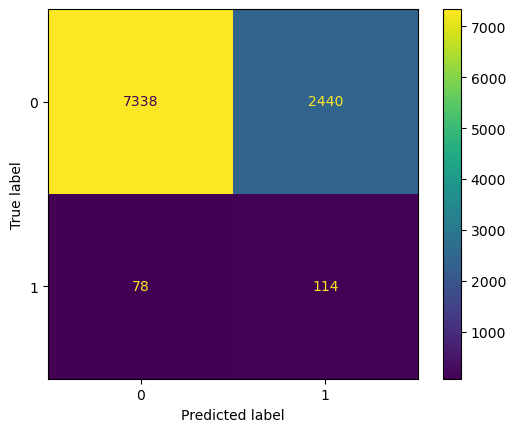

In [210]:
# построим матрицу ошибок методом from_estimator()
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

In [211]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(cm)

TN = cm[0,0]
FN = cm[1,0]
TP = cm[1,1]
FP = cm[0,1]


/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[[7338 2440]
 [  78  114]]


In [212]:
print('Модель правильно (True) предсказала 0 (Negative) в ', TN ,'случаях – значит TN =', TN,'.')

print('Модель неправильно (False) предсказала 0 (Negative) в ',FN ,'случаях – значит FN =',FN ,'.')

print('Модель правильно (True) предсказала 1 (Positive) в', TP ,'случаях – значит TP =',TP,'.')

print('Модель неправильно (False) предсказала 1 (Positive) в ',FP ,'случаев – значит FP =',FP,'.')

Модель правильно (True) предсказала 0 (Negative) в  7338 случаях – значит TN = 7338 .
Модель неправильно (False) предсказала 0 (Negative) в  78 случаях – значит FN = 78 .
Модель правильно (True) предсказала 1 (Positive) в 114 случаях – значит TP = 114 .
Модель неправильно (False) предсказала 1 (Positive) в  2440 случаев – значит FP = 2440 .


In [213]:
display(y_test.value_counts())

target
0    9778
1     192
Name: count, dtype: int64

## Натравим на результат SHAP

In [216]:
X_train_preproc = pipe_fin.named_steps['preprocessor'].fit_transform(X_train)
X_test__preproc = pipe_fin.named_steps['preprocessor'].transform(X_test)

explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['model'], X_train_preproc)

feature_names = pipe_fin.named_steps['preprocessor'].get_feature_names_out()

X_test__preproc = pd.DataFrame(X_test__preproc, columns=feature_names)
shap_values = explainer(X_test__preproc)



/home/segius/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 94%|=================== | 9392/9970 [00:15<00:00]       

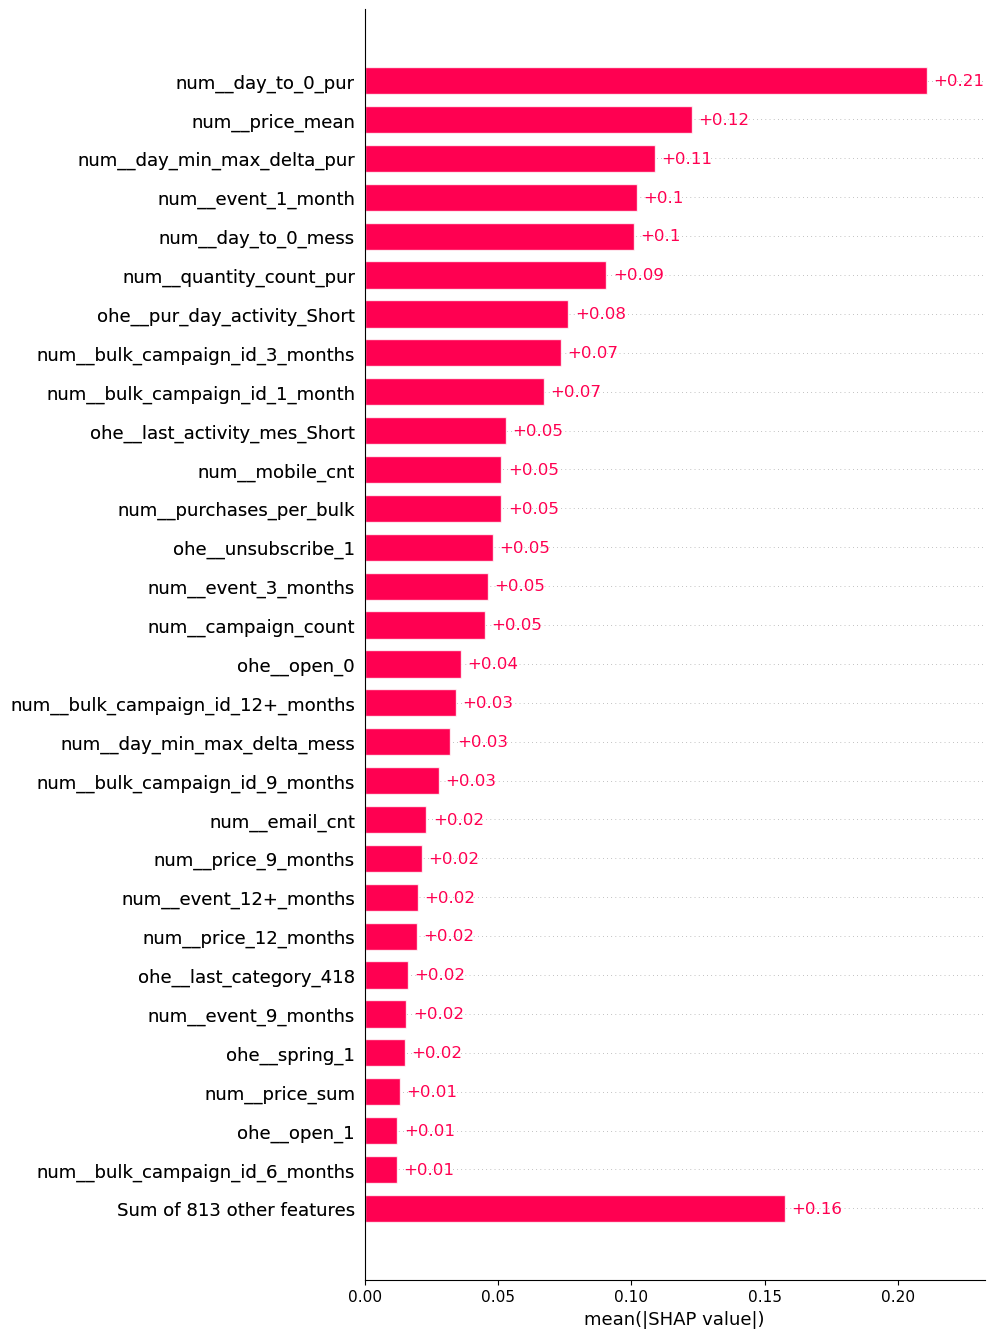

In [217]:
shap.plots.bar(shap_values, max_display=30)

Самое большое влияние на результат оказывают следующие признаки:
* Количество рекламных компаний у пользователя
* Средняя стоимость заказа ?  (редко бывает в топе)
* Количество дней между первым и последним заказом.
* Рекламные события за последний месяц
*  Количество дней после последнего рекламного события.

* Остальные признаки мносят менее 0.1 каждый.


## Итог

In [215]:
#### Учёт времени
end_time_total = time.time()

elapsed_time_total = end_time_total - start_time_total

#print(f'Время подготовки данных по заказам: {elapsed_time_result_1:.2f} секунд')
print(f'Полное время работы программы: {elapsed_time_total:.2f} секунд')
print()
#print(f'Время запуска CatBoost: {elapsed_time_hiper_cb:.2f} секунд')

Полное время работы программы: 1129.29 секунд



Были загружены 5 наборов данных. 
* Даты преведены к формату data
* Уменьшена разрядность хранения целочисленных значений с 64 бита до 16-32.
* Обнаружен значительный перекос в целевом признаке: 50 к 1.
* Обнаружено что 99.5% заказов содержат 1 единицу товара
* 

Добавления данных:

* Создана аггрегирующие таблицы на основе ds_a_messages, группировка по client_id
* Создана аггрегирующие таблицы на основе ds_a_purchases, группировка по client_id
* Сделана разбивка статистики на периоды 1, 3, 6, 9, 12 , 12+ месяцев
* К агрегирующей таблице заказов добавлены признаки делались ли заказы зимой, весной, летом или осенью. Пытался оценить сезонность.
* Для каждого периода подсчитана статистика по количеству рекламных событий и количеству заказов.
* Добавлены бинарные признаки наличия активности в периодах.
* Добавлен признак "Количество дней между датой последней покупки и датой среза данных"
* Добавлен признак отписавшихся
* Добавлен признак открывших сайт/приложение из рекламной рассылки
* Добавлен признак заказывавших через приложение или рекламное оповещение
* Добавлены признаки для пользователей были ли рекламные компании через электронную почту или сотовую связь.
* Были соеденены все агрегированные таблицы с целевым набором данных ds_a_target_binary. Соединение происходило по признаку client_id.
* Добавлено ещё одно поле : количество заказов делёное на количество рекламных акций.
* Добавлен признак содержащих первую категорию из списка для каждого заказа. Предполагается что это категория на каторую покупатель нажал в первую очередь.
* Добавлен признак содержащих последнюю категорию из списка для каждого заказа. Предполагается что это категория указывает непосредственно на купленный товар.


Проведено обучение на моделях для бинарной классификации методом RandomizedSearchCV.
Модели показывают склонность к переобучению на тренеровочных данных.  В итоговой таблице результатов, лидером после проверки на тестовых данных стал метод CatBoost.
Его использовал для финальной проверки. Увеличил количество проверяемых наборов параметров.

Полученная модель показывает результат по ROC_AUC = 0.67. Что недостаточно для уверенного определения пользователей которые сделают покупку в магазине в ближайшие 3 месяца.
TruePositive = 114 при FalsePositive = 2440. Это очень маленькое совпадение. 

Одной из возможных причин является бисбаланс классов. 50 к 1. При включении Синтетического генерирования данных (SMOTE) получаем переобучение. Причём более сильное чем при автоматической балансировке в моделях.


Получается что почти никаие цели задачи не были достигнуты. Возможно это связано с отсутствием опыта в предметной области.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Если не добавлять признаки категорий, то ROC_AUC будет 0.68-0.69.
После добавления категорий - получил ROC_AUC 0.65-0.67. Т.е качество моели снизилось.
В момент добавления на одном из шагов "склеил" агрегированную таблицу с пользователями (49к) и таблицу с заказами (220к). И получил ROC_AUC = 0.98-0.99.
Долго не понимал что происходит. Потом разобрался что записи умножились в 4-5 раз. Появились почти полные дубли отличающиеся перввой категорией.
И при разделении в тренеровочном наборе данных и в тестовом наборе были почти полные копии.
</div>